## Import packages

In [ ]:
import os
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import copy
import sys
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

## Cell name

In [ ]:
# cell_name = 'CL075_230228'
# run_num = ['1', '2', '3']

# cell_name = 'CL079_230324'
# run_num = ['1', '2', '3']

# cell_name = 'CL090_230515'
# run_num = ['4', '5', '6']

## Read fluorescence structure data

In [ ]:
# # The code below is used to see whether a trial's post 2s is same as another trial's pre 2s.
# # However, no finding that a trial's post 2s is same as another trial's pre 2s, because the
# # post 2s periods are processed to make them more close to the baseline.

# # Here, use dFF data. Changing mat_data['Master_dFF'] to mat_data['Master_f'] to check F data.

# root_path = "/content/drive/MyDrive/Fluorescence_Data/FluoData4Fitting_Average"

# i = 1
# path_ = os.path.join(root_path, cell_name, cell_name + 'red_dFFStructuresrun' + run_num[i] + '.mat')
# mat_data = scipy.io.loadmat(path_)
# fluo_runx = mat_data['Master_dFF']

# conca_runx = np.empty((0,fluo_runx[0,0].shape[2]))
# index_record = []
# action = True
# while action:
#     action = False
#     for index, value in np.ndenumerate(fluo_dFF_runx):
#         value = np.squeeze(value)
#         # print(value.shape)
#         # print(value[-31:, :].shape)
#         if conca_runx.shape[0] == 0:
#             conca_runx = np.concatenate((conca_runx, value), axis=0)
#             index_record = index_record + [index]
#             action = True
#             break
#         if np.array_equal(conca_runx[:31, :], value[-31:, :]):
#             conca_runx = np.concatenate((value[:-31, :], conca_runx), axis=0)
#             index_record = [index] + index_record
#             action = True
#             break
#         if np.array_equal(conca_runx[-31:, :], value[:31, :]):
#             fluo_dFconca_dFF_runxF_runx = np.concatenate((conca_runx, value[31:, :]), axis=0)
#             index_record = index_record + [index]
#             action = True
#             break
# print(conca_runx.shape)
# # a shape (93, 10) means no found.

### Functions

In [ ]:
def read_conca_fluo_data(cell_name = 'CL090_230515',
             run_num = ['4', '5', '6'],
             color = 'red',
             datatype = 'F',
             root_path = "/content/drive/MyDrive/Fluorescence_Data/FluoData4Fitting_Average"):
    '''
    This fuction is used to concatenate dFF or F data from different pieces of
    red/green structure data.
    color = 'red' or 'green'
    type = 'F' or 'dFF'
    if len(run_num) is 3, the output is <class 'numpy.ndarray'> with shape (3, 48),
    and its elements are <class 'numpy.ndarray'> with shape (93, 1, 10) for red
    and shape (93, 281, 10) for green (281 is the number of components, 10 is
    the number of repeats and 93 is 6 seconds; the 2p imaging frequency is
    15.63 Hz so roughly 93 frames for 6 seconds).
    '''

    conca_fluo_data = np.empty((0, 48))

    for i in range(len(run_num)):
        path_ = os.path.join(root_path, cell_name, cell_name + color + '_dFFStructuresrun' + run_num[i] + '.mat')
        mat_data = scipy.io.loadmat(path_)
        if datatype == 'dFF':
            fluo_data_runx = mat_data['Master_dFF']
        elif datatype == 'F':
            fluo_data_runx = mat_data['Master_f']
        fluo_data_runx = fluo_data_runx[:, :-1] # delete the last column (49th)
        # print(type(fluo_data_runx))
        # print(fluo_data_runx.shape)
        # print(fluo_data_runx[0,0].shape)

        conca_fluo_data = np.concatenate((conca_fluo_data, fluo_data_runx), axis=0) # like np.vsatck

    return conca_fluo_data

def plot_all_trials(conca_fluo_data,
           cell_name = 'CL090_230515',
           run_num = ['4', '5', '6'],
           color = 'red',
           datatype = 'F',
           component = 1):
    '''
    This function draws the figures based on the conca_fluo_data generated by
    the function read_conca_fluo_data.
    color = 'red' or 'green'
    type = 'F' or 'dFF'
    component is for 'green'; it is from 1 to the component number.
    if color is 'red', it can be arbitrary value.
    '''
    runs_string = ' '.join(run_num)
    color_name = 'Red' if color == 'red' else 'Green'

    # Create some sample data
    x_intervals = np.linspace(0, 6, 94) # Divide [0, 6] into 94 intervals, cuz data length of a trial is 93
    x_middle_points = (x_intervals[:-1] + x_intervals[1:]) / 2  # Calculate middle points

    # Create a figure and axis
    fig, ax = plt.subplots(nrows=48, ncols=len(run_num), figsize=(5 * len(run_num), 3 * 48), constrained_layout=True)

    # Create sf array
    sf = np.tile([0.02, 0.08, 0.32], 16)
    # Create tf array
    tf = np.tile([1, 1, 1, 4, 4, 4], 8)
    # Create orientation array
    orientation = np.repeat(np.arange(0, 360, 45), 6)

    for x in range(48):
        for y in range(3):
            if color == 'green':
                data_patch = conca_fluo_data[y, x][:,component-1,:]
            if color == 'red':
                data_patch = np.squeeze(conca_fluo_data[y, x])
            for i in range(data_patch.shape[1]):
                ax[x, y].plot(x_middle_points, data_patch[:, i])

            # Set axis labels and title
            ax[x, y].set_xlabel('Time (seconds)', fontsize=16)
            ax[x, y].set_ylabel(datatype, fontsize=16)
            # ax.set_title('dFF for a trial', fontsize=18)

            # Set tick parameters
            ax[x, y].tick_params(labelsize=16)  # Adjust tick size as needed

            ax[x, y].axvspan(2, 4, facecolor='gray', alpha=0.2)

            if y == 0:
                x_data = ax[x, y].get_xticks()
                y_data = ax[x, y].get_yticks()
                x_data_min = np.min(x_data)
                x_data_max = np.max(x_data)
                y_data_min = np.min(y_data)
                y_data_max = np.max(y_data)
                x_text = x_data_min - 0.3 * (x_data_max - x_data_min)
                y_text = 0.5 * (y_data_max + y_data_min)

        # Write the group information to the right of each row
        ax[x, 0].text(x_text, y_text, f'Ori: {orientation[x]}° \nTF: {tf[x]} \nSF: {sf[x]}', fontsize=14, va='center')
    if color == 'red':
        fig.suptitle(f'All Conditions All Rounds All Repests {color_name} {datatype} Data ({cell_name}) (Columns: run {runs_string})', fontsize=16)
        filename = f'{cell_name}_{color_name}_{datatype}.pdf'
    if color == 'green':
        fig.suptitle(f'All Conditions All Rounds All Repests {color_name} {datatype} Data ({cell_name} Component {component}) (Columns: run {runs_string})', fontsize=16)
        filename = f'{cell_name}_{color_name}_{datatype}_{component:03d}.pdf'
    plt.savefig(filename)
    plt.show()

In [ ]:
# color = 'green'
# datatype = 'F'
# component = 1
# conca_fluo_data = read_conca_fluo_data(cell_name, run_num, color, datatype)
# plot_all_trials(conca_fluo_data, cell_name, run_num, color, datatype, component)

# print(type(conca_fluo_data))
# print(conca_fluo_data.shape)
# print(type(conca_fluo_data[1,1]))
# print(conca_fluo_data[1,1].shape)

### Read red and green data then plot

In [ ]:
# cell_name_list = ['CL075_230228', 'CL079_230324' 'CL090_230515']
# run_num_list = [['1', '2', '3'], ['1', '2', '3'], ['4', '5', '6']]

# cell_name_list = ['CL090_230515']
# run_num_list = [['4', '5', '6']]

# for cell_name_, run_num_ in zip(cell_name_list, run_num_list):
#     for color_ in ['red', 'green']:
#         for datatype_ in ['F', 'dFF']:
#             conca_fluo_data_ = read_conca_fluo_data(cell_name_, run_num_, color_, datatype_)
#             if color_ == 'red':
#                 plot_all_trials(conca_fluo_data_, cell_name_, run_num_, color_, datatype_)
#             if color_ == 'green':
#                 for component_ in range(1, conca_fluo_data_[0,0].shape[1]+1):
#                     plot_all_trials(conca_fluo_data_, cell_name_, run_num_, color_, datatype_, component_)

In [ ]:
# batch download the plotted figures
# uncomment the code below to download figures if needed

# import glob

# folder_path = '.'
# # file_prefix = 'All_Conditions_All_Rounds_All_Repeats_'
# file_prefix = 'CL'

# # Use glob to find all files with the given prefix in the folder
# matching_files = glob.glob(f"{folder_path}/{file_prefix}*")
# # print(matching_files)
# # # Print the matching file names
# # for file_path in matching_files:
# #     print(file_path)

# import zipfile

# zip_filename = 'files.zip'
# with zipfile.ZipFile(zip_filename, 'w') as zipf:
#     # Add files to the zip file
#     for file_path in matching_files:
#         zipf.write(file_path)

# from google.colab import files
# files.download(zip_filename)

## Extract the chronological order of randomized conditions and the sequences; extract the singal traces and tran and test

### Extract the chronological order

In [ ]:
def extract_chronological_order(cell_name = 'CL090_230515',
                 run_num = ['4', '5', '6'],
                 root_path = "/content/drive/MyDrive/Fluorescence_Data/FluoData4Fitting_Average"):
    '''
    This function uses the frame_2p_metadata_run data to extract the the chronological
    order of randomized conditions.
    Finally, it returns
    ori_3d, tf_3d, sf_3d, all are with shape (3, 10, 48) if the length of rum_num is 3,
    3 is the number of runs (the length of run_num); 10 is the number of repeats in each
    run; 48 is the number of conditions.
    The elements in "48" dimension show the ori/tf/sf parameters in chronological order
    for a certain run and repeat.
    '''

    ori_3d = np.empty((len(run_num),10,48))
    tf_3d = np.empty((len(run_num),10,48))
    sf_3d = np.empty((len(run_num),10,48))

    for i in range(len(run_num)):
        path_ = os.path.join(root_path, cell_name, 'frame_2p_metadata_run' + run_num[i] + '.mat')
        mat_data = scipy.io.loadmat(path_)
        stim = mat_data['stim']
        # print(type(stim))
        # print(stim.shape)
        # print(type(stim[0,0]))
        # print(stim[0,0].dtype.names)
        # print(type(stim['frame']))
        # print(stim['frame'].shape)
        # print(type(stim['frame'][0,0]))
        # print(stim['frame'][0,0].dtype.names)

        ori = np.squeeze(stim['frame'][0,0]['orientation'][0,0])
        tf = np.squeeze(stim['frame'][0,0]['temporal_frequencies_hz'][0,0])
        sf = np.squeeze(stim['frame'][0,0]['sf'][0,0])
        # print(type(ori))
        # print(type(tf))
        # print(type(sf))
        # print(ori.shape)
        # print(tf.shape)
        # print(sf.shape)
        # print(len(np.nonzero(ori)[0]))
        # print(len(np.nonzero(tf)[0]))
        # print(len(np.nonzero(sf)[0]))

        indices = np.nonzero(tf)[0] # cannot use nonzero in ori, because it can be 0 degree

        unique_indices = [indices[0]]
        last_number = indices[0]
        for num in indices:
            if num - last_number > 1:
                unique_indices.append(num)
            last_number = num
        # the resulting array where continuous numbers are deleted, and only the first one is retained
        # i.e., [1,2,3,21,22,23,24,33,34,35,36,37,48,49] -> [1,21,33,48]

        # print(len(unique_indices))
        ori = ori[unique_indices].reshape(10,48)
        tf = tf[unique_indices].reshape(10,48)
        sf = sf[unique_indices].reshape(10,48)
        # print(ori.shape)
        # print(tf.shape)
        # print(sf.shape)

        ori_3d[i,:,:] = ori
        tf_3d[i,:,:] = tf
        sf_3d[i,:,:] = sf

    # print(ori_3d.shape)
    # print(tf_3d.shape)
    # print(sf_3d.shape)

    return ori_3d, tf_3d, sf_3d


def get_condition_order(ori_3d, tf_3d, sf_3d):
    '''
    This function uses ori_3d, tf_3d, sf_3d, which are generated by the function
    extract_chronological_order to calculate condition_order, where the column
    number represents the condition and they are sorted in chronological order.

    The temporally randomized conditions are given in a fixed order, which is the
    order of vectors orientation, tf, sf, created as follows.
    '''

    # Create orientation array
    orientation = np.repeat(np.arange(0, 360, 45), 6)
    # Create tf array
    tf = np.tile([1, 1, 1, 4, 4, 4], 8)
    # Create sf array
    sf = np.tile([0.02, 0.08, 0.32], 16)

    condition_order = np.empty((3,10,48)) # the column number in chronological order

    condition_in_column_order = [np.array([x,y,z]) for x,y,z in zip(orientation, tf, sf)]

    for i in range(3):
        for j in range(10):
            conditions_in_time_order = [np.array([x,y,z]) for x,y,z in zip(ori_3d[i,j,:], tf_3d[i,j,:], sf_3d[i,j,:])]
            for ii, ele1 in enumerate(conditions_in_time_order):
                is_found = False
                for jj, ele2 in enumerate(condition_in_column_order):
                    if ele1[0] == ele2[0] and ele1[1] == ele2[1] and ele1[2] == ele2[2]:
                        condition_order[i,j,ii] = jj
                        is_found = True
                if not is_found:
                    print("An Element Not Found!!!")

    return condition_order

In [ ]:
# cell_name = 'CL090_230515'
# run_num = ['4', '5', '6']

# ori_3d, tf_3d, sf_3d = extract_chronological_order(cell_name, run_num)
# condition_order = get_condition_order(ori_3d, tf_3d, sf_3d)

### Get red/green time sequence (only for 48 conditions, in chronological oerder but not continuous)

Note: the sequences got by the following function get_time_sequence are in chronological order **but not continuous** (so they may not be helpful or used in future algorithms), because something between them are omitted, like there are gray screen visual stimuli trials are not in the 48 columns but inserted between the 48 trials in the experiment.

In [ ]:
def get_time_sequence(conca_fluo_data, condition_order):
    '''
    This function uses conca_fluo_data and condition_order to get
    the time sequence results for red and green data.
    If red, return time_sequence with shape (3, 10, 1, 2976), where
    3 is how many runs, 10 is how many repeats each run, 1 is how many
    components (for red, only soma, it is 1), 2976=62*48 (62 points
    are 2s, 48 are the number of conditions).
    If green, return time_sequence with shape (3, 10, 281, 2976),
    where 281 is how many components, which depends on the cell.
    '''

    how_many_run = conca_fluo_data.shape[0]
    how_many_repeat = conca_fluo_data[0,0].shape[2]
    how_many_component = conca_fluo_data[0,0].shape[1] # will be 1 if red

    time_sequence = np.empty((how_many_run, how_many_repeat, how_many_component, 62*48))

    for i in range(how_many_run):
        for j in range(how_many_repeat):
            for k in range(how_many_component):
                for index, z in enumerate(condition_order[i,j,:]):
                    time_sequence[i, j, k, 62*index:62*(index+1)] = conca_fluo_data[i, int(z)][31:, k, j]

    return time_sequence


def plot_time_sequence_each_repeat(time_sequence,
            cell_name = 'CL090_230515',
            run_num = ['4', '5', '6'],
            color = 'red',
            datatype = 'F',
            run_index = 1,
            repeat = 1,
            component = 1):
    '''
    This function plots the curve of a certain repeat.
    Return the data of that repeat.

    run_index, repeat, and component all start from 1, not 0.
    run_index = 1, ..., len(run_num)
    repeat = 1, .., repeat number
    component = 1, .., component number
    For red, component can only be 1.
    '''

    color_name = 'Red' if color == 'red' else 'Green'
    run = int(run_num[run_index-1])
    data = time_sequence[run_index-1, repeat-1, component-1, :]
    # we should plot all the data of 1 run, that is 10 repeats, cuz they are a sequence.

    time_steps = 62 * 48 # time_sequence.shape[3]
    time_interval = 192  # seconds, 192 s = 4 s/trial * 48 trails, trial is condition

    time_values = [t * time_interval / time_steps for t in range(time_steps)]

    plt.figure(figsize=(18, 6))  # Adjust the figure size as needed

    plt.plot(time_values, data, color=color, linewidth=1)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Time (s)', fontsize=16)
    plt.ylabel(f'{datatype}', fontsize=16)
    if color == 'red':
        plt.title(f'{cell_name} {color_name} {datatype} Run {run} Repeat {repeat} in Chronological Order', fontsize=18)
    if color == 'green':
        plt.title(f'{cell_name} {color_name} {datatype} Run {run} Repeat {repeat} Component {component} in Chronological Order', fontsize=18)

    # Add shaded rectangles for stimuli
    for i in range(0, time_interval, 4):
        plt.axvspan(i, i + 2, facecolor='gray', alpha=0.2)

    if color == 'red':
        filename = f'{cell_name}_{color_name}_{datatype}_Run{run}_Repeat{repeat:02d}_TimeSequence.pdf'
    if color == 'green':
        filename = f'{cell_name}_{color_name}_{datatype}_{component:03d}_Run{run}_Repeat{repeat:02d}_TimeSequence.pdf'

    plt.savefig(filename)
    plt.show()

    return data


def plot_time_sequence_each_run(time_sequence,
            cell_name = 'CL090_230515',
            run_num = ['4', '5', '6'],
            color = 'red',
            datatype = 'F',
            run_index = 1,
            component = 1):
    '''
    This function plots the curve of a certain run.
    Why plot all the data of 1 run, that is 10 repeats?
    Because they are a sequence, i.e., they are done temporally
    continuously.
    Return the data of that run.

    run_index and component both start from 1, not 0.
    run_index = 1, ..., len(run_num)
    component = 1, .., component number
    For red, component can only be 1.
    '''

    color_name = 'Red' if color == 'red' else 'Green'
    run = int(run_num[run_index-1])
    data = time_sequence[run_index-1, :, component-1, :]
    data = data.reshape(time_sequence.shape[1] * time_sequence.shape[3])

    time_steps = 62 * 48 * 10 # 62 * 48 is time_sequence.shape[3], 10 is time_sequence.shape[1]
    time_interval = 192 * 10  # seconds, 192 s = 4 s/trial * 48 trails, trial is condition

    time_values = [t * time_interval / time_steps for t in range(time_steps)]

    plt.figure(figsize=(100, 6))  # Adjust the figure size as needed

    plt.plot(time_values, data, color=color, linewidth=1)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Time (s)', fontsize=16)
    plt.ylabel(f'{datatype}', fontsize=16)
    if color == 'red':
        plt.title(f'{cell_name} {color_name} {datatype} Run {run} in Chronological Order', fontsize=18)
    if color == 'green':
        plt.title(f'{cell_name} {color_name} {datatype} Run {run} Component {component} in Chronological Order', fontsize=18)

    # Add shaded rectangles for stimuli
    for i in range(0, time_interval, 4):
        plt.axvspan(i, i + 2, facecolor='gray', alpha=0.2)

    filename = f'{cell_name}_{color_name}_{datatype}_Run{run}_TimeSequence.pdf'
    if color == 'red':
        filename = f'{cell_name}_{color_name}_{datatype}_Run{run}_TimeSequence.pdf'
    if color == 'green':
        filename = f'{cell_name}_{color_name}_{datatype}_{component:03d}_Run{run}_TimeSequence.pdf'
    plt.savefig(filename)
    plt.show()

    return data

In [ ]:
# cell_name = 'CL090_230515'
# run_num = ['4', '5', '6']
# color = 'green'
# datatype = 'F'

# conca_fluo_data = read_conca_fluo_data(cell_name, run_num, color, datatype)

# ori_3d, tf_3d, sf_3d = extract_chronological_order(cell_name, run_num)
# condition_order = get_condition_order(ori_3d, tf_3d, sf_3d)

# time_sequence = get_time_sequence(conca_fluo_data, condition_order)

# # run_index = 1
# # repeat = 1
# # component = 2

# # plot_time_sequence_each_repeat(time_sequence,
# #             cell_name,
# #             run_num,
# #             color,
# #             datatype,
# #             run_index = run_index,
# #             repeat = repeat,
# #             component = component);

# # plot_time_sequence_each_run(time_sequence,
# #             cell_name,
# #             run_num,
# #             color,
# #             datatype,
# #             run_index = run_index,
# #             component = component);

# print(conca_fluo_data.shape)
# print(conca_fluo_data[0,0].shape)
# print(condition_order.shape)
# print(time_sequence.shape)

### Get the signal traces

In [ ]:
def read_signal_traces(cell_name = 'CL090_230515',
           run_num = ['4', '5', '6'],
           color = 'red',
           root_path = "/content/drive/MyDrive/Fluorescence_Data/FluoData4Fitting_Average"):
    '''
    This fuction is used to signal traces data of which the length is the 2p lengh
    (number of 2p imgaing frames, which divided by 2p imaging frequency, 15.63 Hz, then
    the duration of 2p imaging).
    color = 'red' or 'green'
    Acquired data is the raw fluorescence data, i.e., F value.
    If len(run_num) is 3, for color 'green', the output is <class 'numpy.ndarray'> with
    shape (3, N, M); for color 'red', the output is <class 'numpy.ndarray'> with shape
    (3, 1, M). N is the number of components and M is 2p length (number of 2p imaging
    frames).
    '''

    path_ = os.path.join(root_path, cell_name, cell_name + color + '_SignalTracesrun' + run_num[0] + '.mat')
    mat_data = scipy.io.loadmat(path_)
    singal_traces = np.empty((len(run_num), mat_data['SignalTraces']['BoutonTraces'][0,0].shape[1],
                  mat_data['SignalTraces']['BoutonTraces'][0,0].shape[0]))
    # print(singal_traces.shape)

    for i in range(len(run_num)):
        path_ = os.path.join(root_path, cell_name, cell_name + color + '_SignalTracesrun' + run_num[i] + '.mat')
        mat_data = scipy.io.loadmat(path_)

        # print(mat_data['SignalTraces'].shape)
        # print(mat_data['SignalTraces'][0,0].shape)
        # print(mat_data['SignalTraces'][0,0]['BoutonTraces'].shape)
        # print(mat_data['SignalTraces'][0,0]['BoutonTraces'][0,0].shape)
        # print(mat_data['SignalTraces']['BoutonTraces'].shape)
        # print(mat_data['SignalTraces']['BoutonTraces'][0,0].shape)
        # # mat_data['SignalTraces'][0,0]['BoutonTraces'][0,0] and mat_data['SignalTraces']['BoutonTraces'][0,0] are same.

        singal_traces[i, :, :] = mat_data['SignalTraces']['BoutonTraces'][0,0].T

    return singal_traces

In [ ]:
# cell_name = 'CL090_230515'
# run_num = ['4', '5', '6']
# color = 'green'

# signal_traces = read_signal_traces(cell_name, run_num, color)

# print(signal_traces.shape)
# # print(signal_traces[0,0,:])

#### Check whether structure data is in signal traces data and get the locations

In [ ]:
def get_condition_piece_locations(conca_fluo_data, signal_traces):
    '''
    This function gets the locations of conca_fluo_data (from structure data) in
    signal_traces.
    conca_fluo_data is the data of all conditions; the data is extracted from
    signal_traces.
    return locations with shape (a,b,c,d) (e.g., (3, 281, 10, 48)) and
    its element's shape is (2,3).
    a is how_many_run
    b is how_many_component
    c is how_many_repeat
    d is how_many_condition
    (2,3) are the data piece's start and end index in signal_traces.
    here we assume the data piece is 93 points, corresponding to 6s.
    '''

    how_many_run = conca_fluo_data.shape[0]
    how_many_repeat = conca_fluo_data[0,0].shape[2]
    how_many_component = conca_fluo_data[0,0].shape[1] # will be 1 if red
    how_many_condition = conca_fluo_data.shape[1]

    locations = np.empty((how_many_run, how_many_component, how_many_repeat, how_many_condition), dtype=object)

    # get the position of elements from conca_fluo_data in signal_traces
    for run_index in range(how_many_run):
        for component_index in range(how_many_component):
            for repeat_index in range(how_many_repeat):
                for condition_index in range(how_many_condition):
                    for i, ele in enumerate(conca_fluo_data[run_index, condition_index][:, component_index, repeat_index]):
                        if i == 0:
                            # print(np.isin(ele, signal_traces))
                            index_start = np.where(signal_traces[run_index, component_index, :] == ele)[0]
                            # print(np.where(signal_traces[run_index, component_index, :] == ele))
                            # if np.where(signal_traces[run_index, component_index, :] == ele)[0].shape[0] > 1:
                            #     print(ele)
                        if i == 46: # if only i == 0 and i == 92, there are still multiple outputs due to conincidence
                            index_middle = np.where(signal_traces[run_index, component_index, :] == ele)[0]
                        if i == 92:
                            # print(np.isin(ele, signal_traces))
                            index_end = np.where(signal_traces[run_index, component_index, :] == ele)[0]
                    isfound = 0
                    for index1_ in index_start:
                        for index2_ in index_middle:
                            for index3_ in index_end:
                                if index3_ - index1_ == 92 and index2_ - index1_ == 46:
                                    isfound = isfound + 1
                                    locations[run_index, component_index, repeat_index, condition_index] = np.array([[run_index, component_index, index1_],
                                                                              [run_index, component_index, index3_]])
                                    # message = (
                                    #       f"condition {condition_index} -- start position: "
                                    #       f"({run_index}, {component_index}, {index1_}); "
                                    #       f"end position: ({run_index}, {component_index}, {index2_})"
                                    #       )
                                    # print(message)
                    if isfound != 1:
                        print(f"isfound is {isfound}")
                        print(f"run {run_index} component {component_index} repeat {repeat_index} condition {condition_index} Not Found or Multiple Found")
            # print(f"--- --- run {run_index} component {component_index} finished --- ---")

    return locations

## below is the original code for finding location, which has been wrapped in the above function
# run_index = 2
# repeat = 9
# component = 279
# condition_index = 0

# empty_array = np.empty((3, 4))

# # get the position of elements from conca_fluo_data in signal_traces
# for condition_index in range(48):
#     for i, ele in enumerate(conca_fluo_data[run_index, condition_index][:, component, repeat]):
#         if i == 0:
#             # print(np.isin(ele, signal_traces))
#             index1 = np.where(signal_traces[run_index, component, :] == ele)[0]
#             # print(np.where(signal_traces[run_index, component, :] == ele))
#             # if np.where(signal_traces[run_index, component, :] == ele)[0].shape[0] > 1:
#             #     print(ele)
#         if i == 92:
#             # print(np.isin(ele, signal_traces))
#             index2 = np.where(signal_traces[run_index, component, :] == ele)[0]
#     isfound = False
#     for index1_ in index1:
#         for index2_ in index2:
#             if index2_ - index1_ == 92:
#                 isfound = True
#                 print(f"condition {condition_index} -- start position: ({run_index},{component},{index1_}); end position: ({run_index},{component},{index2_})")
#     if not isfound:
#         print("Not Found")
#     print("======")

In [ ]:
# cell_name = 'CL090_230515'
# run_num = ['4', '5', '6']
# color = 'red'
# datatype = 'F'

# conca_fluo_data = read_conca_fluo_data(cell_name, run_num, color, datatype)
# ori_3d, tf_3d, sf_3d = extract_chronological_order(cell_name, run_num)
# condition_order = get_condition_order(ori_3d, tf_3d, sf_3d)
# time_sequence = get_time_sequence(conca_fluo_data, condition_order)

# signal_traces = read_signal_traces(cell_name, run_num, color)

# print(conca_fluo_data.shape)
# print(conca_fluo_data[0,0].shape)
# print(condition_order.shape)
# print(time_sequence.shape)
# print(signal_traces.shape)
# print("-- --- --")

# locations = get_condition_piece_locations(conca_fluo_data, signal_traces)
# print(locations.shape)
# print(locations[0,0,0,2])
# print(locations[0,0,0,2].shape)

#### Visualize and Process the signal traces data

In [ ]:
# cell_name = 'CL090_230515'
# run_num = ['4', '5', '6']

cell_name = 'CL075_230228'
run_num = ['1', '2', '3']

datatype = 'F'

color = 'green'

green_conca_fluo_data = read_conca_fluo_data(cell_name, run_num, color, datatype)
green_signal_traces = read_signal_traces(cell_name, run_num, color)
green_locations = get_condition_piece_locations(green_conca_fluo_data, green_signal_traces)
print(green_conca_fluo_data.shape)
print(green_conca_fluo_data[0,0].shape)
print(green_signal_traces.shape)
print(green_locations.shape)
print("------ ------")

color = 'red'

red_conca_fluo_data = read_conca_fluo_data(cell_name, run_num, color, datatype)
red_signal_traces = read_signal_traces(cell_name, run_num, color)
red_locations = get_condition_piece_locations(red_conca_fluo_data, red_signal_traces)
print(red_conca_fluo_data.shape)
print(red_conca_fluo_data[0,0].shape)
print(red_signal_traces.shape)
print(red_locations.shape)

(3, 48)
(93, 128, 10)
(3, 128, 32500)
(3, 128, 10, 48)
------ ------
(3, 48)
(93, 1, 10)
(3, 1, 32500)
(3, 1, 10, 48)


mean of each run of green:
run index:0 -- mean: 4768.664467505433
run index:1 -- mean: 4849.432759566185
run index:2 -- mean: 4858.927314286079
mean of each run of red:
run index:0 -- mean: 7725.354314273062
run index:1 -- mean: 7496.634632071211
run index:2 -- mean: 6595.00058285284


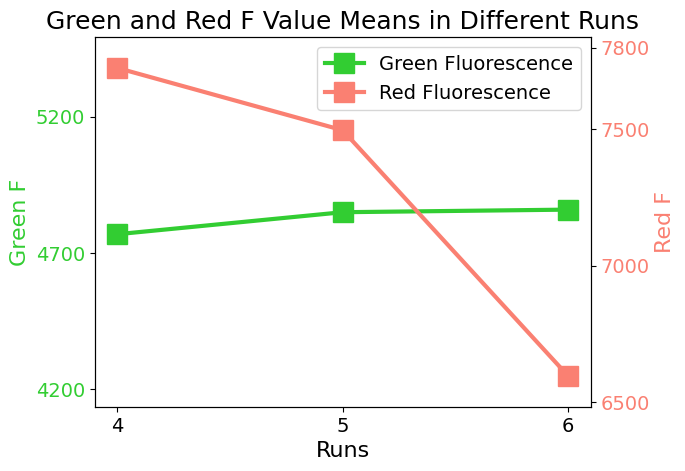

std of each run of green:
run index:0 -- std: 2471.520586253009
run index:1 -- std: 2292.4558607230865
run index:2 -- std: 2315.210504781361
std of each run of red:
run index:0 -- std: 1380.0201668394432
run index:1 -- std: 956.2147989536907
run index:2 -- std: 808.5855067605634


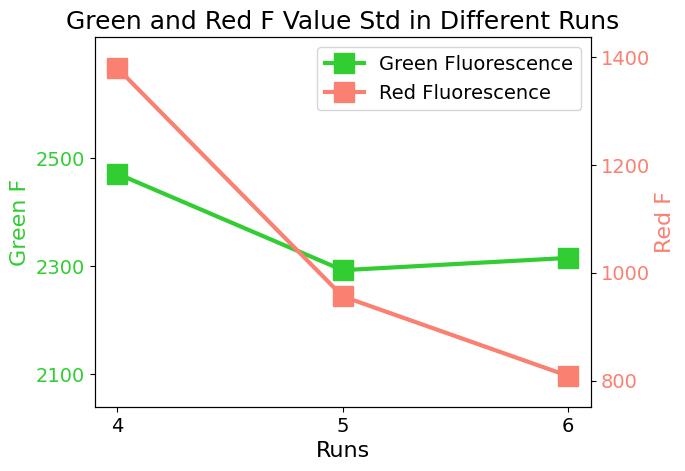

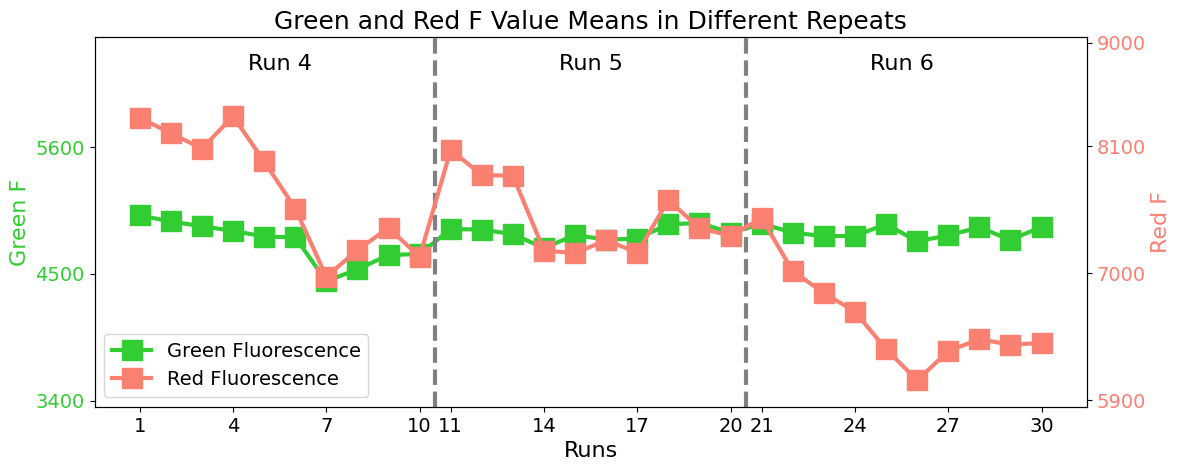

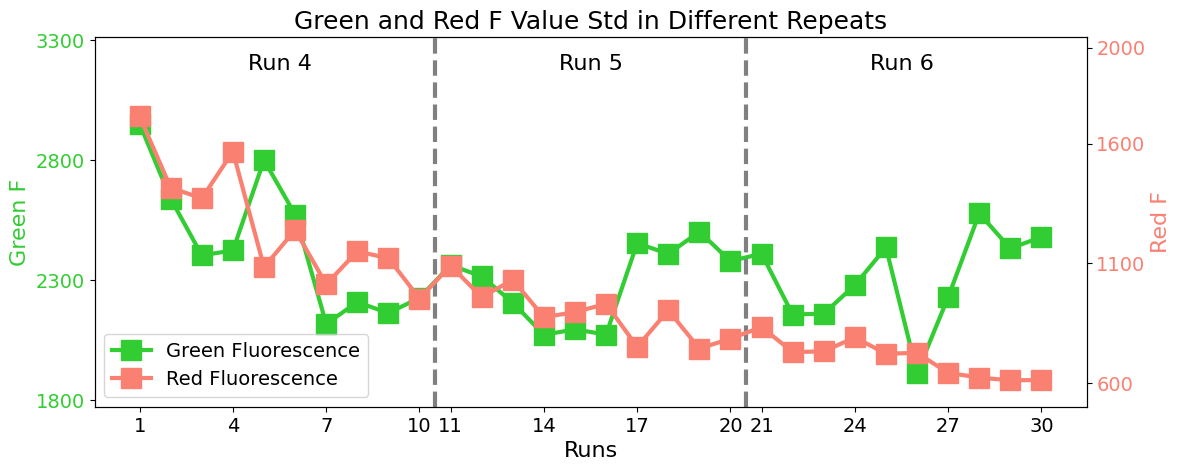

In [ ]:
### mean each run

print("mean of each run of green:")
green_mean_run = []
for run_ in range(len(run_num)):
    mean_ = np.mean(green_signal_traces[run_,:,:])
    green_mean_run.append(mean_)
    print(f"run index:{run_} -- mean: {mean_}")

print("mean of each run of red:")
red_mean_run = []
for run_ in range(len(run_num)):
    mean_ = np.mean(red_signal_traces[run_,:,:])
    red_mean_run.append(mean_)
    print(f"run index:{run_} -- mean: {mean_}")

# plot figure
x = range(len(run_num))
x_custom = [run_ for run_ in run_num]
y1 = green_mean_run
y2 = red_mean_run

fig, ax1 = plt.subplots(figsize=(6.4, 4.8)) # [6.4, 4.8] is deault size, same as fig, ax1 = plt.subplots()

green_line, = ax1.plot(x, y1, 's-', color='limegreen', label='Green Fluorescence', markersize=14, linewidth=3)
ax1.set_xlabel('Runs', fontsize=16)
ax1.set_ylabel('Green F', color='limegreen', fontsize=16)
ax1.tick_params(axis='y', labelcolor='limegreen', labelsize=14)

# set custome x axis labels
ax1.set_xticks(x)
ax1.set_xticklabels(x_custom)
ax1.tick_params(axis='x', labelsize=14)

ax2 = ax1.twinx()

red_line, = ax2.plot(x, y2, 's-', color='salmon', label='Red Fluorescence', markersize=14, linewidth=3)
ax2.set_ylabel('Red F', color='salmon', fontsize=16)
ax2.tick_params(axis='y', labelcolor='salmon', labelsize=14)

# set two y axes with same value for unit length
span = max((max(y1) - min(y1), max(y2) - min(y2)))
average_1 = (max(y1) + min(y1)) / 2
average_2 = (max(y2) + min(y2)) / 2
min_y1, max_y1 = average_1 - 0.6*span, average_1 + 0.6*span
min_y2, max_y2 = average_2 - 0.6*span, average_2 + 0.6*span
ax1.set_ylim(min_y1, max_y1)
ax2.set_ylim(min_y2, max_y2)
# make ticks sparse
min_y1_, max_y1_ = np.ceil(min_y1 / 100) * 100, np.floor(max_y1 / 100) * 100
min_y2_, max_y2_ = np.ceil(min_y2 / 100) * 100, np.floor(max_y2 / 100) * 100
# here use ceil for min and floor for ceil is to gurantee that the range used in
# set_yticks is within the range of set_ylim, otherwise a new range of the axis
# will consider both set_yticks and set_ylim and give the union of them.
unit_1 = np.ceil((max_y1_ - min_y1_) / 3 / 100) * 100 # 3 means only 3+1 ticks
unit_2 = np.ceil((max_y2_ - min_y2_) / 3 / 100) * 100
unit_unified = max(unit_1, unit_2)
if min_y1_ != max_y1_:
    if np.arange(min_y1_, max_y1_, step=unit_unified)[-1] > max(y1):
        sparse_y_ticks_1 = np.arange(min_y1_, max_y1_, step=unit_unified)
    else:
        sparse_y_ticks_1 = np.append(np.arange(min_y1_, max_y1_, step=unit_unified), max_y1_)
else:
    sparse_y_ticks_1 = np.array([int(min(y1)), int(max(y1))])
if min_y2_ != max_y2_:
    if np.arange(min_y2_, max_y2_, step=unit_unified)[-1] > max(y2):
        sparse_y_ticks_2 = np.arange(min_y2_, max_y2_, step=unit_unified)
    else:
        sparse_y_ticks_2 = np.append(np.arange(min_y2_, max_y2_, step=unit_unified), max_y2_)
else:
    sparse_y_ticks_2 = np.array([int(min(y2)), int(max(y2))])
ax1.set_yticks(sparse_y_ticks_1)
ax2.set_yticks(sparse_y_ticks_2)

# put two legends together
lines = [green_line, red_line]
labels = [line.get_label() for line in lines]
ax2.legend(lines, labels, fontsize=14, facecolor='none')

plt.title("Green and Red F Value Means in Different Runs", fontsize=18)

plt.show()


### std each run

print("std of each run of green:")
green_std_run = []
for run_ in range(len(run_num)):
    std_ = np.std(green_signal_traces[run_,:,:])
    green_std_run.append(std_)
    print(f"run index:{run_} -- std: {std_}")

print("std of each run of red:")
red_std_run = []
for run_ in range(len(run_num)):
    std_ = np.std(red_signal_traces[run_,:,:])
    red_std_run.append(std_)
    print(f"run index:{run_} -- std: {std_}")

# plot figure
x = range(len(run_num))
x_custom = [run_ for run_ in run_num]
y1 = green_std_run
y2 = red_std_run

fig, ax1 = plt.subplots(figsize=(6.4, 4.8))

green_line, = ax1.plot(x, y1, 's-', color='limegreen', label='Green Fluorescence', markersize=14, linewidth=3)
ax1.set_xlabel('Runs', fontsize=16)
ax1.set_ylabel('Green F', color='limegreen', fontsize=16)
ax1.tick_params(axis='y', labelcolor='limegreen', labelsize=14)

# set custome x axis labels
ax1.set_xticks(x)
ax1.set_xticklabels(x_custom)
ax1.tick_params(axis='x', labelsize=14)

ax2 = ax1.twinx()

red_line, = ax2.plot(x, y2, 's-', color='salmon', label='Red Fluorescence', markersize=14, linewidth=3)
ax2.set_ylabel('Red F', color='salmon', fontsize=16)
ax2.tick_params(axis='y', labelcolor='salmon', labelsize=14)

# set two y axes with same value for unit length
span = max((max(y1) - min(y1), max(y2) - min(y2)))
average_1 = (max(y1) + min(y1)) / 2
average_2 = (max(y2) + min(y2)) / 2
min_y1, max_y1 = average_1 - 0.6*span, average_1 + 0.6*span
min_y2, max_y2 = average_2 - 0.6*span, average_2 + 0.6*span
ax1.set_ylim(min_y1, max_y1)
ax2.set_ylim(min_y2, max_y2)
# make ticks sparse
min_y1_, max_y1_ = np.ceil(min_y1 / 100) * 100, np.floor(max_y1 / 100) * 100
min_y2_, max_y2_ = np.ceil(min_y2 / 100) * 100, np.floor(max_y2 / 100) * 100
# here use ceil for min and floor for ceil is to gurantee that the range used in
# set_yticks is within the range of set_ylim, otherwise a new range of the axis
# will consider both set_yticks and set_ylim and give the union of them.
unit_1 = np.ceil((max_y1_ - min_y1_) / 3 / 100) * 100 # 3 means only 3+1 ticks
unit_2 = np.ceil((max_y2_ - min_y2_) / 3 / 100) * 100
unit_unified = max(unit_1, unit_2)
if min_y1_ != max_y1_:
    if np.arange(min_y1_, max_y1_, step=unit_unified)[-1] > max(y1):
        sparse_y_ticks_1 = np.arange(min_y1_, max_y1_, step=unit_unified)
    else:
        sparse_y_ticks_1 = np.append(np.arange(min_y1_, max_y1_, step=unit_unified), max_y1_)
else:
    sparse_y_ticks_1 = np.array([int(min(y1)), int(max(y1))])
if min_y2_ != max_y2_:
    if np.arange(min_y2_, max_y2_, step=unit_unified)[-1] > max(y2):
        sparse_y_ticks_2 = np.arange(min_y2_, max_y2_, step=unit_unified)
    else:
        sparse_y_ticks_2 = np.append(np.arange(min_y2_, max_y2_, step=unit_unified), max_y2_)
else:
    sparse_y_ticks_2 = np.array([int(min(y2)), int(max(y2))])
ax1.set_yticks(sparse_y_ticks_1)
ax2.set_yticks(sparse_y_ticks_2)

# put two legends together
lines = [green_line, red_line]
labels = [line.get_label() for line in lines]
ax2.legend(lines, labels, fontsize=14, facecolor='none')

plt.title("Green and Red F Value Std in Different Runs", fontsize=18)

plt.show()


### mean each repeat

# print("mean of each repeat of green:")
repeat_num = 10 # 10 repeats per run
repeat_len = int(green_signal_traces.shape[2]/repeat_num)
green_mean_repeat = []
for run_ in range(len(run_num)):
    for i in range(repeat_num):
        mean_ = np.mean(green_signal_traces[run_,:,i*repeat_len:(i+1)*repeat_len])
        green_mean_repeat.append(mean_)
        # print(f"run index:{run_} repeat index:{i} -- mean: {mean_}")

# print("mean of each repeat of red:")
red_mean_repeat = []
for run_ in range(len(run_num)):
    for i in range(repeat_num):
        mean_ = np.mean(red_signal_traces[run_,:,i*repeat_len:(i+1)*repeat_len])
        red_mean_repeat.append(mean_)
        # print(f"run index:{run_} repeat index:{i} -- mean: {mean_}")

# plot figure
x = range(1, repeat_num * len(run_num) + 1)
y1 = green_mean_repeat
y2 = red_mean_repeat

fig, ax1 = plt.subplots(figsize=(6.4*2, 4.8))

green_line, = ax1.plot(x, y1, 's-', color='limegreen', label='Green Fluorescence', markersize=14, linewidth=3)
ax1.set_xlabel('Runs', fontsize=16)
ax1.set_ylabel('Green F', color='limegreen', fontsize=16)
ax1.tick_params(axis='y', labelcolor='limegreen', labelsize=14)

# set custome x axis labels
ax1.set_xticks(x)
if len(x) == 30 and len(run_num) == 3: # ste a better xticks for the common case
    ax1.set_xticks([1,4,7,10,11,14,17,20,21,24,27,30])
ax1.tick_params(axis='x', labelsize=14)

ax2 = ax1.twinx()

red_line, = ax2.plot(x, y2, 's-', color='salmon', label='Red Fluorescence', markersize=14, linewidth=3)
ax2.set_ylabel('Red F', color='salmon', fontsize=16)
ax2.tick_params(axis='y', labelcolor='salmon', labelsize=14)

# set two y axes with same value for unit length
span = max((max(y1) - min(y1), max(y2) - min(y2)))
average_1 = (max(y1) + min(y1)) / 2
average_2 = (max(y2) + min(y2)) / 2
min_y1, max_y1 = average_1 - 0.6*span, average_1 + 0.8*span
min_y2, max_y2 = average_2 - 0.6*span, average_2 + 0.8*span
ax1.set_ylim(min_y1, max_y1)
ax2.set_ylim(min_y2, max_y2)
# make ticks sparse
min_y1_, max_y1_ = np.ceil(min_y1 / 100) * 100, np.floor(max_y1 / 100) * 100
min_y2_, max_y2_ = np.ceil(min_y2 / 100) * 100, np.floor(max_y2 / 100) * 100
# here use ceil for min and floor for ceil is to gurantee that the range used in
# set_yticks is within the range of set_ylim, otherwise a new range of the axis
# will consider both set_yticks and set_ylim and give the union of them.
unit_1 = np.ceil((max_y1_ - min_y1_) / 3 / 100) * 100 # 3 means only 3+1 ticks
unit_2 = np.ceil((max_y2_ - min_y2_) / 3 / 100) * 100
unit_unified = max(unit_1, unit_2)
if min_y1_ != max_y1_:
    if np.arange(min_y1_, max_y1_, step=unit_unified)[-1] > max(y1):
        sparse_y_ticks_1 = np.arange(min_y1_, max_y1_, step=unit_unified)
    else:
        sparse_y_ticks_1 = np.append(np.arange(min_y1_, max_y1_, step=unit_unified), max_y1_)
else:
    sparse_y_ticks_1 = np.array([int(min(y1)), int(max(y1))])
if min_y2_ != max_y2_:
    if np.arange(min_y2_, max_y2_, step=unit_unified)[-1] > max(y2):
        sparse_y_ticks_2 = np.arange(min_y2_, max_y2_, step=unit_unified)
    else:
        sparse_y_ticks_2 = np.append(np.arange(min_y2_, max_y2_, step=unit_unified), max_y2_)
else:
    sparse_y_ticks_2 = np.array([int(min(y2)), int(max(y2))])
ax1.set_yticks(sparse_y_ticks_1)
ax2.set_yticks(sparse_y_ticks_2)

# add separating dash lines and add run names
for i, run_ in enumerate(run_num):
    if i < len(run_num) - 1:
        ax1.axvline(x=repeat_num*(i+1)+0.5, color='gray', linestyle='--', linewidth=3)
    ax1.text(repeat_num*(i+0.5)+0.5, average_1+0.7*span, 'Run ' + run_, ha='center', va='center', fontsize=16)

# put two legends together
lines = [green_line, red_line]
labels = [line.get_label() for line in lines]
ax2.legend(lines, labels, loc = 'lower left', fontsize=14, facecolor='none')

plt.title("Green and Red F Value Means in Different Repeats", fontsize=18)

plt.show()


### std each repeat

# print("std of each repeat of green:")
repeat_num = 10 # 10 repeats per run
repeat_len = int(green_signal_traces.shape[2]/repeat_num)
green_std_repeat = []
for run_ in range(len(run_num)):
    for i in range(repeat_num):
        std_ = np.std(green_signal_traces[run_,:,i*repeat_len:(i+1)*repeat_len])
        green_std_repeat.append(std_)
        # print(f"run index:{run_} repeat index:{i} -- std: {std_}")

# print("std of each repeat of red:")
red_std_repeat = []
for run_ in range(len(run_num)):
    for i in range(repeat_num):
        std_ = np.std(red_signal_traces[run_,:,i*repeat_len:(i+1)*repeat_len])
        red_std_repeat.append(std_)
        # print(f"run index:{run_} repeat index:{i} -- std: {std_}")

# plot figure
x = range(1, repeat_num * len(run_num) + 1)
y1 = green_std_repeat
y2 = red_std_repeat

fig, ax1 = plt.subplots(figsize=(6.4*2, 4.8))

green_line, = ax1.plot(x, y1, 's-', color='limegreen', label='Green Fluorescence', markersize=14, linewidth=3)
ax1.set_xlabel('Runs', fontsize=16)
ax1.set_ylabel('Green F', color='limegreen', fontsize=16)
ax1.tick_params(axis='y', labelcolor='limegreen', labelsize=14)

# set custome x axis labels
ax1.set_xticks(x)
if len(x) == 30 and len(run_num) == 3: # ste a better xticks for the common case
    ax1.set_xticks([1,4,7,10,11,14,17,20,21,24,27,30])
ax1.tick_params(axis='x', labelsize=14)

ax2 = ax1.twinx()

red_line, = ax2.plot(x, y2, 's-', color='salmon', label='Red Fluorescence', markersize=14, linewidth=3)
ax2.set_ylabel('Red F', color='salmon', fontsize=16)
ax2.tick_params(axis='y', labelcolor='salmon', labelsize=14)

# set two y axes with same value for unit length
span = max((max(y1) - min(y1), max(y2) - min(y2)))
average_1 = (max(y1) + min(y1)) / 2
average_2 = (max(y2) + min(y2)) / 2
min_y1, max_y1 = average_1 - 0.6*span, average_1 + 0.8*span
min_y2, max_y2 = average_2 - 0.6*span, average_2 + 0.8*span
ax1.set_ylim(min_y1, max_y1)
ax2.set_ylim(min_y2, max_y2)
# make ticks sparse
min_y1_, max_y1_ = np.ceil(min_y1 / 100) * 100, np.floor(max_y1 / 100) * 100
min_y2_, max_y2_ = np.ceil(min_y2 / 100) * 100, np.floor(max_y2 / 100) * 100
# here use ceil for min and floor for ceil is to gurantee that the range used in
# set_yticks is within the range of set_ylim, otherwise a new range of the axis
# will consider both set_yticks and set_ylim and give the union of them.
unit_1 = np.ceil((max_y1_ - min_y1_) / 3 / 100) * 100 # 3 means only 3+1 ticks
unit_2 = np.ceil((max_y2_ - min_y2_) / 3 / 100) * 100
unit_unified = max(unit_1, unit_2)
if np.arange(min_y1_, max_y1_, step=unit_unified)[-1] > max(y1):
    sparse_y_ticks_1 = np.arange(min_y1_, max_y1_, step=unit_unified)
else:
    sparse_y_ticks_1 = np.append(np.arange(min_y1_, max_y1_, step=unit_unified), max_y1_)
if np.arange(min_y2_, max_y2_, step=unit_unified)[-1] > max(y2):
    sparse_y_ticks_2 = np.arange(min_y2_, max_y2_, step=unit_unified)
else:
    sparse_y_ticks_2 = np.append(np.arange(min_y2_, max_y2_, step=unit_unified), max_y2_)
ax1.set_yticks(sparse_y_ticks_1)
ax2.set_yticks(sparse_y_ticks_2)

# add separating dash lines and add run names
for i, run_ in enumerate(run_num):
    if i < len(run_num) - 1:
        ax1.axvline(x=repeat_num*(i+1)+0.5, color='gray', linestyle='--', linewidth=3)
    ax1.text(repeat_num*(i+0.5)+0.5, average_1+0.7*span, 'Run ' + run_, ha='center', va='center', fontsize=16)

# put two legends together
lines = [green_line, red_line]
labels = [line.get_label() for line in lines]
ax2.legend(lines, labels, loc = 'lower left', fontsize=14, facecolor='none')

plt.title("Green and Red F Value Std in Different Repeats", fontsize=18)

plt.show()


## for later use in decay restoration
green_mean_repeat_list_raw = green_mean_repeat.copy()
red_mean_repeat_list_raw = red_mean_repeat.copy()

green_mean_run_list_raw = green_mean_run.copy()
red_mean_run_list_raw = red_mean_run.copy()

green_std_repeat_list_raw = green_std_repeat.copy()
red_std_repeat_list_raw = red_std_repeat.copy()

green_std_run_list_raw = green_std_run.copy()
red_std_run_list_raw = red_std_run.copy()

# std is not used cuz after mean restoration we need to recalculate std

(3, 281, 32500)
(3, 1, 32500)


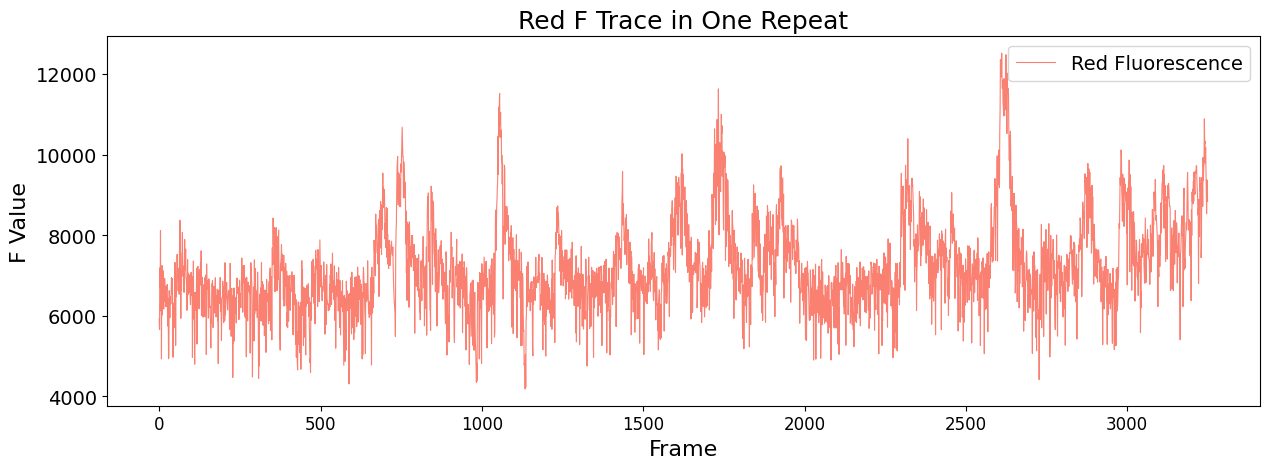

In [ ]:
print(green_signal_traces.shape)
print(red_signal_traces.shape)

## plot a signal trace in a repeat
# data_to_plot = green_signal_traces[0, 0, :int(32500/10)]
data_to_plot = red_signal_traces[0, 0, 7*int(32500/10):8*int(32500/10)]

plt.figure(figsize=(6.4*2, 4.8))

plt.plot(data_to_plot, color='salmon', linewidth=0.8, label='Red Fluorescence')
plt.xlabel('Frame', fontsize=16)
plt.ylabel('F Value', fontsize=16)
plt.tick_params(axis='y', labelsize=14)
plt.tick_params(axis='x', labelsize=12)

# Set title and legend
plt.title('Red F Trace in One Repeat', fontsize=18)
plt.legend(fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

#### Decay Restoration

##### Restore mean

exponent in the exp func is -0.010783603500536884
recover_factor.shape: (10,)
exponent in the exp func is -0.000948715789404894
recover_factor.shape: (10,)
exponent in the exp func is -0.002531868021751511
recover_factor.shape: (10,)
exponent in the exp func is -0.01828981722566003
recover_factor.shape: (10,)
exponent in the exp func is -0.014440988974562374
recover_factor.shape: (10,)
exponent in the exp func is -0.025219339251656574
recover_factor.shape: (10,)
mean of each run of green:
run index:0 -- mean: 4768.683464737658
run index:1 -- mean: 4753.258247566736
run index:2 -- mean: 4752.06493607121
mean of each run of red:
run index:0 -- mean: 7757.8364709113275
run index:1 -- mean: 7662.009964786073
run index:2 -- mean: 7627.070909693692


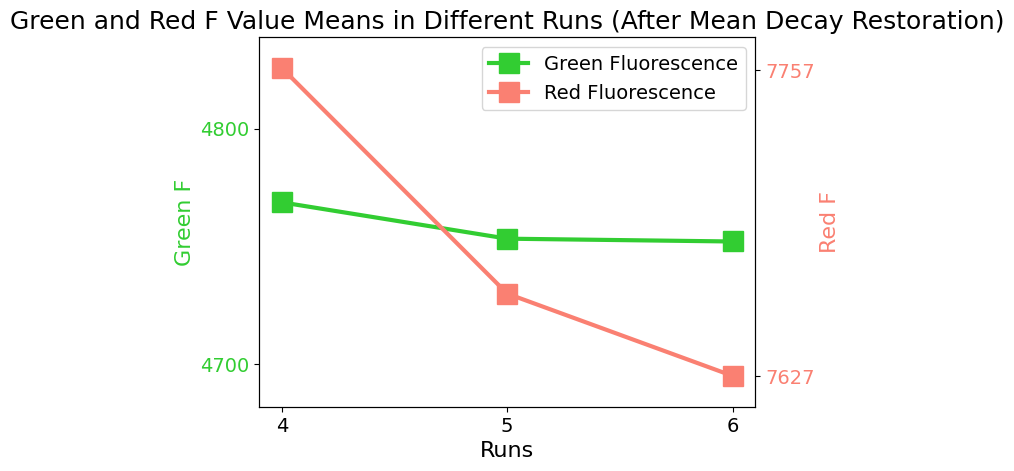

std of each run of green:
run index:0 -- std: 2479.832527553653
run index:1 -- std: 2252.471168356745
run index:2 -- std: 2269.7020053602814
std of each run of red:
run index:0 -- std: 1459.531715697618
run index:1 -- std: 1051.0656887284629
run index:2 -- std: 995.5958180718643


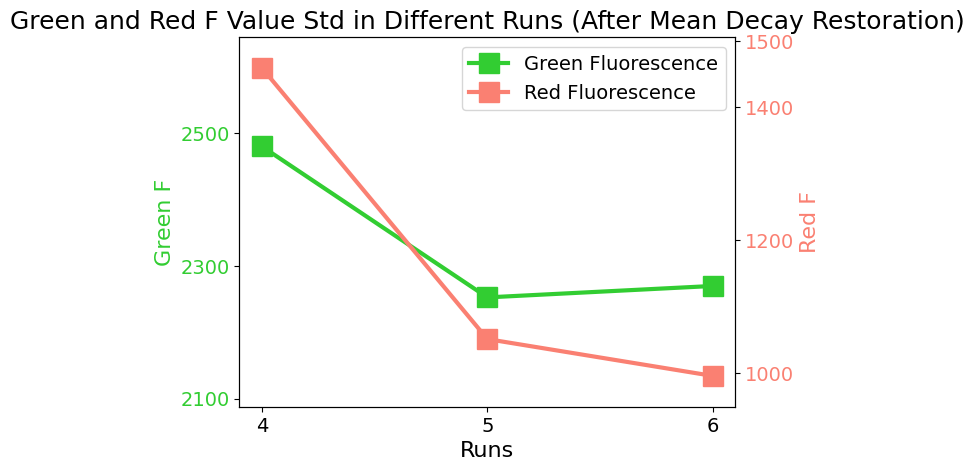

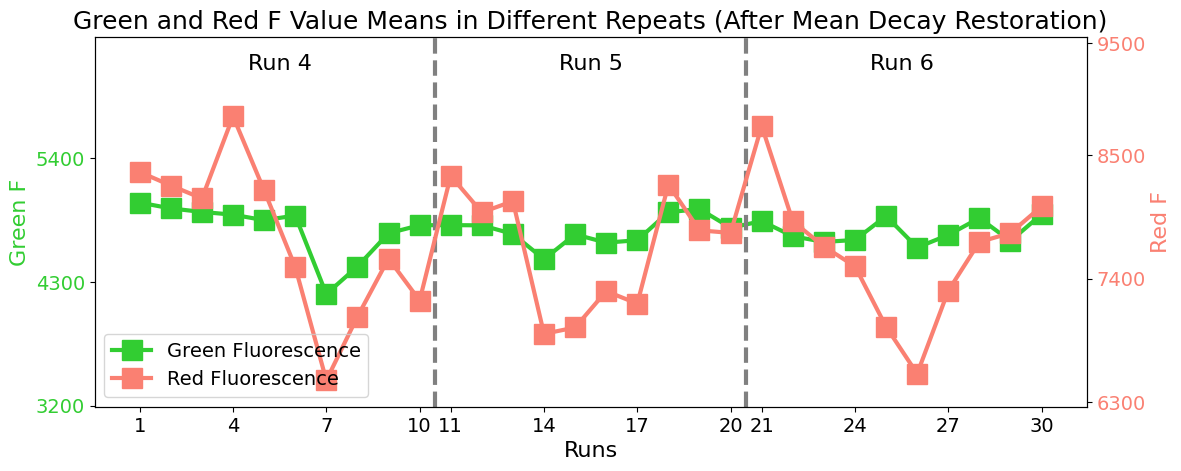

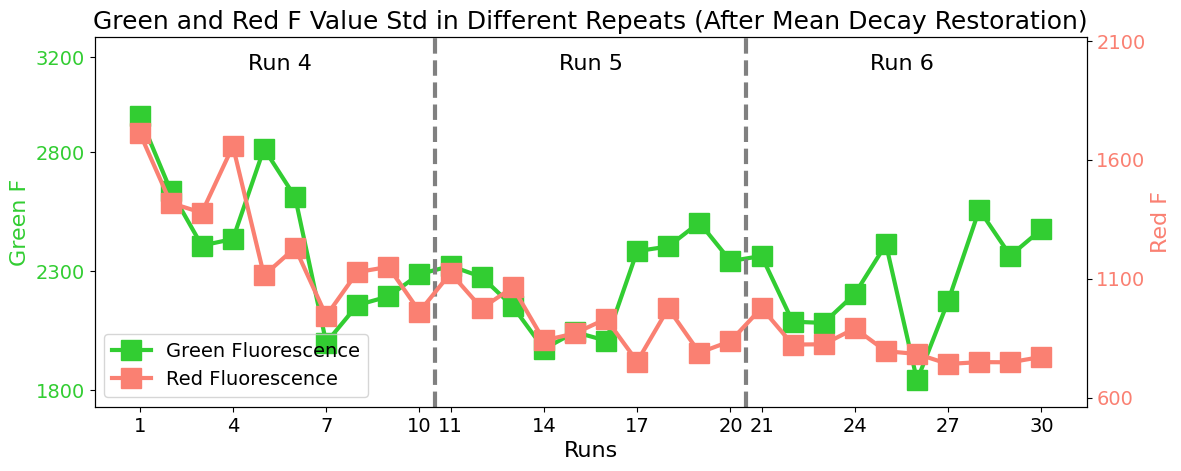

In [ ]:
green_mean_repeat = np.array(green_mean_repeat_list_raw)
red_mean_repeat = np.array(red_mean_repeat_list_raw)

green_mean_run = np.array(green_mean_run_list_raw)
red_mean_run = np.array(red_mean_run_list_raw)

# print(green_mean_repeat.shape)
# print(red_mean_repeat.shape)
# print(green_mean_run.shape)
# print(red_mean_run.shape)

x_mean_repeat_restored_list = []
x_mean_repeat_restored_coefficients_list = []
for x_mean_repeat, x_mean_run in [(green_mean_repeat, green_mean_run), (red_mean_repeat, red_mean_run)]:
    # Define the exponential function for regression of decay
    def exponential_func(x, lambda_):
        return np.exp(lambda_ * x)

    how_many_run = 3
    repeat_num_per_run = int(x_mean_repeat.shape[0]/how_many_run)

    x_mean_repeat_restored = x_mean_repeat.copy()
    x_mean_repeat_restored_coefficients = x_mean_repeat.copy()
    for i in range(how_many_run):
        y = x_mean_repeat[i*repeat_num_per_run:(i+1)*repeat_num_per_run].copy()
        multiplier = 1 / y[0]
        y = y * multiplier
        x = np.arange(len(y))
        popt, pcov = curve_fit(exponential_func, x, y)
        lambda_ = popt[0]
        print(f"exponent in the exp func is {lambda_}")
        y_fit = exponential_func(x, lambda_)

        recover_factor = y / y_fit
        print("recover_factor.shape:", recover_factor.shape)
        # print(recover_factor)

        x_mean_repeat_restored[i*repeat_num_per_run:(i+1)*repeat_num_per_run] *= recover_factor * x_mean_run[0] / x_mean_run[i]
        x_mean_repeat_restored_coefficients[i*repeat_num_per_run:(i+1)*repeat_num_per_run] = recover_factor * x_mean_run[0] / x_mean_run[i]

    x_mean_repeat_restored_list.append(x_mean_repeat_restored)
    x_mean_repeat_restored_coefficients_list.append(x_mean_repeat_restored_coefficients)

green_mean_repeat_restored, red_mean_repeat_restored = x_mean_repeat_restored_list
green_mean_repeat_restored_coefficients, red_mean_repeat_restored_coefficients = x_mean_repeat_restored_coefficients_list

## generate green_signal_traces_mean_restored and red_signal_traces_mean_restored
green_signal_traces_mean_restored = green_signal_traces.copy()
red_signal_traces_mean_restored = red_signal_traces.copy()

repeat_num = 10 # 10 repeats per run
repeat_len = int(green_signal_traces.shape[2]/repeat_num)

for run_ in range(len(run_num)):
    for i in range(repeat_num):
        green_signal_traces_mean_restored[run_,:,i*repeat_len:(i+1)*repeat_len] *= green_mean_repeat_restored_coefficients[run_*repeat_num+i]

for run_ in range(len(run_num)):
    for i in range(repeat_num):
        red_signal_traces_mean_restored[run_,:,i*repeat_len:(i+1)*repeat_len] *= red_mean_repeat_restored_coefficients[run_*repeat_num+i]


### mean each run

print("mean of each run of green:")
green_mean_run = []
for run_ in range(len(run_num)):
    mean_ = np.mean(green_signal_traces_mean_restored[run_,:,:])
    green_mean_run.append(mean_)
    print(f"run index:{run_} -- mean: {mean_}")

print("mean of each run of red:")
red_mean_run = []
for run_ in range(len(run_num)):
    mean_ = np.mean(red_signal_traces_mean_restored[run_,:,:])
    red_mean_run.append(mean_)
    print(f"run index:{run_} -- mean: {mean_}")

# plot figure
x = range(len(run_num))
x_custom = [run_ for run_ in run_num]
y1 = green_mean_run
y2 = red_mean_run

fig, ax1 = plt.subplots(figsize=(6.4, 4.8)) # [6.4, 4.8] is deault size, same as fig, ax1 = plt.subplots()

green_line, = ax1.plot(x, y1, 's-', color='limegreen', label='Green Fluorescence', markersize=14, linewidth=3)
ax1.set_xlabel('Runs', fontsize=16)
ax1.set_ylabel('Green F', color='limegreen', fontsize=16)
ax1.tick_params(axis='y', labelcolor='limegreen', labelsize=14)

# set custome x axis labels
ax1.set_xticks(x)
ax1.set_xticklabels(x_custom)
ax1.tick_params(axis='x', labelsize=14)

ax2 = ax1.twinx()

red_line, = ax2.plot(x, y2, 's-', color='salmon', label='Red Fluorescence', markersize=14, linewidth=3)
ax2.set_ylabel('Red F', color='salmon', fontsize=16)
ax2.tick_params(axis='y', labelcolor='salmon', labelsize=14)

# set two y axes with same value for unit length
span = max((max(y1) - min(y1), max(y2) - min(y2)))
average_1 = (max(y1) + min(y1)) / 2
average_2 = (max(y2) + min(y2)) / 2
min_y1, max_y1 = average_1 - 0.6*span, average_1 + 0.6*span
min_y2, max_y2 = average_2 - 0.6*span, average_2 + 0.6*span
ax1.set_ylim(min_y1, max_y1)
ax2.set_ylim(min_y2, max_y2)
# make ticks sparse
min_y1_, max_y1_ = np.ceil(min_y1 / 100) * 100, np.floor(max_y1 / 100) * 100
min_y2_, max_y2_ = np.ceil(min_y2 / 100) * 100, np.floor(max_y2 / 100) * 100
# here use ceil for min and floor for ceil is to gurantee that the range used in
# set_yticks is within the range of set_ylim, otherwise a new range of the axis
# will consider both set_yticks and set_ylim and give the union of them.
unit_1 = np.ceil((max_y1_ - min_y1_) / 3 / 100) * 100 # 3 means only 3+1 ticks
unit_2 = np.ceil((max_y2_ - min_y2_) / 3 / 100) * 100
unit_unified = max(unit_1, unit_2)
if min_y1_ != max_y1_:
    if np.arange(min_y1_, max_y1_, step=unit_unified)[-1] > max(y1):
        sparse_y_ticks_1 = np.arange(min_y1_, max_y1_, step=unit_unified)
    else:
        sparse_y_ticks_1 = np.append(np.arange(min_y1_, max_y1_, step=unit_unified), max_y1_)
else:
    sparse_y_ticks_1 = np.array([int(min(y1)), int(max(y1))])
if min_y2_ != max_y2_:
    if np.arange(min_y2_, max_y2_, step=unit_unified)[-1] > max(y2):
        sparse_y_ticks_2 = np.arange(min_y2_, max_y2_, step=unit_unified)
    else:
        sparse_y_ticks_2 = np.append(np.arange(min_y2_, max_y2_, step=unit_unified), max_y2_)
else:
    sparse_y_ticks_2 = np.array([int(min(y2)), int(max(y2))])
ax1.set_yticks(sparse_y_ticks_1)
ax2.set_yticks(sparse_y_ticks_2)

# put two legends together
lines = [green_line, red_line]
labels = [line.get_label() for line in lines]
ax2.legend(lines, labels, fontsize=14, facecolor='none')

plt.title("Green and Red F Value Means in Different Runs (After Mean Decay Restoration)", fontsize=18)

plt.show()


### std each run

print("std of each run of green:")
green_std_run = []
for run_ in range(len(run_num)):
    std_ = np.std(green_signal_traces_mean_restored[run_,:,:])
    green_std_run.append(std_)
    print(f"run index:{run_} -- std: {std_}")

print("std of each run of red:")
red_std_run = []
for run_ in range(len(run_num)):
    std_ = np.std(red_signal_traces_mean_restored[run_,:,:])
    red_std_run.append(std_)
    print(f"run index:{run_} -- std: {std_}")

# plot figure
x = range(len(run_num))
x_custom = [run_ for run_ in run_num]
y1 = green_std_run
y2 = red_std_run

fig, ax1 = plt.subplots(figsize=(6.4, 4.8))

green_line, = ax1.plot(x, y1, 's-', color='limegreen', label='Green Fluorescence', markersize=14, linewidth=3)
ax1.set_xlabel('Runs', fontsize=16)
ax1.set_ylabel('Green F', color='limegreen', fontsize=16)
ax1.tick_params(axis='y', labelcolor='limegreen', labelsize=14)

# set custome x axis labels
ax1.set_xticks(x)
ax1.set_xticklabels(x_custom)
ax1.tick_params(axis='x', labelsize=14)

ax2 = ax1.twinx()

red_line, = ax2.plot(x, y2, 's-', color='salmon', label='Red Fluorescence', markersize=14, linewidth=3)
ax2.set_ylabel('Red F', color='salmon', fontsize=16)
ax2.tick_params(axis='y', labelcolor='salmon', labelsize=14)

# set two y axes with same value for unit length
span = max((max(y1) - min(y1), max(y2) - min(y2)))
average_1 = (max(y1) + min(y1)) / 2
average_2 = (max(y2) + min(y2)) / 2
min_y1, max_y1 = average_1 - 0.6*span, average_1 + 0.6*span
min_y2, max_y2 = average_2 - 0.6*span, average_2 + 0.6*span
ax1.set_ylim(min_y1, max_y1)
ax2.set_ylim(min_y2, max_y2)
# make ticks sparse
min_y1_, max_y1_ = np.ceil(min_y1 / 100) * 100, np.floor(max_y1 / 100) * 100
min_y2_, max_y2_ = np.ceil(min_y2 / 100) * 100, np.floor(max_y2 / 100) * 100
# here use ceil for min and floor for ceil is to gurantee that the range used in
# set_yticks is within the range of set_ylim, otherwise a new range of the axis
# will consider both set_yticks and set_ylim and give the union of them.
unit_1 = np.ceil((max_y1_ - min_y1_) / 3 / 100) * 100 # 3 means only 3+1 ticks
unit_2 = np.ceil((max_y2_ - min_y2_) / 3 / 100) * 100
unit_unified = max(unit_1, unit_2)
if min_y1_ != max_y1_:
    if np.arange(min_y1_, max_y1_, step=unit_unified)[-1] > max(y1):
        sparse_y_ticks_1 = np.arange(min_y1_, max_y1_, step=unit_unified)
    else:
        sparse_y_ticks_1 = np.append(np.arange(min_y1_, max_y1_, step=unit_unified), max_y1_)
else:
    sparse_y_ticks_1 = np.array([int(min(y1)), int(max(y1))])
if min_y2_ != max_y2_:
    if np.arange(min_y2_, max_y2_, step=unit_unified)[-1] > max(y2):
        sparse_y_ticks_2 = np.arange(min_y2_, max_y2_, step=unit_unified)
    else:
        sparse_y_ticks_2 = np.append(np.arange(min_y2_, max_y2_, step=unit_unified), max_y2_)
else:
    sparse_y_ticks_2 = np.array([int(min(y2)), int(max(y2))])
ax1.set_yticks(sparse_y_ticks_1)
ax2.set_yticks(sparse_y_ticks_2)

# put two legends together
lines = [green_line, red_line]
labels = [line.get_label() for line in lines]
ax2.legend(lines, labels, fontsize=14, facecolor='none')

plt.title("Green and Red F Value Std in Different Runs (After Mean Decay Restoration)", fontsize=18)

plt.show()


### mean each repeat

# print("mean of each repeat of green:")
repeat_num = 10 # 10 repeats per run
repeat_len = int(green_signal_traces_mean_restored.shape[2]/repeat_num)
green_mean_repeat = []
for run_ in range(len(run_num)):
    for i in range(repeat_num):
        mean_ = np.mean(green_signal_traces_mean_restored[run_,:,i*repeat_len:(i+1)*repeat_len])
        green_mean_repeat.append(mean_)
        # print(f"run index:{run_} repeat index:{i} -- mean: {mean_}")

# print("mean of each repeat of red:")
red_mean_repeat = []
for run_ in range(len(run_num)):
    for i in range(repeat_num):
        mean_ = np.mean(red_signal_traces_mean_restored[run_,:,i*repeat_len:(i+1)*repeat_len])
        red_mean_repeat.append(mean_)
        # print(f"run index:{run_} repeat index:{i} -- mean: {mean_}")

# plot figure
x = range(1, repeat_num * len(run_num) + 1)
y1 = green_mean_repeat
y2 = red_mean_repeat

fig, ax1 = plt.subplots(figsize=(6.4*2, 4.8))

green_line, = ax1.plot(x, y1, 's-', color='limegreen', label='Green Fluorescence', markersize=14, linewidth=3)
ax1.set_xlabel('Runs', fontsize=16)
ax1.set_ylabel('Green F', color='limegreen', fontsize=16)
ax1.tick_params(axis='y', labelcolor='limegreen', labelsize=14)

# set custome x axis labels
ax1.set_xticks(x)
if len(x) == 30 and len(run_num) == 3: # ste a better xticks for the common case
    ax1.set_xticks([1,4,7,10,11,14,17,20,21,24,27,30])
ax1.tick_params(axis='x', labelsize=14)

ax2 = ax1.twinx()

red_line, = ax2.plot(x, y2, 's-', color='salmon', label='Red Fluorescence', markersize=14, linewidth=3)
ax2.set_ylabel('Red F', color='salmon', fontsize=16)
ax2.tick_params(axis='y', labelcolor='salmon', labelsize=14)

# set two y axes with same value for unit length
span = max((max(y1) - min(y1), max(y2) - min(y2)))
average_1 = (max(y1) + min(y1)) / 2
average_2 = (max(y2) + min(y2)) / 2
min_y1, max_y1 = average_1 - 0.6*span, average_1 + 0.8*span
min_y2, max_y2 = average_2 - 0.6*span, average_2 + 0.8*span
ax1.set_ylim(min_y1, max_y1)
ax2.set_ylim(min_y2, max_y2)
# make ticks sparse
min_y1_, max_y1_ = np.ceil(min_y1 / 100) * 100, np.floor(max_y1 / 100) * 100
min_y2_, max_y2_ = np.ceil(min_y2 / 100) * 100, np.floor(max_y2 / 100) * 100
# here use ceil for min and floor for ceil is to gurantee that the range used in
# set_yticks is within the range of set_ylim, otherwise a new range of the axis
# will consider both set_yticks and set_ylim and give the union of them.
unit_1 = np.ceil((max_y1_ - min_y1_) / 3 / 100) * 100 # 3 means only 3+1 ticks
unit_2 = np.ceil((max_y2_ - min_y2_) / 3 / 100) * 100
unit_unified = max(unit_1, unit_2)
if min_y1_ != max_y1_:
    if np.arange(min_y1_, max_y1_, step=unit_unified)[-1] > max(y1):
        sparse_y_ticks_1 = np.arange(min_y1_, max_y1_, step=unit_unified)
    else:
        sparse_y_ticks_1 = np.append(np.arange(min_y1_, max_y1_, step=unit_unified), max_y1_)
else:
    sparse_y_ticks_1 = np.array([int(min(y1)), int(max(y1))])
if min_y2_ != max_y2_:
    if np.arange(min_y2_, max_y2_, step=unit_unified)[-1] > max(y2):
        sparse_y_ticks_2 = np.arange(min_y2_, max_y2_, step=unit_unified)
    else:
        sparse_y_ticks_2 = np.append(np.arange(min_y2_, max_y2_, step=unit_unified), max_y2_)
else:
    sparse_y_ticks_2 = np.array([int(min(y2)), int(max(y2))])
ax1.set_yticks(sparse_y_ticks_1)
ax2.set_yticks(sparse_y_ticks_2)

# add separating dash lines and add run names
for i, run_ in enumerate(run_num):
    if i < len(run_num) - 1:
        ax1.axvline(x=repeat_num*(i+1)+0.5, color='gray', linestyle='--', linewidth=3)
    ax1.text(repeat_num*(i+0.5)+0.5, average_1+0.7*span, 'Run ' + run_, ha='center', va='center', fontsize=16)

# put two legends together
lines = [green_line, red_line]
labels = [line.get_label() for line in lines]
ax2.legend(lines, labels, loc = 'lower left', fontsize=14, facecolor='none')

plt.title("Green and Red F Value Means in Different Repeats (After Mean Decay Restoration)", fontsize=18)

plt.show()


### std each repeat

# print("std of each repeat of green:")
repeat_num = 10 # 10 repeats per run
repeat_len = int(green_signal_traces_mean_restored.shape[2]/repeat_num)
green_std_repeat = []
for run_ in range(len(run_num)):
    for i in range(repeat_num):
        std_ = np.std(green_signal_traces_mean_restored[run_,:,i*repeat_len:(i+1)*repeat_len])
        green_std_repeat.append(std_)
        # print(f"run index:{run_} repeat index:{i} -- std: {std_}")

# print("std of each repeat of red:")
red_std_repeat = []
for run_ in range(len(run_num)):
    for i in range(repeat_num):
        std_ = np.std(red_signal_traces_mean_restored[run_,:,i*repeat_len:(i+1)*repeat_len])
        red_std_repeat.append(std_)
        # print(f"run index:{run_} repeat index:{i} -- std: {std_}")

# plot figure
x = range(1, repeat_num * len(run_num) + 1)
y1 = green_std_repeat
y2 = red_std_repeat

fig, ax1 = plt.subplots(figsize=(6.4*2, 4.8))

green_line, = ax1.plot(x, y1, 's-', color='limegreen', label='Green Fluorescence', markersize=14, linewidth=3)
ax1.set_xlabel('Runs', fontsize=16)
ax1.set_ylabel('Green F', color='limegreen', fontsize=16)
ax1.tick_params(axis='y', labelcolor='limegreen', labelsize=14)

# set custome x axis labels
ax1.set_xticks(x)
if len(x) == 30 and len(run_num) == 3: # ste a better xticks for the common case
    ax1.set_xticks([1,4,7,10,11,14,17,20,21,24,27,30])
ax1.tick_params(axis='x', labelsize=14)

ax2 = ax1.twinx()

red_line, = ax2.plot(x, y2, 's-', color='salmon', label='Red Fluorescence', markersize=14, linewidth=3)
ax2.set_ylabel('Red F', color='salmon', fontsize=16)
ax2.tick_params(axis='y', labelcolor='salmon', labelsize=14)

# set two y axes with same value for unit length
span = max((max(y1) - min(y1), max(y2) - min(y2)))
average_1 = (max(y1) + min(y1)) / 2
average_2 = (max(y2) + min(y2)) / 2
min_y1, max_y1 = average_1 - 0.6*span, average_1 + 0.8*span
min_y2, max_y2 = average_2 - 0.6*span, average_2 + 0.8*span
ax1.set_ylim(min_y1, max_y1)
ax2.set_ylim(min_y2, max_y2)
# make ticks sparse
min_y1_, max_y1_ = np.ceil(min_y1 / 100) * 100, np.floor(max_y1 / 100) * 100
min_y2_, max_y2_ = np.ceil(min_y2 / 100) * 100, np.floor(max_y2 / 100) * 100
# here use ceil for min and floor for ceil is to gurantee that the range used in
# set_yticks is within the range of set_ylim, otherwise a new range of the axis
# will consider both set_yticks and set_ylim and give the union of them.
unit_1 = np.ceil((max_y1_ - min_y1_) / 3 / 100) * 100 # 3 means only 3+1 ticks
unit_2 = np.ceil((max_y2_ - min_y2_) / 3 / 100) * 100
unit_unified = max(unit_1, unit_2)
if min_y1_ != max_y1_:
    if np.arange(min_y1_, max_y1_, step=unit_unified)[-1] > max(y1):
        sparse_y_ticks_1 = np.arange(min_y1_, max_y1_, step=unit_unified)
    else:
        sparse_y_ticks_1 = np.append(np.arange(min_y1_, max_y1_, step=unit_unified), max_y1_)
else:
    sparse_y_ticks_1 = np.array([int(min(y1)), int(max(y1))])
if min_y2_ != max_y2_:
    if np.arange(min_y2_, max_y2_, step=unit_unified)[-1] > max(y2):
        sparse_y_ticks_2 = np.arange(min_y2_, max_y2_, step=unit_unified)
    else:
        sparse_y_ticks_2 = np.append(np.arange(min_y2_, max_y2_, step=unit_unified), max_y2_)
else:
    sparse_y_ticks_2 = np.array([int(min(y2)), int(max(y2))])
ax1.set_yticks(sparse_y_ticks_1)
ax2.set_yticks(sparse_y_ticks_2)

# add separating dash lines and add run names
for i, run_ in enumerate(run_num):
    if i < len(run_num) - 1:
        ax1.axvline(x=repeat_num*(i+1)+0.5, color='gray', linestyle='--', linewidth=3)
    ax1.text(repeat_num*(i+0.5)+0.5, average_1+0.7*span, 'Run ' + run_, ha='center', va='center', fontsize=16)

# put two legends together
lines = [green_line, red_line]
labels = [line.get_label() for line in lines]
ax2.legend(lines, labels, loc = 'lower left', fontsize=14, facecolor='none')

plt.title("Green and Red F Value Std in Different Repeats (After Mean Decay Restoration)", fontsize=18)

plt.show()

## store them to variables with new names
## and for later use in decay restoration
green_mean_repeat_list_after_mean_restored = green_mean_repeat.copy() # same as green_mean_repeat_restored
red_mean_repeat_list_after_mean_restored = red_mean_repeat.copy() # same as red_mean_repeat_restored

green_mean_run_list_after_mean_restored = green_mean_run.copy()
red_mean_run_list_after_mean_restored = red_mean_run.copy()

green_std_repeat_list_after_mean_restored = green_std_repeat.copy()
red_std_repeat_list_after_mean_restored = red_std_repeat.copy()

green_std_run_list_after_mean_restored = green_std_run.copy()
red_std_run_list_after_mean_restored = red_std_run.copy()

##### Restore std

In [ ]:
## convert to numpy form
green_mean_repeat = np.array(green_mean_repeat_list_after_mean_restored)
red_mean_repeat = np.array(red_mean_repeat_list_after_mean_restored)

green_mean_run = np.array(green_mean_run_list_after_mean_restored)
red_mean_run = np.array(red_mean_run_list_after_mean_restored)

green_std_repeat = np.array(green_std_repeat_list_after_mean_restored)
red_std_repeat = np.array(red_std_repeat_list_after_mean_restored)

green_std_run = np.array(green_std_run_list_after_mean_restored)
red_std_run = np.array(red_std_run_list_after_mean_restored)

# print(green_std_repeat, red_std_repeat, green_std_run, red_std_run)
# print(green_mean_repeat, red_mean_repeat, green_mean_run, red_mean_run)

In [ ]:
x_std_repeat_restored_list = []
x_std_repeat_restored_coefficients_list = []
for x_std_repeat, x_std_run in [(green_std_repeat, green_std_run), (red_std_repeat, red_std_run)]:
    # Define the exponential function for regression of decay
    def exponential_func(x, lambda_):
        return np.exp(lambda_ * x)

    how_many_run = 3
    repeat_num_per_run = int(x_std_repeat.shape[0]/how_many_run)

    x_std_repeat_restored = x_std_repeat.copy()
    x_std_repeat_restored_coefficients = x_std_repeat.copy()
    for i in range(how_many_run):
        y = x_std_repeat[i*repeat_num_per_run:(i+1)*repeat_num_per_run].copy()
        multiplier = 1 / y[0]
        y = y * multiplier
        x = np.arange(len(y))
        popt, pcov = curve_fit(exponential_func, x, y)
        lambda_ = popt[0]
        print(f"exponent in the exp func is {lambda_}")
        y_fit = exponential_func(x, lambda_)

        recover_factor = y / y_fit
        print("recover_factor.shape:", recover_factor.shape)
        # print(recover_factor)

        x_std_repeat_restored[i*repeat_num_per_run:(i+1)*repeat_num_per_run] *= recover_factor * x_std_run[0] / x_std_run[i]
        x_std_repeat_restored_coefficients[i*repeat_num_per_run:(i+1)*repeat_num_per_run] = recover_factor * x_std_run[0] / x_std_run[i]

    x_std_repeat_restored_list.append(x_std_repeat_restored)
    x_std_repeat_restored_coefficients_list.append(x_std_repeat_restored_coefficients)

green_std_repeat_restored, red_std_repeat_restored = x_std_repeat_restored_list
green_std_repeat_restored_coefficients, red_std_repeat_restored_coefficients = x_std_repeat_restored_coefficients_list

## generate red_signal_traces_mean_restored_std_restored and red_signal_traces_mean_restored_std_restored
green_signal_traces_mean_restored_std_restored = green_signal_traces_mean_restored.copy()
red_signal_traces_mean_restored_std_restored = red_signal_traces_mean_restored.copy()

repeat_num = 10 # 10 repeats per run
repeat_len = int(green_signal_traces.shape[2]/repeat_num)

for run_ in range(len(run_num)):
    for i in range(repeat_num):
        mean_ = np.mean(green_signal_traces_mean_restored_std_restored[run_,:,i*repeat_len:(i+1)*repeat_len])
        temp_ = green_signal_traces_mean_restored_std_restored[run_,:,i*repeat_len:(i+1)*repeat_len] - mean_
        temp_ *= green_std_repeat_restored_coefficients[run_*repeat_num+i]
        green_signal_traces_mean_restored_std_restored[run_,:,i*repeat_len:(i+1)*repeat_len] = mean_ + temp_

for run_ in range(len(run_num)):
    for i in range(repeat_num):
        mean_ = np.mean(red_signal_traces_mean_restored_std_restored[run_,:,i*repeat_len:(i+1)*repeat_len])
        temp_ = red_signal_traces_mean_restored_std_restored[run_,:,i*repeat_len:(i+1)*repeat_len] - mean_
        temp_ *= red_std_repeat_restored_coefficients[run_*repeat_num+i]
        red_signal_traces_mean_restored_std_restored[run_,:,i*repeat_len:(i+1)*repeat_len] = mean_ + temp_

exponent in the exp func is -0.03913794351693298
recover_factor.shape: (10,)
exponent in the exp func is -0.002352297660804706
recover_factor.shape: (10,)
exponent in the exp func is -0.0038237580339531454
recover_factor.shape: (10,)
exponent in the exp func is -0.0675401136692315
recover_factor.shape: (10,)
exponent in the exp func is -0.04279876004848615
recover_factor.shape: (10,)
exponent in the exp func is -0.037870765068504925
recover_factor.shape: (10,)


mean of each run of green:
run index:0 -- mean: 4768.683464737664
run index:1 -- mean: 4753.258247566732
run index:2 -- mean: 4752.064936071213
mean of each run of red:
run index:0 -- mean: 7757.836470911327
run index:1 -- mean: 7662.009964786073
run index:2 -- mean: 7627.070909693691


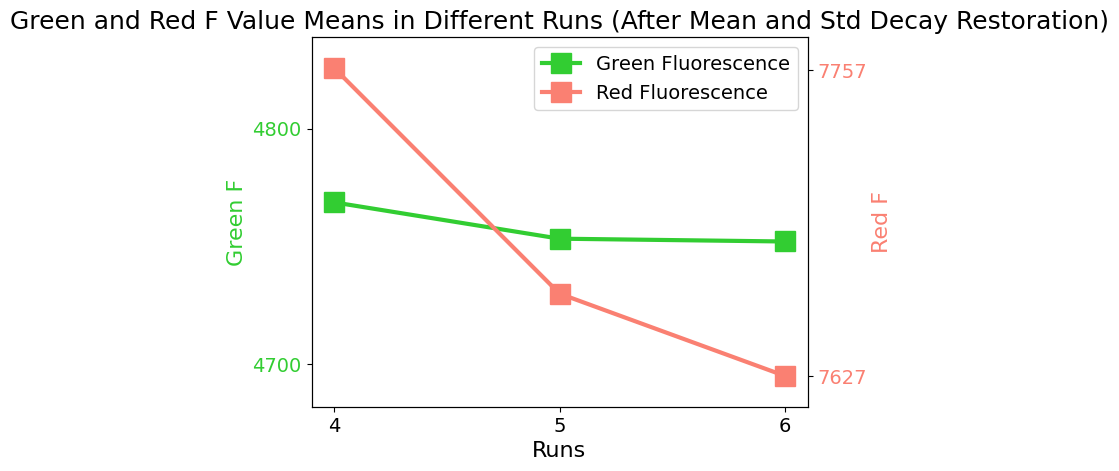

std of each run of green:
run index:0 -- std: 2477.04350436159
run index:1 -- std: 2456.9211738174085
run index:2 -- std: 2460.8668920489877
std of each run of red:
run index:0 -- std: 1473.581767095316
run index:1 -- std: 1374.9475866393655
run index:2 -- std: 1306.260248807851


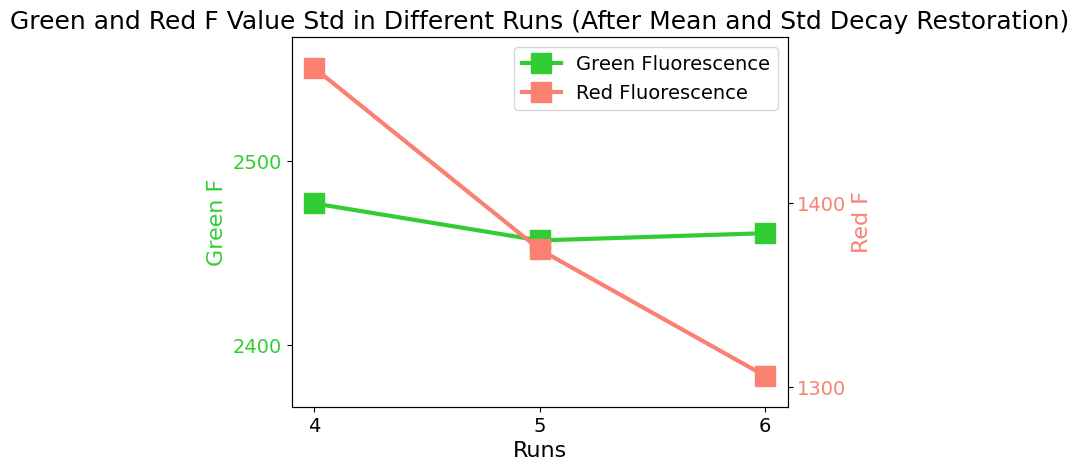

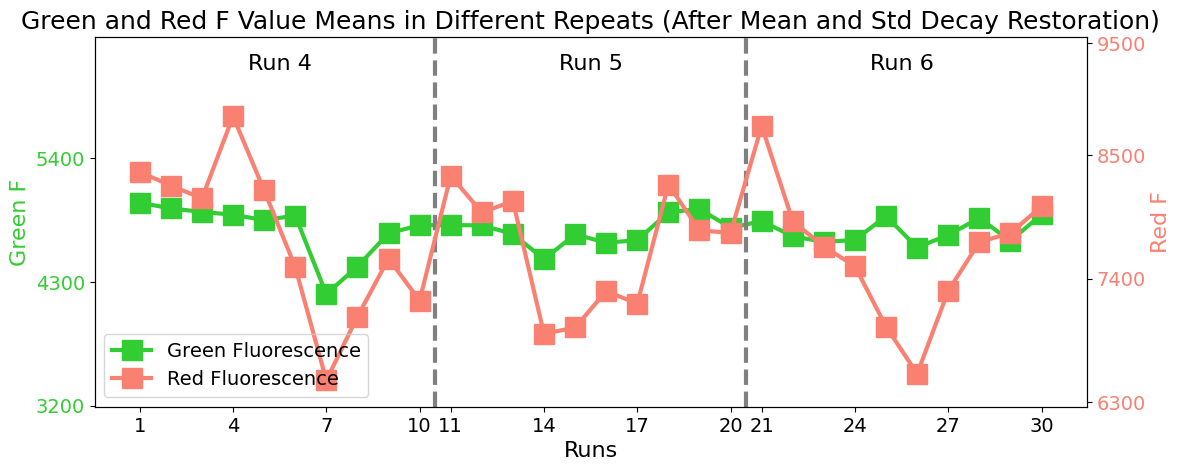

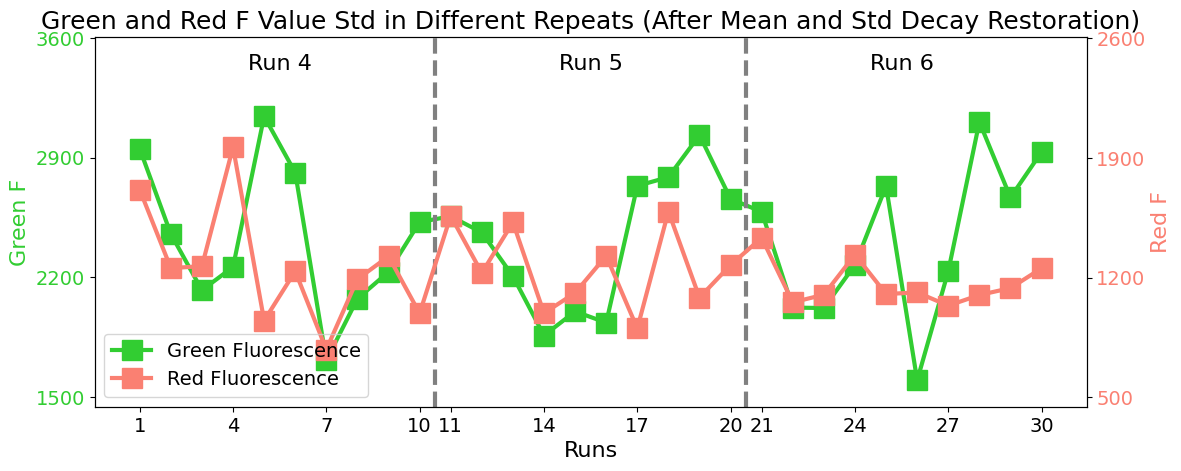

In [ ]:
### mean each run

print("mean of each run of green:")
green_mean_run = []
for run_ in range(len(run_num)):
    mean_ = np.mean(green_signal_traces_mean_restored_std_restored[run_,:,:])
    green_mean_run.append(mean_)
    print(f"run index:{run_} -- mean: {mean_}")

print("mean of each run of red:")
red_mean_run = []
for run_ in range(len(run_num)):
    mean_ = np.mean(red_signal_traces_mean_restored_std_restored[run_,:,:])
    red_mean_run.append(mean_)
    print(f"run index:{run_} -- mean: {mean_}")

# plot figure
x = range(len(run_num))
x_custom = [run_ for run_ in run_num]
y1 = green_mean_run
y2 = red_mean_run

fig, ax1 = plt.subplots(figsize=(6.4, 4.8)) # [6.4, 4.8] is deault size, same as fig, ax1 = plt.subplots()

green_line, = ax1.plot(x, y1, 's-', color='limegreen', label='Green Fluorescence', markersize=14, linewidth=3)
ax1.set_xlabel('Runs', fontsize=16)
ax1.set_ylabel('Green F', color='limegreen', fontsize=16)
ax1.tick_params(axis='y', labelcolor='limegreen', labelsize=14)

# set custome x axis labels
ax1.set_xticks(x)
ax1.set_xticklabels(x_custom)
ax1.tick_params(axis='x', labelsize=14)

ax2 = ax1.twinx()

red_line, = ax2.plot(x, y2, 's-', color='salmon', label='Red Fluorescence', markersize=14, linewidth=3)
ax2.set_ylabel('Red F', color='salmon', fontsize=16)
ax2.tick_params(axis='y', labelcolor='salmon', labelsize=14)

# set two y axes with same value for unit length
span = max((max(y1) - min(y1), max(y2) - min(y2)))
average_1 = (max(y1) + min(y1)) / 2
average_2 = (max(y2) + min(y2)) / 2
min_y1, max_y1 = average_1 - 0.6*span, average_1 + 0.6*span
min_y2, max_y2 = average_2 - 0.6*span, average_2 + 0.6*span
ax1.set_ylim(min_y1, max_y1)
ax2.set_ylim(min_y2, max_y2)
# make ticks sparse
min_y1_, max_y1_ = np.ceil(min_y1 / 100) * 100, np.floor(max_y1 / 100) * 100
min_y2_, max_y2_ = np.ceil(min_y2 / 100) * 100, np.floor(max_y2 / 100) * 100
# here use ceil for min and floor for ceil is to gurantee that the range used in
# set_yticks is within the range of set_ylim, otherwise a new range of the axis
# will consider both set_yticks and set_ylim and give the union of them.
unit_1 = np.ceil((max_y1_ - min_y1_) / 3 / 100) * 100 # 3 means only 3+1 ticks
unit_2 = np.ceil((max_y2_ - min_y2_) / 3 / 100) * 100
unit_unified = max(unit_1, unit_2)
if min_y1_ != max_y1_:
    if np.arange(min_y1_, max_y1_, step=unit_unified)[-1] > max(y1):
        sparse_y_ticks_1 = np.arange(min_y1_, max_y1_, step=unit_unified)
    else:
        sparse_y_ticks_1 = np.append(np.arange(min_y1_, max_y1_, step=unit_unified), max_y1_)
else:
    sparse_y_ticks_1 = np.array([int(min(y1)), int(max(y1))])
if min_y2_ != max_y2_:
    if np.arange(min_y2_, max_y2_, step=unit_unified)[-1] > max(y2):
        sparse_y_ticks_2 = np.arange(min_y2_, max_y2_, step=unit_unified)
    else:
        sparse_y_ticks_2 = np.append(np.arange(min_y2_, max_y2_, step=unit_unified), max_y2_)
else:
    sparse_y_ticks_2 = np.array([int(min(y2)), int(max(y2))])
ax1.set_yticks(sparse_y_ticks_1)
ax2.set_yticks(sparse_y_ticks_2)

# put two legends together
lines = [green_line, red_line]
labels = [line.get_label() for line in lines]
ax2.legend(lines, labels, fontsize=14, facecolor='none')

plt.title("Green and Red F Value Means in Different Runs (After Mean and Std Decay Restoration)", fontsize=18)

plt.show()


### std each run

print("std of each run of green:")
green_std_run = []
for run_ in range(len(run_num)):
    std_ = np.std(green_signal_traces_mean_restored_std_restored[run_,:,:])
    green_std_run.append(std_)
    print(f"run index:{run_} -- std: {std_}")

print("std of each run of red:")
red_std_run = []
for run_ in range(len(run_num)):
    std_ = np.std(red_signal_traces_mean_restored_std_restored[run_,:,:])
    red_std_run.append(std_)
    print(f"run index:{run_} -- std: {std_}")

# plot figure
x = range(len(run_num))
x_custom = [run_ for run_ in run_num]
y1 = green_std_run
y2 = red_std_run

fig, ax1 = plt.subplots(figsize=(6.4, 4.8))

green_line, = ax1.plot(x, y1, 's-', color='limegreen', label='Green Fluorescence', markersize=14, linewidth=3)
ax1.set_xlabel('Runs', fontsize=16)
ax1.set_ylabel('Green F', color='limegreen', fontsize=16)
ax1.tick_params(axis='y', labelcolor='limegreen', labelsize=14)

# set custome x axis labels
ax1.set_xticks(x)
ax1.set_xticklabels(x_custom)
ax1.tick_params(axis='x', labelsize=14)

ax2 = ax1.twinx()

red_line, = ax2.plot(x, y2, 's-', color='salmon', label='Red Fluorescence', markersize=14, linewidth=3)
ax2.set_ylabel('Red F', color='salmon', fontsize=16)
ax2.tick_params(axis='y', labelcolor='salmon', labelsize=14)

# set two y axes with same value for unit length
span = max((max(y1) - min(y1), max(y2) - min(y2)))
average_1 = (max(y1) + min(y1)) / 2
average_2 = (max(y2) + min(y2)) / 2
min_y1, max_y1 = average_1 - 0.6*span, average_1 + 0.6*span
min_y2, max_y2 = average_2 - 0.6*span, average_2 + 0.6*span
ax1.set_ylim(min_y1, max_y1)
ax2.set_ylim(min_y2, max_y2)
# make ticks sparse
min_y1_, max_y1_ = np.ceil(min_y1 / 100) * 100, np.floor(max_y1 / 100) * 100
min_y2_, max_y2_ = np.ceil(min_y2 / 100) * 100, np.floor(max_y2 / 100) * 100
# here use ceil for min and floor for ceil is to gurantee that the range used in
# set_yticks is within the range of set_ylim, otherwise a new range of the axis
# will consider both set_yticks and set_ylim and give the union of them.
unit_1 = np.ceil((max_y1_ - min_y1_) / 3 / 100) * 100 # 3 means only 3+1 ticks
unit_2 = np.ceil((max_y2_ - min_y2_) / 3 / 100) * 100
unit_unified = max(unit_1, unit_2)
if min_y1_ != max_y1_:
    if np.arange(min_y1_, max_y1_, step=unit_unified)[-1] > max(y1):
        sparse_y_ticks_1 = np.arange(min_y1_, max_y1_, step=unit_unified)
    else:
        sparse_y_ticks_1 = np.append(np.arange(min_y1_, max_y1_, step=unit_unified), max_y1_)
else:
    sparse_y_ticks_1 = np.array([int(min(y1)), int(max(y1))])
if min_y2_ != max_y2_:
    if np.arange(min_y2_, max_y2_, step=unit_unified)[-1] > max(y2):
        sparse_y_ticks_2 = np.arange(min_y2_, max_y2_, step=unit_unified)
    else:
        sparse_y_ticks_2 = np.append(np.arange(min_y2_, max_y2_, step=unit_unified), max_y2_)
else:
    sparse_y_ticks_2 = np.array([int(min(y2)), int(max(y2))])
ax1.set_yticks(sparse_y_ticks_1)
ax2.set_yticks(sparse_y_ticks_2)

# put two legends together
lines = [green_line, red_line]
labels = [line.get_label() for line in lines]
ax2.legend(lines, labels, fontsize=14, facecolor='none')

plt.title("Green and Red F Value Std in Different Runs (After Mean and Std Decay Restoration)", fontsize=18)

plt.show()


### mean each repeat

# print("mean of each repeat of green:")
repeat_num = 10 # 10 repeats per run
repeat_len = int(green_signal_traces_mean_restored_std_restored.shape[2]/repeat_num)
green_mean_repeat = []
for run_ in range(len(run_num)):
    for i in range(repeat_num):
        mean_ = np.mean(green_signal_traces_mean_restored_std_restored[run_,:,i*repeat_len:(i+1)*repeat_len])
        green_mean_repeat.append(mean_)
        # print(f"run index:{run_} repeat index:{i} -- mean: {mean_}")

# print("mean of each repeat of red:")
red_mean_repeat = []
for run_ in range(len(run_num)):
    for i in range(repeat_num):
        mean_ = np.mean(red_signal_traces_mean_restored_std_restored[run_,:,i*repeat_len:(i+1)*repeat_len])
        red_mean_repeat.append(mean_)
        # print(f"run index:{run_} repeat index:{i} -- mean: {mean_}")

# plot figure
x = range(1, repeat_num * len(run_num) + 1)
y1 = green_mean_repeat
y2 = red_mean_repeat

fig, ax1 = plt.subplots(figsize=(6.4*2, 4.8))

green_line, = ax1.plot(x, y1, 's-', color='limegreen', label='Green Fluorescence', markersize=14, linewidth=3)
ax1.set_xlabel('Runs', fontsize=16)
ax1.set_ylabel('Green F', color='limegreen', fontsize=16)
ax1.tick_params(axis='y', labelcolor='limegreen', labelsize=14)

# set custome x axis labels
ax1.set_xticks(x)
if len(x) == 30 and len(run_num) == 3: # ste a better xticks for the common case
    ax1.set_xticks([1,4,7,10,11,14,17,20,21,24,27,30])
ax1.tick_params(axis='x', labelsize=14)

ax2 = ax1.twinx()

red_line, = ax2.plot(x, y2, 's-', color='salmon', label='Red Fluorescence', markersize=14, linewidth=3)
ax2.set_ylabel('Red F', color='salmon', fontsize=16)
ax2.tick_params(axis='y', labelcolor='salmon', labelsize=14)

# set two y axes with same value for unit length
span = max((max(y1) - min(y1), max(y2) - min(y2)))
average_1 = (max(y1) + min(y1)) / 2
average_2 = (max(y2) + min(y2)) / 2
min_y1, max_y1 = average_1 - 0.6*span, average_1 + 0.8*span
min_y2, max_y2 = average_2 - 0.6*span, average_2 + 0.8*span
ax1.set_ylim(min_y1, max_y1)
ax2.set_ylim(min_y2, max_y2)
# make ticks sparse
min_y1_, max_y1_ = np.ceil(min_y1 / 100) * 100, np.floor(max_y1 / 100) * 100
min_y2_, max_y2_ = np.ceil(min_y2 / 100) * 100, np.floor(max_y2 / 100) * 100
# here use ceil for min and floor for ceil is to gurantee that the range used in
# set_yticks is within the range of set_ylim, otherwise a new range of the axis
# will consider both set_yticks and set_ylim and give the union of them.
unit_1 = np.ceil((max_y1_ - min_y1_) / 3 / 100) * 100 # 3 means only 3+1 ticks
unit_2 = np.ceil((max_y2_ - min_y2_) / 3 / 100) * 100
unit_unified = max(unit_1, unit_2)
if min_y1_ != max_y1_:
    if np.arange(min_y1_, max_y1_, step=unit_unified)[-1] > max(y1):
        sparse_y_ticks_1 = np.arange(min_y1_, max_y1_, step=unit_unified)
    else:
        sparse_y_ticks_1 = np.append(np.arange(min_y1_, max_y1_, step=unit_unified), max_y1_)
else:
    sparse_y_ticks_1 = np.array([int(min(y1)), int(max(y1))])
if min_y2_ != max_y2_:
    if np.arange(min_y2_, max_y2_, step=unit_unified)[-1] > max(y2):
        sparse_y_ticks_2 = np.arange(min_y2_, max_y2_, step=unit_unified)
    else:
        sparse_y_ticks_2 = np.append(np.arange(min_y2_, max_y2_, step=unit_unified), max_y2_)
else:
    sparse_y_ticks_2 = np.array([int(min(y2)), int(max(y2))])
ax1.set_yticks(sparse_y_ticks_1)
ax2.set_yticks(sparse_y_ticks_2)

# add separating dash lines and add run names
for i, run_ in enumerate(run_num):
    if i < len(run_num) - 1:
        ax1.axvline(x=repeat_num*(i+1)+0.5, color='gray', linestyle='--', linewidth=3)
    ax1.text(repeat_num*(i+0.5)+0.5, average_1+0.7*span, 'Run ' + run_, ha='center', va='center', fontsize=16)

# put two legends together
lines = [green_line, red_line]
labels = [line.get_label() for line in lines]
ax2.legend(lines, labels, loc = 'lower left', fontsize=14, facecolor='none')

plt.title("Green and Red F Value Means in Different Repeats (After Mean and Std Decay Restoration)", fontsize=18)

plt.show()


### std each repeat

# print("std of each repeat of green:")
repeat_num = 10 # 10 repeats per run
repeat_len = int(green_signal_traces_mean_restored_std_restored.shape[2]/repeat_num)
green_std_repeat = []
for run_ in range(len(run_num)):
    for i in range(repeat_num):
        std_ = np.std(green_signal_traces_mean_restored_std_restored[run_,:,i*repeat_len:(i+1)*repeat_len])
        green_std_repeat.append(std_)
        # print(f"run index:{run_} repeat index:{i} -- std: {std_}")

# print("std of each repeat of red:")
red_std_repeat = []
for run_ in range(len(run_num)):
    for i in range(repeat_num):
        std_ = np.std(red_signal_traces_mean_restored_std_restored[run_,:,i*repeat_len:(i+1)*repeat_len])
        red_std_repeat.append(std_)
        # print(f"run index:{run_} repeat index:{i} -- std: {std_}")

# plot figure
x = range(1, repeat_num * len(run_num) + 1)
y1 = green_std_repeat
y2 = red_std_repeat

fig, ax1 = plt.subplots(figsize=(6.4*2, 4.8))

green_line, = ax1.plot(x, y1, 's-', color='limegreen', label='Green Fluorescence', markersize=14, linewidth=3)
ax1.set_xlabel('Runs', fontsize=16)
ax1.set_ylabel('Green F', color='limegreen', fontsize=16)
ax1.tick_params(axis='y', labelcolor='limegreen', labelsize=14)

# set custome x axis labels
ax1.set_xticks(x)
if len(x) == 30 and len(run_num) == 3: # ste a better xticks for the common case
    ax1.set_xticks([1,4,7,10,11,14,17,20,21,24,27,30])
ax1.tick_params(axis='x', labelsize=14)

ax2 = ax1.twinx()

red_line, = ax2.plot(x, y2, 's-', color='salmon', label='Red Fluorescence', markersize=14, linewidth=3)
ax2.set_ylabel('Red F', color='salmon', fontsize=16)
ax2.tick_params(axis='y', labelcolor='salmon', labelsize=14)

# set two y axes with same value for unit length
span = max((max(y1) - min(y1), max(y2) - min(y2)))
average_1 = (max(y1) + min(y1)) / 2
average_2 = (max(y2) + min(y2)) / 2
min_y1, max_y1 = average_1 - 0.6*span, average_1 + 0.8*span
min_y2, max_y2 = average_2 - 0.6*span, average_2 + 0.8*span
ax1.set_ylim(min_y1, max_y1)
ax2.set_ylim(min_y2, max_y2)
# make ticks sparse
min_y1_, max_y1_ = np.ceil(min_y1 / 100) * 100, np.floor(max_y1 / 100) * 100
min_y2_, max_y2_ = np.ceil(min_y2 / 100) * 100, np.floor(max_y2 / 100) * 100
# here use ceil for min and floor for ceil is to gurantee that the range used in
# set_yticks is within the range of set_ylim, otherwise a new range of the axis
# will consider both set_yticks and set_ylim and give the union of them.
unit_1 = np.ceil((max_y1_ - min_y1_) / 3 / 100) * 100 # 3 means only 3+1 ticks
unit_2 = np.ceil((max_y2_ - min_y2_) / 3 / 100) * 100
unit_unified = max(unit_1, unit_2)
if min_y1_ != max_y1_:
    if np.arange(min_y1_, max_y1_, step=unit_unified)[-1] > max(y1):
        sparse_y_ticks_1 = np.arange(min_y1_, max_y1_, step=unit_unified)
    else:
        sparse_y_ticks_1 = np.append(np.arange(min_y1_, max_y1_, step=unit_unified), max_y1_)
else:
    sparse_y_ticks_1 = np.array([int(min(y1)), int(max(y1))])
if min_y2_ != max_y2_:
    if np.arange(min_y2_, max_y2_, step=unit_unified)[-1] > max(y2):
        sparse_y_ticks_2 = np.arange(min_y2_, max_y2_, step=unit_unified)
    else:
        sparse_y_ticks_2 = np.append(np.arange(min_y2_, max_y2_, step=unit_unified), max_y2_)
else:
    sparse_y_ticks_2 = np.array([int(min(y2)), int(max(y2))])
ax1.set_yticks(sparse_y_ticks_1)
ax2.set_yticks(sparse_y_ticks_2)

# add separating dash lines and add run names
for i, run_ in enumerate(run_num):
    if i < len(run_num) - 1:
        ax1.axvline(x=repeat_num*(i+1)+0.5, color='gray', linestyle='--', linewidth=3)
    ax1.text(repeat_num*(i+0.5)+0.5, average_1+0.7*span, 'Run ' + run_, ha='center', va='center', fontsize=16)

# put two legends together
lines = [green_line, red_line]
labels = [line.get_label() for line in lines]
ax2.legend(lines, labels, loc = 'lower left', fontsize=14, facecolor='none')

plt.title("Green and Red F Value Std in Different Repeats (After Mean and Std Decay Restoration)", fontsize=18)

plt.show()

## store them to variables with new names
## and for later use in decay restoration
green_mean_repeat_list_after_mean_restored_std_restored = green_mean_repeat.copy() # same as green_mean_repeat_restored
red_mean_repeat_list_after_mean_restored_std_restored = red_mean_repeat.copy() # same as red_mean_repeat_restored

green_mean_run_list_after_mean_restored_std_restored = green_mean_run.copy()
red_mean_run_list_after_mean_restored_std_restored = red_mean_run.copy()

green_std_repeat_list_after_mean_restored_std_restored = green_std_repeat.copy()
red_std_repeat_list_after_mean_restored_std_restored = red_std_repeat.copy()

green_std_run_list_after_mean_restored_std_restored = green_std_run.copy()
red_std_run_list_after_mean_restored_std_restored = red_std_run.copy()

#### Save important data

In [ ]:
# np.save(cell_name+'red_signal_traces.npy', red_signal_traces)
# np.save(cell_name+'red_conca_fluo_data.npy', red_conca_fluo_data)
# np.save(cell_name+'red_locations.npy', red_locations)

# np.save(cell_name+'green_signal_traces.npy', green_signal_traces)
# np.save(cell_name+'green_conca_fluo_data.npy', green_conca_fluo_data)
# np.save(cell_name+'green_locations.npy', green_locations)

# np.save(cell_name+'green_signal_traces_mean_restored.npy', green_signal_traces_mean_restored)
# np.save(cell_name+'red_signal_traces_mean_restored.npy', red_signal_traces_mean_restored)

# np.save(cell_name+'green_signal_traces_mean_restored_std_restored.npy', green_signal_traces_mean_restored_std_restored)
# np.save(cell_name+'red_signal_traces_mean_restored_std_restored.npy', red_signal_traces_mean_restored_std_restored)


In [ ]:
# # Load red signal traces data
# red_signal_traces = np.load(cell_name + 'red_signal_traces.npy')
# print("Red Signal Traces Shape:", red_signal_traces.shape)
# print("Red Signal Traces Type:", type(red_signal_traces))

# # Load red concatenated fluorescence data
# red_conca_fluo_data = np.load(cell_name + 'red_conca_fluo_data.npy', allow_pickle=True)
# print("Red Concatenated Fluorescence Data Shape:", red_conca_fluo_data.shape)
# print("Red Concatenated Fluorescence Data Type:", type(red_conca_fluo_data))
# print("Red Concatenated Fluorescence Data Elements Shape:", red_conca_fluo_data[0,0].shape)
# print("Red Concatenated Fluorescence Data Elements Type:", type(red_conca_fluo_data[0, 0]))

# # Load red locations data
# red_locations = np.load(cell_name + 'red_locations.npy', allow_pickle=True)
# print("Red Locations Shape:", red_locations.shape)
# print("Red Locations Type:", type(red_locations))
# print("Red Locations Elements Shape:", red_locations[0,0].shape)
# print("Red Locations Elements Type:", type(red_locations[0, 0]))

# # Load green signal traces data
# green_signal_traces = np.load(cell_name + 'green_signal_traces.npy')
# print("Green Signal Traces Shape:", green_signal_traces.shape)
# print("Green Signal Traces Type:", type(green_signal_traces))

# # Load green concatenated fluorescence data
# green_conca_fluo_data = np.load(cell_name + 'green_conca_fluo_data.npy', allow_pickle=True)
# print("Green Concatenated Fluorescence Data Shape:", green_conca_fluo_data.shape)
# print("Green Concatenated Fluorescence Data Type:", type(green_conca_fluo_data))
# print("Green Concatenated Fluorescence Elements Data Shape:", green_conca_fluo_data[0,0].shape)
# print("Green Concatenated Fluorescence Elements Data Type:", type(green_conca_fluo_data[0, 0]))

# # Load green locations data
# green_locations = np.load(cell_name + 'green_locations.npy', allow_pickle=True)
# print("Green Locations Shape:", green_locations.shape)
# print("Green Locations Type:", type(green_locations))
# print("Green Locations Elements Shape:", green_locations[0,0].shape)
# print("Green Locations Elements Type:", type(green_locations[0, 0]))

# # Load green signal traces mean restored data
# green_signal_traces_mean_restored = np.load(cell_name + 'green_signal_traces_mean_restored.npy')
# print("Green Signal Traces Mean Restored Shape:", green_signal_traces_mean_restored.shape)
# print("Green Signal Traces Mean Restored Type:", type(green_signal_traces_mean_restored))

# # Load red signal traces mean restored data
# red_signal_traces_mean_restored = np.load(cell_name + 'red_signal_traces_mean_restored.npy')
# print("Red Signal Traces Mean Restored Shape:", red_signal_traces_mean_restored.shape)
# print("Red Signal Traces Mean Restored Type:", type(red_signal_traces_mean_restored))

# # Load green signal traces mean restored std restored data
# green_signal_traces_mean_restored_std_restored = np.load(cell_name + 'green_signal_traces_mean_restored_std_restored.npy')
# print("Green Signal Traces Mean Restored Std Restored Shape:", green_signal_traces_mean_restored_std_restored.shape)
# print("Green Signal Traces Mean Restored Std Restored Type:", type(green_signal_traces_mean_restored_std_restored))

# # Load red signal traces mean restored std restored data
# red_signal_traces_mean_restored_std_restored = np.load(cell_name + 'red_signal_traces_mean_restored_std_restored.npy')
# print("Red Signal Traces Mean Restored Std Restored Shape:", red_signal_traces_mean_restored_std_restored.shape)
# print("Red Signal Traces Mean Restored Std Restored Type:", type(red_signal_traces_mean_restored_std_restored))


In [ ]:
# # batch download the plotted figures
# # uncomment the code below to download figures if needed

# import glob

# folder_path = '.'
# # file_prefix = 'All_Conditions_All_Rounds_All_Repeats_'
# file_prefix = 'CL'

# # Use glob to find all files with the given prefix in the folder
# matching_files = glob.glob(f"{folder_path}/{file_prefix}*")
# # print(matching_files)
# # # Print the matching file names
# # for file_path in matching_files:
# #     print(file_path)

# import zipfile

# zip_filename = 'files.zip'
# with zipfile.ZipFile(zip_filename, 'w') as zipf:
#     # Add files to the zip file
#     for file_path in matching_files:
#         zipf.write(file_path)

# from google.colab import files
# files.download(zip_filename)

#### Generate the data and label, and train and eval

In [ ]:
# data_set = green_signal_traces_mean_restored_std_restored.copy()
# label_set = red_signal_traces_mean_restored_std_restored.copy()
# data_set = green_signal_traces_mean_restored.copy()
# label_set = red_signal_traces_mean_restored.copy()
data_set = green_signal_traces.copy()
label_set = red_signal_traces.copy()
print(data_set.shape)
print(label_set.shape)


(3, 281, 32500)
(3, 1, 32500)


In [ ]:
# Normalize data_set
data_set_min = np.min(data_set)
data_set_max = np.max(data_set)
data_set = ((data_set - data_set_min) / (data_set_max - data_set_min) - 0.5) * 2

# Normalize label_set
label_set_min = np.min(label_set)
label_set_max = np.max(label_set)
label_set = ((label_set - label_set_min) / (label_set_max - label_set_min) - 0.5) * 2

In [ ]:
# Define dataset class
class FluoDataset(Dataset):
    def __init__(self, data_set, label_set, z_indices, x_indices):
        self.data_set = data_set
        self.label_set = label_set
        self.z_indices = z_indices
        self.x_indices = x_indices

    def __len__(self):
        return len(self.z_indices)

    def __getitem__(self, idx):
        z = self.z_indices[idx]
        x = self.x_indices[idx]

        input_data = self.data_set[z, :, x-62:x]
        target_label = np.mean(self.label_set[z, :, x-31:x])

        return torch.tensor(input_data, dtype=torch.float32), torch.tensor(target_label, dtype=torch.float32)
        # or torch.from_numpy(input_data).float(), torch.from_numpy(target_label).float()


# Split the data into train and test sets
length = 6400*2
choices = range(3)
train_z_indices = np.random.choice(choices, size=length)
choices = range(62, 30000)
train_x_indices = np.random.choice(choices, size=length)

length = 640
choices = range(3)
test_z_indices = np.random.choice(choices, size=length)
choices = range(30000, 32500)
choices = range(62, 30000)
test_x_indices = np.random.choice(choices, size=length)

train_dataset = FluoDataset(data_set, label_set, train_z_indices, train_x_indices)
test_dataset = FluoDataset(data_set, label_set, test_z_indices, test_x_indices)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(len(train_loader))
print(len(test_loader))


# Define the model
class FluoModel(nn.Module):
    def __init__(self):
        super(FluoModel, self).__init__()
        self.fc_shared = nn.Linear(62, 1)  # Shared fully connected layer
        self.fc_reduce = nn.Linear(281, 1)  # Fully connected layer to reduce 281 channels to 1
        self.sigmoid = nn.Sigmoid()
        self.fc_end = nn.Linear(1, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1, 62)  # Reshape to (batch_size, 281, 62)

        # Apply the shared fully connected layer along the last dimension (62)
        shared_output = self.fc_shared(x).squeeze(2)
        # self.fc_shared(x) shape is (batch_size, 281, 1)
        # In PyTorch, when you apply a fully connected layer (or any other linear
        # transformation) to a 3D tensor, by default, the operation is performed
        # along the last dimension of the tensor.

        # Reduce 281 channels to 1 using a separate fully connected layer
        reduced_output = self.fc_reduce(shared_output)
        pre_output = self.sigmoid(reduced_output)
        output = self.fc_end(pre_output)

        return output

model = FluoModel()

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.002)
# scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# Training loop
num_epochs = 90
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {loss.item():.4f}")
    # scheduler.step()

    # Testing
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            test_loss += criterion(outputs.squeeze(), targets).item()

    average_test_loss = test_loss / len(test_loader)

    print(f"Test Loss: {average_test_loss:.4f}")

200
10
Epoch [1/90] - Loss: 0.0818
Test Loss: 0.0718
Epoch [2/90] - Loss: 0.0212
Test Loss: 0.0245
Epoch [3/90] - Loss: 0.0207
Test Loss: 0.0240
Epoch [4/90] - Loss: 0.0252
Test Loss: 0.0240
Epoch [5/90] - Loss: 0.0283
Test Loss: 0.0240
Epoch [6/90] - Loss: 0.0194
Test Loss: 0.0240
Epoch [7/90] - Loss: 0.0163
Test Loss: 0.0240
Epoch [8/90] - Loss: 0.0141
Test Loss: 0.0240
Epoch [9/90] - Loss: 0.0155
Test Loss: 0.0240
Epoch [10/90] - Loss: 0.0257
Test Loss: 0.0241
Epoch [11/90] - Loss: 0.0201
Test Loss: 0.0240
Epoch [12/90] - Loss: 0.0254
Test Loss: 0.0240
Epoch [13/90] - Loss: 0.0428
Test Loss: 0.0240
Epoch [14/90] - Loss: 0.0233
Test Loss: 0.0240
Epoch [15/90] - Loss: 0.0226
Test Loss: 0.0241
Epoch [16/90] - Loss: 0.0243
Test Loss: 0.0241
Epoch [17/90] - Loss: 0.0193
Test Loss: 0.0240
Epoch [18/90] - Loss: 0.0216
Test Loss: 0.0241
Epoch [19/90] - Loss: 0.0206
Test Loss: 0.0240
Epoch [20/90] - Loss: 0.0199
Test Loss: 0.0241
Epoch [21/90] - Loss: 0.0356
Test Loss: 0.0240
Epoch [22/90] -

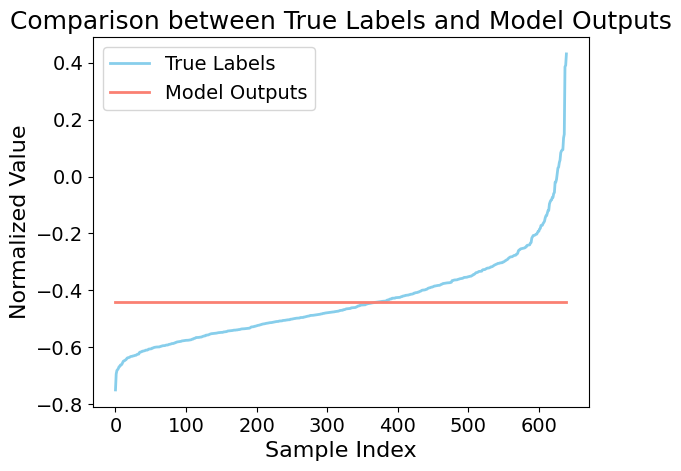

In [ ]:
# model_path = "./model_with_mean_restored_std_restored.pth"
# model_path = "./model_with_mean_restored.pth"
model_path = "./model_with_raw.pth"

with open(model_path, "wb") as f:
    torch.save(model.state_dict(), f)

model = FluoModel()
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model in evaluation mode

outputs_list = []
labels_list = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        outputs_list.append(outputs.numpy())
        labels_list.append(targets.numpy())

outputs_array = np.concatenate(outputs_list)
labels_array = np.concatenate(labels_list)

# Sort labels and corresponding outputs
sorted_indices = np.argsort(labels_array)
sorted_labels = labels_array[sorted_indices]
sorted_outputs = outputs_array[sorted_indices]

# plot results
plt.figure(figsize=(6.4, 4.8))
plt.plot(sorted_labels, color = 'skyblue', label='True Labels', linewidth=2)
plt.plot(sorted_outputs, color = 'salmon', label='Model Outputs', linewidth=2)
plt.xlabel('Sample Index', fontsize=16)
plt.ylabel('Normalized Value', fontsize=16)
plt.tick_params(labelsize=14)
plt.title('Comparison between True Labels and Model Outputs', fontsize=18)
plt.legend(fontsize=14, facecolor='none')
plt.show()


## Read pupil data

In [ ]:
root_path = "/content/drive/MyDrive/Fluorescence_Data/FluoData4Fitting_Average"

### Read pupil F

In [ ]:
# fucntion for calculate pre 2s mean, stimulation 2s mean, and post 2s mean
def calculate_means_by_ranges(arr): # input shape is (93, 1, 10)
    range1_mean = np.mean(arr[0:31], axis=0)
    range2_mean = np.mean(arr[31:62], axis=0)
    range3_mean = np.mean(arr[62:93], axis=0)

    # Transpose
    range1_mean = np.transpose(range1_mean)
    range2_mean = np.transpose(range2_mean)
    range3_mean = np.transpose(range3_mean)

    # Combine means into a 10x3 array
    combined_means = np.concatenate((range1_mean, range2_mean, range3_mean), axis=1)

    return combined_means

#### sum/mean along conditions

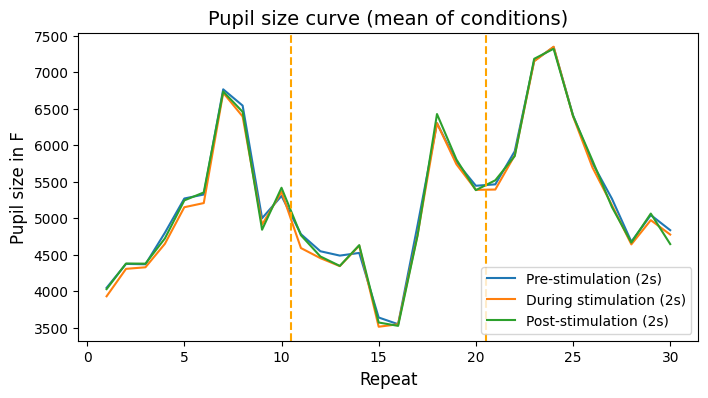

In [ ]:
### read dFF values for pupil size for each run (round)

## run a

# read and calculate the pre 2s mean, stimulation 2s mean, and post 2s mean
path_ = os.path.join(root_path, cell_name, cell_name + 'green_PupilArea_Run' + run_num[0] + '.mat')
mat_data = scipy.io.loadmat(path_)
pupil_area_run4 = mat_data['Master_f']
pupil_area_run4 = pupil_area_run4[:, :-1] # delete the last column (49th)
for index, value in np.ndenumerate(pupil_area_run4):
    value = calculate_means_by_ranges(value) # here, value is a copy, so changing value will not change pupil_area_run4
    pupil_area_run4[index] = value # change original pupil_area_run4
# print(pupil_area_run4.shape)
# print(type(pupil_area_run4))
# print(type(pupil_area_run4[0,1]))
# print(pupil_area_run4[0,1].shape)

# sum and average red data to see the decay
sum_mat_pupil_run4 = np.zeros((pupil_area_run4.shape[0], 1), dtype=np.ndarray)
mean_mat_pupil_run4 = np.zeros((pupil_area_run4.shape[0], 1), dtype=np.ndarray)
for i in range(pupil_area_run4.shape[0]):
    sum = np.zeros((pupil_area_run4[0,0].shape[0], 1))
    for j in range(pupil_area_run4.shape[1]):
        sum = sum + pupil_area_run4[i,j]
    # print(np.sum(sum))
    sum_mat_pupil_run4[i, 0] = sum
    mean_mat_pupil_run4[i, 0] = sum / pupil_area_run4.shape[1]


## run b

# read and calculate the pre 2s mean, stimulation 2s mean, and post 2s mean
path_ = os.path.join(root_path, cell_name, cell_name + 'green_PupilArea_Run' + run_num[1] + '.mat')
mat_data = scipy.io.loadmat(path_)
pupil_area_run5 = mat_data['Master_f']
pupil_area_run5 = pupil_area_run5[:, :-1] # delete the last column (49th)
for index, value in np.ndenumerate(pupil_area_run5):
    value = calculate_means_by_ranges(value) # here, value is a copy, so changing value will not change pupil_area_run5
    pupil_area_run5[index] = value # change original pupil_area_run5
# print(pupil_area_run5.shape)
# print(type(pupil_area_run5))
# print(type(pupil_area_run5[0,1]))
# print(pupil_area_run5[0,1].shape)

# sum and average red data to see the decay
sum_mat_pupil_run5 = np.zeros((pupil_area_run5.shape[0], 1), dtype=np.ndarray)
mean_mat_pupil_run5 = np.zeros((pupil_area_run5.shape[0], 1), dtype=np.ndarray)
for i in range(pupil_area_run5.shape[0]):
    sum = np.zeros((pupil_area_run5[0,0].shape[0], 1))
    for j in range(pupil_area_run5.shape[1]):
        sum = sum + pupil_area_run5[i,j]
    # print(np.sum(sum))
    sum_mat_pupil_run5[i, 0] = sum
    mean_mat_pupil_run5[i, 0] = sum / pupil_area_run5.shape[1]


## run c

# read and calculate the pre 2s mean, stimulation 2s mean, and post 2s mean
path_ = os.path.join(root_path, cell_name, cell_name + 'green_PupilArea_Run' + run_num[2] + '.mat')
mat_data = scipy.io.loadmat(path_)
pupil_area_run6 = mat_data['Master_f']
pupil_area_run6 = pupil_area_run6[:, :-1] # delete the last column (49th)
for index, value in np.ndenumerate(pupil_area_run6):
    value = calculate_means_by_ranges(value) # here, value is a copy, so changing value will not change pupil_area_run6
    pupil_area_run6[index] = value # change original pupil_area_run6
# print(pupil_area_run6.shape)
# print(type(pupil_area_run6))
# print(type(pupil_area_run6[0,1]))
# print(pupil_area_run6[0,1].shape)

# sum and average red data to see the decay
sum_mat_pupil_run6 = np.zeros((pupil_area_run6.shape[0], 1), dtype=np.ndarray)
mean_mat_pupil_run6 = np.zeros((pupil_area_run6.shape[0], 1), dtype=np.ndarray)
for i in range(pupil_area_run6.shape[0]):
    sum = np.zeros((pupil_area_run6[0,0].shape[0], 1))
    for j in range(pupil_area_run6.shape[1]):
        sum = sum + pupil_area_run6[i,j]
    # print(np.sum(sum))
    sum_mat_pupil_run6[i, 0] = sum
    mean_mat_pupil_run6[i, 0] = sum / pupil_area_run6.shape[1]


# print(sum_mat_pupil_run4)
# print(sum_mat_pupil_run5)
# print(sum_mat_pupil_run6)
sum_mat_pupil = np.concatenate((sum_mat_pupil_run4[0,0], sum_mat_pupil_run5[0,0], sum_mat_pupil_run6[0,0]), axis=0)
mean_mat_pupil = np.concatenate((mean_mat_pupil_run4[0,0], mean_mat_pupil_run5[0,0], mean_mat_pupil_run6[0,0]), axis=0)
# print(sum_mat_pupil.T)
# print(mean_mat_pupil.T)


# plot
data = mean_mat_pupil
x = np.arange(1, 31)
fig, ax = plt.subplots(figsize=(8, 4))  # Adjust the figure size as desired
ax.plot(x,data[:, 0], label='Pre-stimulation (2s)')
ax.plot(x,data[:, 1], label='During stimulation (2s)')
ax.plot(x,data[:, 2], label='Post-stimulation (2s)')
ax.legend(fontsize='medium')
ax.set_xlabel('Repeat', fontsize=12)  # Adjust the label size as desired
ax.set_ylabel('Pupil size in F', fontsize=12)  # Adjust the label size as desired
ax.axvline(x=10.5, color='orange', linestyle='--')
ax.axvline(x=20.5, color='orange', linestyle='--')
# ax.text(5, 7200, 'Round 4', ha='center', va='center', fontsize=12) # need to change coordinates specificly
# ax.text(15.5, 7200, 'Round 5', ha='center', va='center', fontsize=12)
# ax.text(25.5, 7200, 'Round 6', ha='center', va='center', fontsize=12)
ax.set_title('Pupil size curve (mean of conditions)', fontsize=14)  # Adjust the title size as desired
ax.tick_params(axis='both', labelsize=10)  # Adjust the tick size as desired
plt.show()


#### sum/mean along repeats

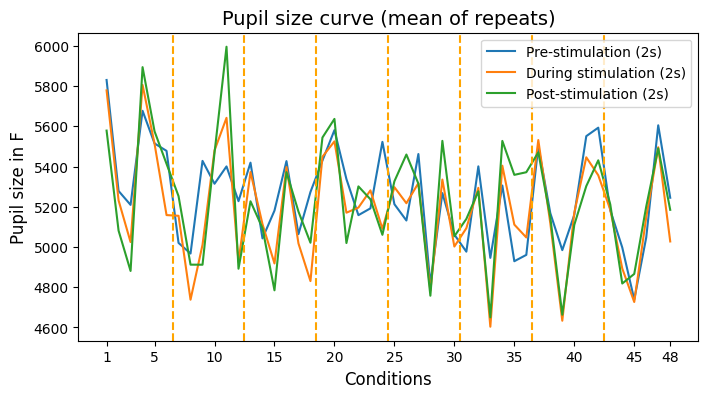

In [ ]:
### read dFF values for pupil size for each run (round)

## run 4

# read and calculate the pre 2s mean, stimulation 2s mean, and post 2s mean
path_ = os.path.join(root_path, cell_name, cell_name + 'green_PupilArea_Run' + run_num[0] + '.mat')
mat_data = scipy.io.loadmat(path_)
pupil_area_run4 = mat_data['Master_f']
pupil_area_run4 = pupil_area_run4[:, :-1] # delete the last column (49th)
for index, value in np.ndenumerate(pupil_area_run4):
    value = calculate_means_by_ranges(value) # here, value is a copy, so changing value will not change pupil_area_run4
    pupil_area_run4[index] = value # change original pupil_area_run4
# print(pupil_area_run4.shape)
# print(type(pupil_area_run4))
# print(type(pupil_area_run4[0,1]))
# print(pupil_area_run4[0,1].shape)

## run 5

# read and calculate the pre 2s mean, stimulation 2s mean, and post 2s mean
path_ = os.path.join(root_path, cell_name, cell_name + 'green_PupilArea_Run' + run_num[1] + '.mat')
mat_data = scipy.io.loadmat(path_)
pupil_area_run5 = mat_data['Master_f']
pupil_area_run5 = pupil_area_run5[:, :-1] # delete the last column (49th)
for index, value in np.ndenumerate(pupil_area_run5):
    value = calculate_means_by_ranges(value) # here, value is a copy, so changing value will not change pupil_area_run5
    pupil_area_run5[index] = value # change original pupil_area_run5
# print(pupil_area_run5.shape)
# print(type(pupil_area_run5))
# print(type(pupil_area_run5[0,1]))
# print(pupil_area_run5[0,1].shape)

## run 6

# read and calculate the pre 2s mean, stimulation 2s mean, and post 2s mean
path_ = os.path.join(root_path, cell_name, cell_name + 'green_PupilArea_Run' + run_num[2] + '.mat')
mat_data = scipy.io.loadmat(path_)
pupil_area_run6 = mat_data['Master_f']
pupil_area_run6 = pupil_area_run6[:, :-1] # delete the last column (49th)
for index, value in np.ndenumerate(pupil_area_run6):
    value = calculate_means_by_ranges(value) # here, value is a copy, so changing value will not change pupil_area_run6
    pupil_area_run6[index] = value # change original pupil_area_run6
# print(pupil_area_run6.shape)
# print(type(pupil_area_run6))
# print(type(pupil_area_run6[0,1]))
# print(pupil_area_run6[0,1].shape)

# stack/concatenate all conditions

# satstackck elements in pupil_area_run4 along the 0th axis
concatenated_run4 = np.stack(pupil_area_run4[0,:], axis=2)
# stack elements in pupil_area_run5 along the 0th axis
concatenated_run5 = np.stack(pupil_area_run5[0,:], axis=2)
# stack elements in pupil_area_run6 along the 0th axis
concatenated_run6 = np.stack(pupil_area_run6[0,:], axis=2)
# Concatenate the results from all three runs along the 1st axis
result = np.concatenate((concatenated_run4, concatenated_run5, concatenated_run6), axis=0)
# print(concatenated_run4.shape)
# print(result.shape)


# plot
data = np.mean(result, axis=0)
x = np.arange(1, 49)
fig, ax = plt.subplots(figsize=(8, 4))  # Adjust the figure size as desired
ax.plot(x,data[0, :], label='Pre-stimulation (2s)')
ax.plot(x,data[1, :], label='During stimulation (2s)')
ax.plot(x,data[2, :], label='Post-stimulation (2s)')
ax.legend(fontsize='medium')
ax.set_xlabel('Conditions', fontsize=12)  # Adjust the label size as desired
ax.set_ylabel('Pupil size in F', fontsize=12)  # Adjust the label size as desired
ax.axvline(x=6.5, color='orange', linestyle='--')
ax.axvline(x=12.5, color='orange', linestyle='--')
ax.axvline(x=18.5, color='orange', linestyle='--')
ax.axvline(x=24.5, color='orange', linestyle='--')
ax.axvline(x=30.5, color='orange', linestyle='--')
ax.axvline(x=36.5, color='orange', linestyle='--')
ax.axvline(x=42.5, color='orange', linestyle='--')
ax.set_title('Pupil size curve (mean of repeats)', fontsize=14)  # Adjust the title size as desired
ax.tick_params(axis='both', labelsize=10)  # Adjust the tick size as desired
# Customize x-axis ticks
tick_positions = [1,5,10,15,20,25,30,35,40,45,48]
plt.xticks(tick_positions)
plt.show()


#### mean for each (condition, repeat)

In [ ]:
### read dFF values for pupil size for each run (round)

## run 4

# read and calculate the pre 2s mean, stimulation 2s mean, and post 2s mean
path_ = os.path.join(root_path, cell_name, cell_name + 'green_PupilArea_Run' + run_num[0] + '.mat')
mat_data = scipy.io.loadmat(path_)
pupil_area_run4 = mat_data['Master_f']
pupil_area_run4 = pupil_area_run4[:, :-1] # delete the last column (49th)
for index, value in np.ndenumerate(pupil_area_run4):
    value = calculate_means_by_ranges(value) # here, value is a copy, so changing value will not change pupil_area_run4
    pupil_area_run4[index] = value # change original pupil_area_run4
# print(pupil_area_run4.shape)
# print(type(pupil_area_run4))
# print(type(pupil_area_run4[0,1]))
# print(pupil_area_run4[0,1].shape)
fine_mean_mat_pupil_run4 = copy.deepcopy(pupil_area_run4)

## run 5

# read and calculate the pre 2s mean, stimulation 2s mean, and post 2s mean
path_ = os.path.join(root_path, cell_name, cell_name + 'green_PupilArea_Run' + run_num[1] + '.mat')
mat_data = scipy.io.loadmat(path_)
pupil_area_run5 = mat_data['Master_f']
pupil_area_run5 = pupil_area_run5[:, :-1] # delete the last column (49th)
for index, value in np.ndenumerate(pupil_area_run5):
    value = calculate_means_by_ranges(value) # here, value is a copy, so changing value will not change pupil_area_run5
    pupil_area_run5[index] = value # change original pupil_area_run5
# print(pupil_area_run5.shape)
# print(type(pupil_area_run5))
# print(type(pupil_area_run5[0,1]))
# print(pupil_area_run5[0,1].shape)
fine_mean_mat_pupil_run5 = copy.deepcopy(pupil_area_run5)

## run 6

# read and calculate the pre 2s mean, stimulation 2s mean, and post 2s mean
path_ = os.path.join(root_path, cell_name, cell_name + 'green_PupilArea_Run' + run_num[2] + '.mat')
mat_data = scipy.io.loadmat(path_)
pupil_area_run6 = mat_data['Master_f']
pupil_area_run6 = pupil_area_run6[:, :-1] # delete the last column (49th)
for index, value in np.ndenumerate(pupil_area_run6):
    value = calculate_means_by_ranges(value) # here, value is a copy, so changing value will not change pupil_area_run6
    pupil_area_run6[index] = value # change original pupil_area_run6
# print(pupil_area_run6.shape)
# print(type(pupil_area_run6))
# print(type(pupil_area_run6[0,1]))
# print(pupil_area_run6[0,1].shape)
fine_mean_mat_pupil_run6 = copy.deepcopy(pupil_area_run6)

# concatenate
fine_mean_mat_pupil = np.concatenate((fine_mean_mat_pupil_run4,
                    fine_mean_mat_pupil_run5,
                    fine_mean_mat_pupil_run6),
                    axis = 0)
print(fine_mean_mat_pupil.shape)
print(fine_mean_mat_pupil[0,1].shape)

(3, 48)
(10, 3)


### Read pupil dFF

<class 'numpy.ndarray'>
(10, 1)
<class 'numpy.ndarray'>
(10, 1)
<class 'numpy.ndarray'>
(10, 1)
[[-1.05138376 -0.13521511  0.22459265 -1.30045993 -0.88000986 -0.73014825
  -0.23684986 -0.75100413 -0.24845973  0.99998111 -1.71898365 -0.59187931
  -0.79403246  1.68797097 -1.13479677  1.79954027 -0.81404467  0.29317292
   0.05337399 -0.22734424 -0.60822942 -0.07015685  0.01182725  0.10699081
   0.14049484 -0.31848347 -0.430526    0.32631886 -0.39290653  0.08752607]]


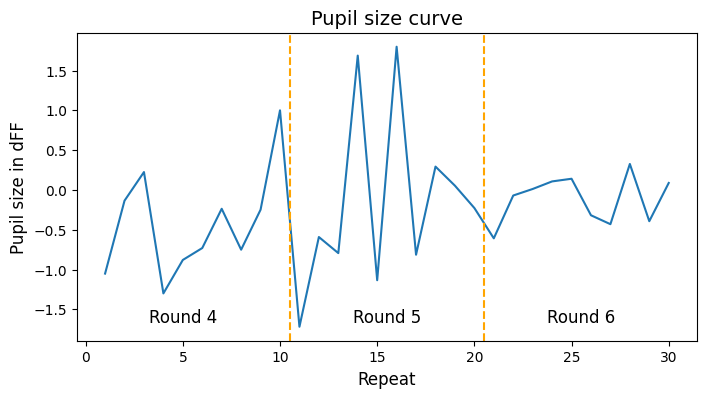

In [ ]:
### read dFF values for pupil size for each run (round)

# run 4
path_ = os.path.join(root_path, cell_name, cell_name + 'green_PupilArea_Run' + run_num[0] + '.mat')
mat_data = scipy.io.loadmat(path_)
pupil_area_run4 = mat_data['Master_dFF_mean']
pupil_area_run4 = pupil_area_run4[:, :-1]
print(type(pupil_area_run4[0,1]))
print(pupil_area_run4[0,1].shape)
# sum red data to see the decay
sum_mat_pupil_run4 = np.zeros((pupil_area_run4.shape[0], 1), dtype=np.ndarray)
for i in range(pupil_area_run4.shape[0]):
    sum = np.zeros((pupil_area_run4[0,0].shape[0], 1))
    for j in range(pupil_area_run4.shape[1]):
        sum = sum + pupil_area_run4[i,j]
    # print(np.sum(sum))
    sum_mat_pupil_run4[i, 0] = sum

# run 5
path_ = os.path.join(root_path, cell_name, cell_name + 'green_PupilArea_Run' + run_num[1] + '.mat')
mat_data = scipy.io.loadmat(path_)
pupil_area_run5 = mat_data['Master_dFF_mean']
pupil_area_run5 = pupil_area_run5[:, :-1]
print(type(pupil_area_run5[0,1]))
print(pupil_area_run5[0,1].shape)
# sum red data to see the decay
sum_mat_pupil_run5 = np.zeros((pupil_area_run5.shape[0], 1), dtype=np.ndarray)
for i in range(pupil_area_run5.shape[0]):
    sum = np.zeros((pupil_area_run5[0,0].shape[0], 1))
    for j in range(pupil_area_run5.shape[1]):
        sum = sum + pupil_area_run5[i,j]
    # print(np.sum(sum))
    sum_mat_pupil_run5[i, 0] = sum

# run 6
path_ = os.path.join(root_path, cell_name, cell_name + 'green_PupilArea_Run' + run_num[2] + '.mat')
mat_data = scipy.io.loadmat(path_)
pupil_area_run6 = mat_data['Master_dFF_mean']
pupil_area_run6 = pupil_area_run6[:, :-1]
print(type(pupil_area_run6[0,1]))
print(pupil_area_run6[0,1].shape)
# sum red data to see the decay
sum_mat_pupil_run6 = np.zeros((pupil_area_run6.shape[0], 1), dtype=np.ndarray)
for i in range(pupil_area_run6.shape[0]):
    sum = np.zeros((pupil_area_run6[0,0].shape[0], 1))
    for j in range(pupil_area_run6.shape[1]):
        sum = sum + pupil_area_run6[i,j]
    # print(np.sum(sum))
    sum_mat_pupil_run6[i, 0] = sum


# print(sum_mat_pupil_run4)
# print(sum_mat_pupil_run5)
# print(sum_mat_pupil_run6)
sum_mat_pupil = np.concatenate((sum_mat_pupil_run4[0,0], sum_mat_pupil_run5[0,0], sum_mat_pupil_run6[0,0]), axis=0)
print(sum_mat_pupil.T)


data = sum_mat_pupil
x = np.arange(1, 31)
fig, ax = plt.subplots(figsize=(8, 4))  # Adjust the figure size as desired
ax.plot(x, data)
ax.set_xlabel('Repeat', fontsize=12)  # Adjust the label size as desired
ax.set_ylabel('Pupil size in dFF', fontsize=12)  # Adjust the label size as desired
ax.axvline(x=10.5, color='orange', linestyle='--')
ax.axvline(x=20.5, color='orange', linestyle='--')
ax.text(5, -1.6, 'Round 4', ha='center', va='center', fontsize=12)
ax.text(15.5, -1.6, 'Round 5', ha='center', va='center', fontsize=12)
ax.text(25.5, -1.6, 'Round 6', ha='center', va='center', fontsize=12)
ax.set_title('Pupil size curve', fontsize=14)  # Adjust the title size as desired
ax.tick_params(axis='both', labelsize=10)  # Adjust the tick size as desired
plt.show()


## Read fluorescence dFF mean data into dicts

In [ ]:
root_path = "/content/drive/MyDrive/Fluorescence_Data/FluoData4Fitting_Average"

# Get a list of all the subdirectories: subfolders are viewed as cell names
cell_names = [f for f in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, f))]
# for cell in cell_names:
#     print(cell)

# Create a dictionary with default values
default_value = 0
cell_data_dict = {cell: default_value for cell in cell_names}
# print(cell_data_dict)

file_suffixes = ['green_Axon.mat', 'green_dFFMeanValues.mat', 'red_dFFMeanValues.mat']

for cell in cell_names:
    print(cell)
    file_names = [cell + suffix for suffix in file_suffixes]

    path_ = file_names[0] # green_Axon.mat
    path_ = os.path.join(root_path, cell, path_)
    mat_data = scipy.io.loadmat(path_)
    axons = mat_data['Axons'] # array containing nested arrays/sub-arrays
    # Squeeze the outer array
    axons = np.squeeze(axons, axis=0)
    for i in range(len(axons)):
        # Squeeze the inner array and convert the data type to 'int'
        axons[i] = np.squeeze(axons[i].astype(int), axis=0)
    # final axons' length is the number of groups with
    # each elements being a nested array of components

    path_ = file_names[1] # green_dFFMeanValues.mat
    path_ = os.path.join(root_path, cell, path_)
    mat_data = scipy.io.loadmat(path_)
    dFFMeanValues_green = mat_data['dFFMeanValues'] # 3 by 49

    path_ = file_names[2] # red_dFFMeanValues.mat
    path_ = os.path.join(root_path, cell, path_)
    mat_data = scipy.io.loadmat(path_)
    dFFMeanValues_red = mat_data['dFFMeanValues'] # 3 by 49

    cell_data_dict[cell] = {'axons': axons,
                'green_dFFMeanValues': dFFMeanValues_green,
                'red_dFFMeanValues': dFFMeanValues_red}

# # Print keys and types
# for key, value in cell_data_dict.items():
#     print("-- * * * * * --")
#     print(key, type(value))
#     for key_, value_ in value.items():
#         print(key_, type(value_))
# print("-- * * * * * --")

CL090_230515
CL090_230518
CL083_230413
CL075_230303
CL075_230228
CL079_230324


## Decay restoration of red and trend visualization (including setting whether considering pupil size in regression)

In the following chunks, the code


```
# at most one of the following options is True
mean_pupil_size_along_conditions_multiply = False # mean
mean_pupil_size_each_condition_each_repeat_multiply = True # fine
```

are used for setting how to considering pupile size in regression.

In [ ]:
# at most one of the following options is True
mean_pupil_size_along_conditions_multiply = False # mean
mean_pupil_size_each_condition_each_repeat_multiply = True # fine

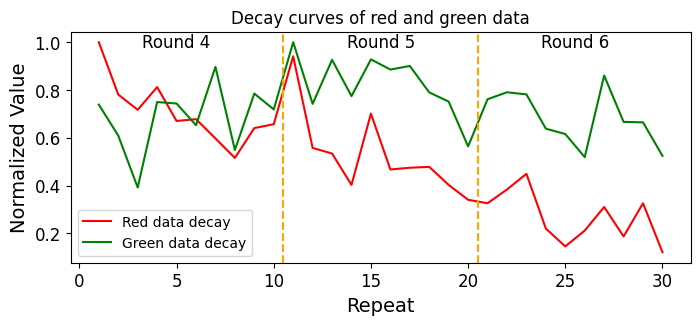

round 0, exponent in the exp func is -0.07472499699077181
round 1, exponent in the exp func is -0.12987990032231914
round 2, exponent in the exp func is -0.05409199709646579
red_recover_factor.shape: (3, 1)


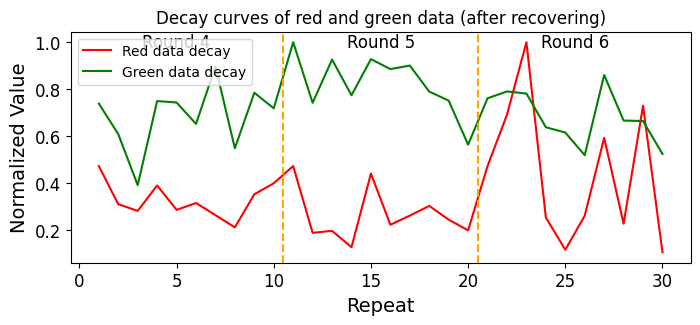

stacked_green.shape is (1440, 281) (compare with 48*3*10=1440)
group_satcked_green.shape, data_axons.shape are: (1440, 23) (23,)
stacked_red.shape is (1440, 1) (compare with 48*3*10=1440)
np.max(group_satcked_green), np.min(group_satcked_green) are: 23.665895684845708 -6.580518409021957
np.max(stacked_red), np.min(stacked_red) are: 1.1687414763592152 -0.46077202173483056


In [ ]:
cell_data = copy.deepcopy(cell_data_dict[cell_name])
# cell_data = copy.deepcopy(cell_data_dict['CL075_230303'])
# cell_data = cell_data_dict['CL090_230515']
# cell_data = cell_data_dict['CL075_230303']

# # the following 4 lines of code used for checking if cell_data and
# # cell_data_dict changed after running the code of this chunk; compare
# # with the printing at the end
# print(cell_data['red_dFFMeanValues'][1,1][0,-1])
# print(cell_data['green_dFFMeanValues'][1,1][0,-1])
# print(cell_data_dict['CL090_230515']['red_dFFMeanValues'][1,1][0,-1])
# print(cell_data_dict['CL090_230515']['green_dFFMeanValues'][1,1][0,-1])


delete_small_group = True # delete groups (axons) with less than 3 components

data_green = cell_data['green_dFFMeanValues'][:,:-1] # exclude 49th column
data_red = cell_data['red_dFFMeanValues'][:,:-1] # exclude 49th column
# data_red = cell_data['red_dFFMeanValues'][:,:-1].copy() # exclude 49th column
# the .copy() method is for a NumPy array. Using .copy() on a NumPy array,
# it creates a new copied array but it is a separate and independent object.
# Modifying the copied array will not affect the original array.
# # here uses .copy() to avoid cell_data and cell_data['red_dFFMeanValues'] be changed in
# # the later code line data_red[i,j] = red_recover_factor[i,0] * data_red[i,j], or we can use
# # cell_data = copy.deepcopy(cell_data_dict['CL090_230515']) to guarantee cell_data['red_dFFMeanValues']
# # will not be changed (cell_data will be changed).
# # copy.deepcopy will recursively copy all nested objects; copy.copy cannot do this.
data_axons = cell_data['axons']

# sum red data to see the decay
sum_mat_red = np.zeros((data_red.shape[0], 1), dtype=np.ndarray)
for i in range(data_red.shape[0]):
    sum = np.zeros((data_red[0,0].shape[0], 1))
    for j in range(data_red.shape[1]):
        sum = sum + data_red[i,j]
    # print(np.sum(sum))
    sum_mat_red[i, 0] = sum
# print("sum_mat_red:", sum_mat_red)

# Normalization of red
sum_mat_red_n = np.zeros((data_red.shape[0], 1), dtype=np.ndarray)
max_value = -np.inf
for i in range(sum_mat_red.shape[0]):
    for j in range(sum_mat_red.shape[1]):
        max_value = max(max_value, np.max(np.abs(sum_mat_red[i, j])))
for i in range(sum_mat_red.shape[0]):
    for j in range(sum_mat_red.shape[1]):
        element = sum_mat_red[i, j]
        sum_mat_red_n[i, j] = element / max_value
# print(sum_mat_red_n.shape)

# vstack sum_mat_red_n
stacked_sum_mat_red_n = np.empty((0, sum_mat_red_n[0,0].shape[1]))
# Enumerate the elements in the np array and vstack them
for index, value in np.ndenumerate(sum_mat_red_n):
    stacked_sum_mat_red_n = np.vstack((stacked_sum_mat_red_n, value))
stacked_sum_mat_red_n = np.squeeze(stacked_sum_mat_red_n)
# print(stacked_sum_mat_red_n.shape)


# sum green data to see the decay
sum_mat_green = np.zeros((data_green.shape[0], 1), dtype=np.ndarray)
for i in range(data_green.shape[0]):
    sum = np.zeros((data_green[0,0].shape[0], 1))
    for j in range(data_green.shape[1]):
        sum = sum + np.sum(data_green[i,j], axis=1, keepdims=True)
    # print(np.sum(sum))
    sum_mat_green[i, 0] = sum
# print(sum_mat_green)

# Normalization of green
sum_mat_green_n = np.zeros((data_green.shape[0], 1), dtype=np.ndarray)
max_value = -np.inf
for i in range(sum_mat_green.shape[0]):
    for j in range(sum_mat_green.shape[1]):
        max_value = max(max_value, np.max(np.abs(sum_mat_green[i, j])))
for i in range(sum_mat_green.shape[0]):
    for j in range(sum_mat_green.shape[1]):
        element = sum_mat_green[i, j]
        sum_mat_green_n[i, j] = element / max_value
# print(sum_mat_green_n.shape)

# vstack sum_mat_green_n
stacked_sum_mat_green_n = np.empty((0, sum_mat_green_n[0,0].shape[1]))
# Enumerate the elements in the np array and vstack them
for index, value in np.ndenumerate(sum_mat_green_n):
    stacked_sum_mat_green_n = np.vstack((stacked_sum_mat_green_n, value))
stacked_sum_mat_green_n = np.squeeze(stacked_sum_mat_green_n)
# print(stacked_sum_mat_green_n.shape)


# plot stacked_sum_mat_red_n and stacked_sum_mat_green_n
x = np.arange(1, stacked_sum_mat_green_n.shape[0] + 1)
fig, ax = plt.subplots(figsize=(8, 3))  # Adjust the figure size as desired
ax.plot(x, stacked_sum_mat_red_n, color='red', label='Red data decay')
ax.plot(x, stacked_sum_mat_green_n, color='green', label='Green data decay')
ax.axvline(x=10.5, color='orange', linestyle='--')
ax.axvline(x=20.5, color='orange', linestyle='--')
ax.text(5, 1, 'Round 4', ha='center', va='center', fontsize=12)
ax.text(15.5, 1, 'Round 5', ha='center', va='center', fontsize=12)
ax.text(25.5, 1, 'Round 6', ha='center', va='center', fontsize=12)
ax.set_title('Decay curves of red and green data')
ax.tick_params(axis='both', labelsize=12)  # Adjust the tick size as desired
ax.set_xlabel('Repeat', fontsize=14)  # Adjust the label size as desired
ax.set_ylabel('Normalized Value', fontsize=14)  # Adjust the label size as desired
ax.legend()
plt.show()


# Define the exponential function for regression of decay
def exponential_func(x, lambda_):
    return np.exp(lambda_ * x)
red_recover_factor = sum_mat_red_n.copy()
for i in range(sum_mat_red_n.shape[0]):
    for j in range(sum_mat_red_n.shape[1]): # sum_mat_red_n.shape[1] = 1
        y = sum_mat_red_n[i, j].copy()
        y = np.squeeze(y)
        multiplier = 1 / y[0]
        y = y * multiplier
        x = np.arange(10)
        popt, pcov = curve_fit(exponential_func, x, y)
        lambda_ = popt[0]
        print(f"round {i}, exponent in the exp func is {lambda_}")
        y_fit = exponential_func(x, lambda_)
        y = y.reshape(-1, 1)
        y_fit = y_fit.reshape(-1, 1)
        red_recover_factor[i, j] = (y / y_fit) * multiplier
print("red_recover_factor.shape:", red_recover_factor.shape)

for i in range(data_red.shape[0]):
    for j in range(data_red.shape[1]):
        data_red[i,j] = red_recover_factor[i,0] * data_red[i,j]

# sum red data to see the decay
sum_mat_red = np.zeros((data_red.shape[0], 1), dtype=np.ndarray)
for i in range(data_red.shape[0]):
    sum = np.zeros((data_red[0,0].shape[0], 1))
    for j in range(data_red.shape[1]):
        sum = sum + data_red[i,j]
    # print(np.sum(sum))
    sum_mat_red[i, 0] = sum
# print(sum_mat_red)

# Normalization of red
sum_mat_red_n = np.zeros((data_red.shape[0], 1), dtype=np.ndarray)
max_value = -np.inf
for i in range(sum_mat_red.shape[0]):
    for j in range(sum_mat_red.shape[1]):
        max_value = max(max_value, np.max(np.abs(sum_mat_red[i, j])))
for i in range(sum_mat_red.shape[0]):
    for j in range(sum_mat_red.shape[1]):
        element = sum_mat_red[i, j]
        sum_mat_red_n[i, j] = element / max_value
# print("sum_mat_red_n.shape:", sum_mat_red_n.shape)
# print("sum_mat_red_n[0,0].shape:", sum_mat_red_n[0,0].shape)

# vstack sum_mat_red_n
stacked_sum_mat_red_n = np.empty((0, sum_mat_red_n[0,0].shape[1]))
# Enumerate the elements in the np array and vstack them
for index, value in np.ndenumerate(sum_mat_red_n):
    stacked_sum_mat_red_n = np.vstack((stacked_sum_mat_red_n, value))
stacked_sum_mat_red_n = np.squeeze(stacked_sum_mat_red_n)
# print(stacked_sum_mat_red_n.shape)


# plot stacked_sum_mat_red_n and stacked_sum_mat_green_n
x = np.arange(1, stacked_sum_mat_green_n.shape[0] + 1)
fig, ax = plt.subplots(figsize=(8, 3))  # Adjust the figure size as desired
ax.plot(x, stacked_sum_mat_red_n, color='red', label='Red data decay')
ax.plot(x, stacked_sum_mat_green_n, color='green', label='Green data decay')
ax.axvline(x=10.5, color='orange', linestyle='--')
ax.axvline(x=20.5, color='orange', linestyle='--')
ax.text(5, 1, 'Round 4', ha='center', va='center', fontsize=12)
ax.text(15.5, 1, 'Round 5', ha='center', va='center', fontsize=12)
ax.text(25.5, 1, 'Round 6', ha='center', va='center', fontsize=12)
ax.set_title('Decay curves of red and green data (after recovering)')
ax.tick_params(axis='both', labelsize=12)  # Adjust the tick size as desired
ax.set_xlabel('Repeat', fontsize=14)  # Adjust the label size as desired
ax.set_ylabel('Normalized Value', fontsize=14)  # Adjust the label size as desired
ax.legend()
plt.show()


if mean_pupil_size_along_conditions_multiply:
    for i in range(data_green.shape[0]):
        if i == 0:
            mul_mat = mean_mat_pupil[:10,[1]] / np.mean(mean_mat_pupil)
        if i == 1:
            mul_mat = mean_mat_pupil[10:20,[1]] / np.mean(mean_mat_pupil)
        if i == 2:
            mul_mat = mean_mat_pupil[20:30,[1]] / np.mean(mean_mat_pupil)
        for j in range(data_green.shape[1]):
            data_green[i,j] = data_green[i,j] * mul_mat
if mean_pupil_size_each_condition_each_repeat_multiply:
    for i in range(data_green.shape[0]):
        for j in range(data_green.shape[1]):
            data_green[i,j] = data_green[i,j] * fine_mean_mat_pupil[i,j][:,[1]] / np.mean(mean_mat_pupil)


### the following is stacking opearion to make green and red data both 2-D
### so that thery are prepared for later regression

# print(data_axons)
# print(type(data_axons),len(data_axons))
if delete_small_group:
    data_axons = np.array([axons_ for axons_ in data_axons if len(axons_) >= 3], dtype=object)
# print(data_axons)
# print(type(data_axons),len(data_axons))

# vstack green data
stacked_green = np.empty((0, data_green[0,0].shape[1]))
# Enumerate the elements in the np array and vstack them
for index, value in np.ndenumerate(data_green):
    stacked_green = np.vstack((stacked_green, value))
print(f"stacked_green.shape is {stacked_green.shape} (compare with 48*3*10={48*3*10})")

# group columns of green data
group_num = data_axons.shape[0]
group_satcked_green = np.zeros((stacked_green.shape[0], group_num))
for i, cols in enumerate(data_axons):
    group_satcked_green[:, i] = np.sum(stacked_green[:, cols-1], axis=1)
print("group_satcked_green.shape, data_axons.shape are:", group_satcked_green.shape, data_axons.shape)

# vstack red data
stacked_red = np.empty((0, data_red[0,0].shape[1]))
# Enumerate the elements in the np array and vstack them
for index, value in np.ndenumerate(data_red):
    stacked_red = np.vstack((stacked_red, value))
print(f"stacked_red.shape is {stacked_red.shape} (compare with 48*3*10={48*3*10})")

print("np.max(group_satcked_green), np.min(group_satcked_green) are:", np.max(group_satcked_green), np.min(group_satcked_green))
print("np.max(stacked_red), np.min(stacked_red) are:", np.max(stacked_red), np.min(stacked_red))

# # the following 4 lines of code used for checking if cell_data and
# # cell_data_dict changed after running the code of this chunk; compare
# # with the beginning printing
# print(cell_data['red_dFFMeanValues'][1,1][0,-1])
# print(cell_data['green_dFFMeanValues'][1,1][0,-1])
# print(cell_data_dict['CL090_230515']['red_dFFMeanValues'][1,1][0,-1])
# print(cell_data_dict['CL090_230515']['green_dFFMeanValues'][1,1][0,-1])


## Set for no decay restoration

In [ ]:
# if wants to use the decay_restoration = False situation, reset data_red and data_green
decay_restoration = True
if decay_restoration == False: # if decay_restoration = False situation, reset data_red and data_green
    print("decay_restoration is False")
    cell_data = copy.deepcopy(cell_data_dict[cell_name])
    data_green = cell_data['green_dFFMeanValues'][:,:-1] # exclude 49th column
    data_red = cell_data['red_dFFMeanValues'][:,:-1] # exclude 49th column
    data_axons = cell_data['axons']

    ### the following is stacking opearion to make green and red data both 2-D
    ### so that thery are prepared for later regression

    # print(data_axons)
    # print(type(data_axons),len(data_axons))
    if delete_small_group:
        data_axons = np.array([axons_ for axons_ in data_axons if len(axons_) >= 3], dtype=object)
    # print(data_axons)
    # print(type(data_axons),len(data_axons))

    # vstack green data
    stacked_green = np.empty((0, data_green[0,0].shape[1]))
    # Enumerate the elements in the np array and vstack them
    for index, value in np.ndenumerate(data_green):
        stacked_green = np.vstack((stacked_green, value))
    print(f"stacked_green.shape is {stacked_green.shape} (compare with 48*3*10={48*3*10})")

    # group columns of green data
    group_num = data_axons.shape[0]
    group_satcked_green = np.zeros((stacked_green.shape[0], group_num))
    for i, cols in enumerate(data_axons):
        group_satcked_green[:, i] = np.sum(stacked_green[:, cols-1], axis=1)
    print("group_satcked_green.shape, data_axons.shape are:", group_satcked_green.shape, data_axons.shape)

    # vstack red data
    stacked_red = np.empty((0, data_red[0,0].shape[1]))
    # Enumerate the elements in the np array and vstack them
    for index, value in np.ndenumerate(data_red):
        stacked_red = np.vstack((stacked_red, value))
    print(f"stacked_red.shape is {stacked_red.shape} (compare with 48*3*10={48*3*10})")

    print("np.max(group_satcked_green), np.min(group_satcked_green) are:", np.max(group_satcked_green), np.min(group_satcked_green))
    print("np.max(stacked_red), np.min(stacked_red) are:", np.max(stacked_red), np.min(stacked_red))

## Analysis for pupil and fluorescence

### Prepare data

In [ ]:
cell_data = copy.deepcopy(cell_data_dict[cell_name])
# cell_data = copy.deepcopy(cell_data_dict['CL075_230303'])
# cell_data = cell_data_dict['CL090_230515']
# cell_data = cell_data_dict['CL075_230303']

data_green = cell_data['green_dFFMeanValues'][:,:-1] # exclude 49th column
data_red = cell_data['red_dFFMeanValues'][:,:-1] # exclude 49th column

data_axons = cell_data['axons']
delete_small_group = True # delete groups (axons) with less than 3 components
if delete_small_group:
    data_axons = np.array([axons_ for axons_ in data_axons if len(axons_) >= 3], dtype=object)

decay_restoration = True
if decay_restoration:
    # sum red data to see the decay
    sum_mat_red = np.zeros((data_red.shape[0], 1), dtype=np.ndarray)
    for i in range(data_red.shape[0]):
        sum = np.zeros((data_red[0,0].shape[0], 1))
        for j in range(data_red.shape[1]):
            sum = sum + data_red[i,j]
        # print(np.sum(sum))
        sum_mat_red[i, 0] = sum
    # print("sum_mat_red:", sum_mat_red)

    # Normalization of red
    sum_mat_red_n = np.zeros((data_red.shape[0], 1), dtype=np.ndarray)
    max_value = -np.inf
    for i in range(sum_mat_red.shape[0]):
        for j in range(sum_mat_red.shape[1]):
            max_value = max(max_value, np.max(np.abs(sum_mat_red[i, j])))
    for i in range(sum_mat_red.shape[0]):
        for j in range(sum_mat_red.shape[1]):
            element = sum_mat_red[i, j]
            sum_mat_red_n[i, j] = element / max_value
    # print(sum_mat_red_n.shape)

    # Define the exponential function for regression of decay
    def exponential_func(x, lambda_):
        return np.exp(lambda_ * x)
    red_recover_factor = sum_mat_red_n.copy()
    for i in range(sum_mat_red_n.shape[0]):
        for j in range(sum_mat_red_n.shape[1]): # sum_mat_red_n.shape[1] = 1
            y = sum_mat_red_n[i, j].copy()
            y = np.squeeze(y)
            multiplier = 1 / y[0]
            y = y * multiplier
            x = np.arange(10)
            popt, pcov = curve_fit(exponential_func, x, y)
            lambda_ = popt[0]
            print(f"round {i}, exponent in the exp func is {lambda_}")
            y_fit = exponential_func(x, lambda_)
            y = y.reshape(-1, 1)
            y_fit = y_fit.reshape(-1, 1)
            red_recover_factor[i, j] = (y / y_fit) * multiplier
    print("red_recover_factor.shape:", red_recover_factor.shape)

    for i in range(data_red.shape[0]):
        for j in range(data_red.shape[1]):
            data_red[i,j] = red_recover_factor[i,0] * data_red[i,j]

print("green:")
print(type(data_green))
print(data_green.shape)
print(data_green[1,1].shape)

print("red:")
print(type(data_red))
print(data_red.shape)
print(data_red[1,1].shape)

print("fine_mean_mat_pupil:")
print(fine_mean_mat_pupil.shape)
print(fine_mean_mat_pupil[0,1].shape)


data_green_mean = copy.deepcopy(data_green)
data_green_std = copy.deepcopy(data_green)

green_mean_vstack_array = np.empty((0, 1))
green_std_vstack_array = np.empty((0, 1))
red_vstack_array = np.empty((0, 1))
mean_pupil_vstack_array = np.empty((0, 1))

num_column = data_green.shape[1]
green_mean_vstack_array_condition = np.empty((0, num_column))
green_std_vstack_array_condition = np.empty((0, num_column))
red_vstack_array_condition = np.empty((0, num_column))
mean_pupil_vstack_array_condition = np.empty((0, num_column))

num_group = len(data_axons)
print("num_group:", num_group)
green_mean_vstack_array_condition_groups = [np.empty((0, num_column)) for _ in range(num_group)]
green_std_vstack_array_condition_groups = [np.empty((0, num_column)) for _ in range(num_group)]

for i in range(data_green.shape[0]):
    data_green_mean_condition = np.empty((data_green[0,0].shape[0], 0))
    data_green_std_condition = np.empty((data_green[0,0].shape[0], 0))
    data_red_condition = np.empty((data_red[0,0].shape[0], 0))
    fine_mean_mat_pupil_condition = np.empty((fine_mean_mat_pupil[0,0].shape[0], 0))

    data_green_mean_condition_groups = [np.empty((data_green[0,0].shape[0], 0)) for _ in range(num_group)]
    data_green_std_condition_groups = [np.empty((data_green[0,0].shape[0], 0)) for _ in range(num_group)]
    for j in range(data_green.shape[1]):
        data_green_mean[i,j] = np.mean(data_green[i,j], axis=1, keepdims=True)
        data_green_std[i,j] = np.std(data_green[i,j], axis=1, keepdims=True)
        green_mean_vstack_array = np.vstack((green_mean_vstack_array, data_green_mean[i,j]))
        green_std_vstack_array = np.vstack((green_std_vstack_array, data_green_std[i,j]))
        red_vstack_array = np.vstack((red_vstack_array, data_red[i,j]))
        mean_pupil_vstack_array = np.vstack((mean_pupil_vstack_array, fine_mean_mat_pupil[i,j][:,[1]]))

        data_green_mean_condition = np.hstack((data_green_mean_condition, data_green_mean[i,j]))
        data_green_std_condition = np.hstack((data_green_std_condition, data_green_std[i,j]))
        data_red_condition = np.hstack((data_red_condition, data_red[i,j]))
        fine_mean_mat_pupil_condition = np.hstack((fine_mean_mat_pupil_condition, fine_mean_mat_pupil[i,j][:,[1]]))

        for ii, cols in enumerate(data_axons):
            data_green_group_mean = np.mean(data_green[i,j][:, cols-1], axis=1, keepdims=True)
            data_green_group_std = np.std(data_green[i,j][:, cols-1], axis=1, keepdims=True)
            data_green_mean_condition_groups[ii] = np.hstack((data_green_mean_condition_groups[ii], data_green_group_mean))
            data_green_std_condition_groups[ii] = np.hstack((data_green_std_condition_groups[ii], data_green_group_std))

    green_mean_vstack_array_condition = np.vstack((green_mean_vstack_array_condition, data_green_mean_condition))
    green_std_vstack_array_condition = np.vstack((green_std_vstack_array_condition, data_green_std_condition))
    red_vstack_array_condition = np.vstack((red_vstack_array_condition, data_red_condition))
    mean_pupil_vstack_array_condition = np.vstack((mean_pupil_vstack_array_condition, fine_mean_mat_pupil_condition))

    for ii in range(num_group):
        green_mean_vstack_array_condition_groups[ii] = np.vstack((green_mean_vstack_array_condition_groups[ii],
                                                                  data_green_mean_condition_groups[ii]))
        green_std_vstack_array_condition_groups[ii] = np.vstack((green_std_vstack_array_condition_groups[ii],
                                                                 data_green_std_condition_groups[ii]))

## Overall Charactreistics of All Components Under All Conditions
## statistics without distinguishing components and conditions

print("green_mean_vstack_array:")
print(type(green_mean_vstack_array))
print(green_mean_vstack_array.shape)

print("green_std_vstack_array:")
print(type(green_std_vstack_array))
print(green_std_vstack_array.shape)

print("red_vstack_array:")
print(type(red_vstack_array))
print(red_vstack_array.shape)

print("mean_pupil_vstack_array:")
print(type(mean_pupil_vstack_array))
print(mean_pupil_vstack_array.shape)

pupil_fluorescence = np.hstack((mean_pupil_vstack_array, green_mean_vstack_array, green_std_vstack_array, red_vstack_array))

print("pupil_fluorescence:")
print(type(pupil_fluorescence))
print(pupil_fluorescence.shape)

## Charactreistics of All Components Across Different Conditions
## statistics distinguishing conditions but not components

print("green_mean_vstack_array_condition:")
print(type(green_mean_vstack_array_condition))
print(green_mean_vstack_array_condition.shape)

print("green_std_vstack_array_condition:")
print(type(green_std_vstack_array_condition))
print(green_std_vstack_array_condition.shape)

print("red_vstack_array_condition:")
print(type(red_vstack_array_condition))
print(red_vstack_array_condition.shape)

print("mean_pupil_vstack_array_condition:")
print(type(mean_pupil_vstack_array_condition))
print(mean_pupil_vstack_array_condition.shape)

pupil_fluorescence_condition = np.stack((mean_pupil_vstack_array_condition, green_mean_vstack_array_condition, green_std_vstack_array_condition,
                red_vstack_array_condition), axis=0)

print("pupil_fluorescence_condition:")
print(type(pupil_fluorescence_condition))
print(pupil_fluorescence_condition.shape)

## Charactreistics of Different Components Across Different Conditions
## statistics distinguishing conditions and components
## components are grouped with small groups (<3 components) neglected

data_list_to_be_stacked = [mean_pupil_vstack_array_condition, green_mean_vstack_array_condition, green_std_vstack_array_condition]
for i, (arr1, arr2) in enumerate(zip(green_mean_vstack_array_condition_groups, green_std_vstack_array_condition_groups)):
    data_list_to_be_stacked.append(arr1)
    data_list_to_be_stacked.append(arr2)
data_list_to_be_stacked.append(red_vstack_array_condition)

pupil_fluorescence_condition_groups = np.stack(data_list_to_be_stacked, axis=0)

print("pupil_fluorescence_condition_groups:")
print(type(pupil_fluorescence_condition_groups))
print(pupil_fluorescence_condition_groups.shape)

# print(green_mean_vstack_array_condition_groups[0].shape)
# print(data_axons)

round 0, exponent in the exp func is -0.07472499699077181
round 1, exponent in the exp func is -0.12987990032231914
round 2, exponent in the exp func is -0.05409199709646579
red_recover_factor.shape: (3, 1)
green:
<class 'numpy.ndarray'>
(3, 48)
(10, 281)
red:
<class 'numpy.ndarray'>
(3, 48)
(10, 1)
fine_mean_mat_pupil:
(3, 48)
(10, 3)
num_group: 23
green_mean_vstack_array:
<class 'numpy.ndarray'>
(1440, 1)
green_std_vstack_array:
<class 'numpy.ndarray'>
(1440, 1)
red_vstack_array:
<class 'numpy.ndarray'>
(1440, 1)
mean_pupil_vstack_array:
<class 'numpy.ndarray'>
(1440, 1)
pupil_fluorescence:
<class 'numpy.ndarray'>
(1440, 4)
green_mean_vstack_array_condition:
<class 'numpy.ndarray'>
(30, 48)
green_std_vstack_array_condition:
<class 'numpy.ndarray'>
(30, 48)
red_vstack_array_condition:
<class 'numpy.ndarray'>
(30, 48)
mean_pupil_vstack_array_condition:
<class 'numpy.ndarray'>
(30, 48)
pupil_fluorescence_condition:
<class 'numpy.ndarray'>
(4, 30, 48)
pupil_fluorescence_condition_groups:

### Plot graphs (condition not separately)

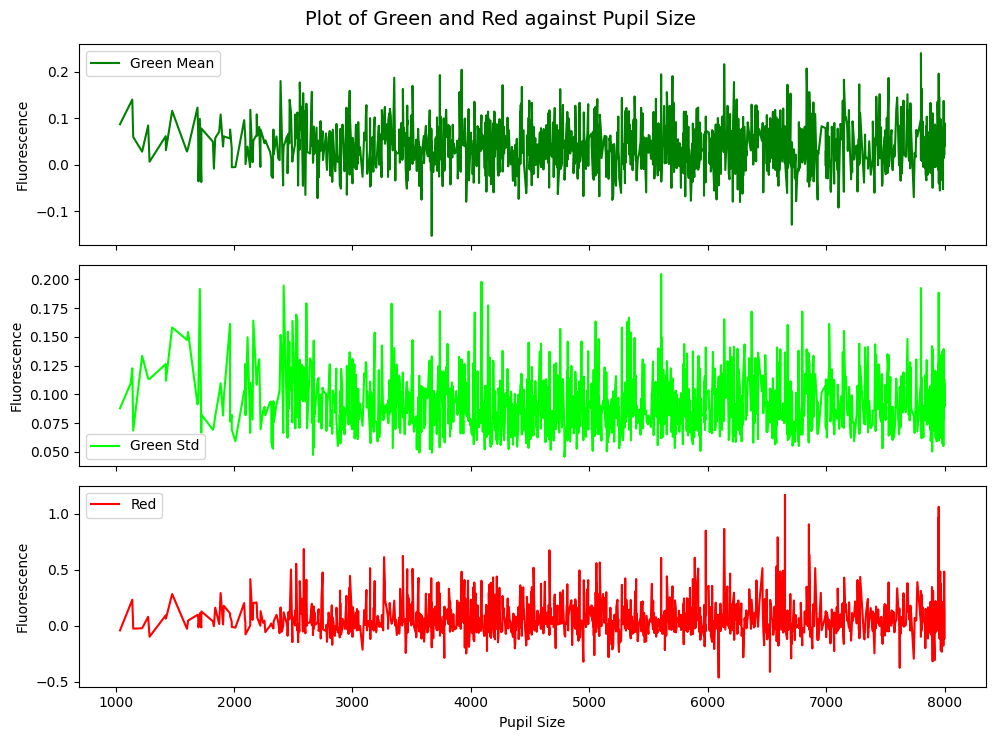

In [ ]:
# Get the indices that would sort the first column
sorted_indices = np.argsort(pupil_fluorescence[:, 0])

# Use the sorted indices to sort the entire array
sorted_pupil_fluorescence = pupil_fluorescence[sorted_indices]

# Separate the columns
p_size = sorted_pupil_fluorescence[:, 0]
green_m = sorted_pupil_fluorescence[:, 1]
green_s = sorted_pupil_fluorescence[:, 2]
red = sorted_pupil_fluorescence[:, 3]

# Set the figure size (width=10, height=6) and create subplots with 3 rows
fig, axes = plt.subplots(3, 1, figsize=(10, 7.5), sharex=True)

if decay_restoration:
    red_label = 'Red (bleach correction)'
else:
    red_label = 'Red'

# Plot the data on each subplot
axes[0].plot(p_size, green_m, label='Green Mean', color='green')
axes[1].plot(p_size, green_s, label='Green Std', color='lime')
axes[2].plot(p_size, red, label=red_label, color='red')

# Add labels, legends, and title to each subplot
axes[2].set_xlabel('Pupil Size')
for ax in axes:
    ax.set_ylabel('Fluorescence')
    ax.legend()
    ax.tick_params(axis='both', labelsize=10)  # Adjust tick size as desired
    # ax.set_title('Plot of Green and Red against Pupil Size', fontsize=14)  # Adjust title size as desired

# Add the title for the entire figure
fig.suptitle('Plot of Green and Red against Pupil Size', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

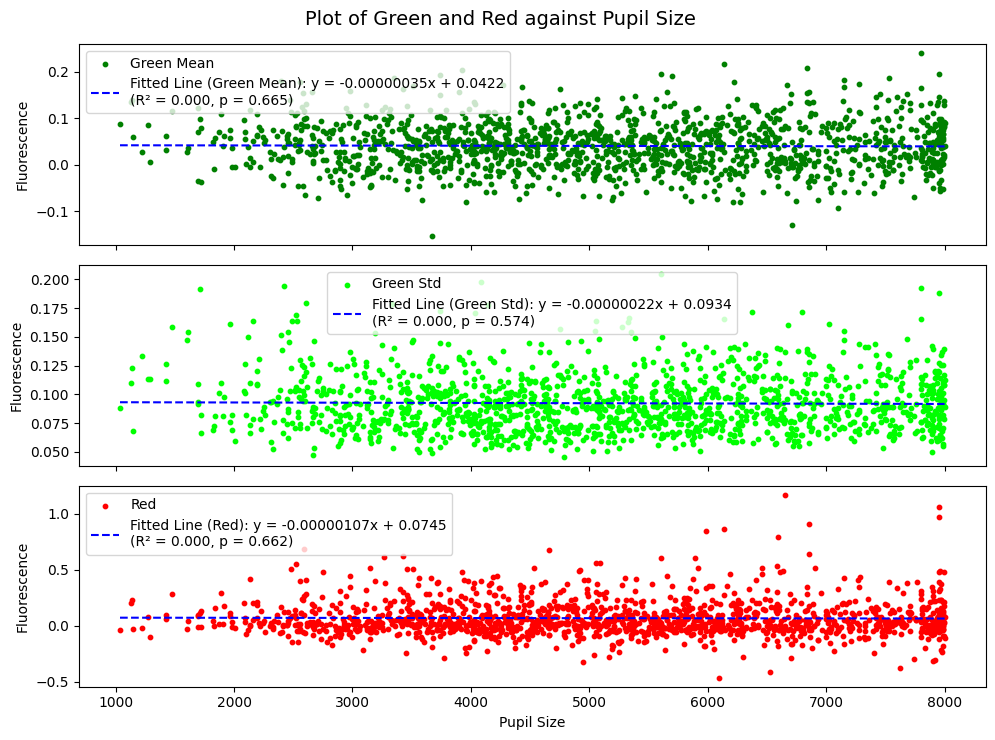

In [ ]:
# Set the figure size (width=10, height=6) and create subplots with 3 rows
fig, axes = plt.subplots(3, 1, figsize=(10, 7.5), sharex=True)

if decay_restoration:
    red_label = 'Red (bleach correction)'
else:
    red_label = 'Red'

# Size of the points for scatter plots
point_size = 10
# Scatter plots on each subplot
axes[0].scatter(p_size, green_m, label='Green Mean', color='green', s=point_size)
axes[1].scatter(p_size, green_s, label='Green Std', color='lime', s=point_size)
axes[2].scatter(p_size, red, label=red_label, color='red', s=point_size)

# Add linear fitted lines to each subplot
for ax, y_data, label in zip(axes, [green_m, green_s, red], ['Green Mean', 'Green Std', 'Red']):

    # Calculate R-squared and p-value
    from scipy.stats import linregress
    slope, intercept, r_value, p_value, _ = linregress(p_size, y_data)
    r_squared = r_value ** 2

    coeffs = np.polyfit(p_size, y_data, 1)
    fitted_line = np.polyval(coeffs, p_size)
    ax.plot(p_size, fitted_line, color='blue', linestyle='dashed',
            label=f'Fitted Line ({label}): y = {coeffs[0]:.8f}x + {coeffs[1]:.4f}\n(R² = {r_squared:.3f}, p = {p_value:.3f})')


# Add labels, legends, and title to each subplot
axes[2].set_xlabel('Pupil Size')
for ax in axes:
    ax.set_ylabel('Fluorescence')
    ax.legend()
    ax.tick_params(axis='both', labelsize=10)  # Adjust tick size as desired
    # ax.set_title('Plot of Green and Red against Pupil Size', fontsize=14)  # Adjust title size as desired

# Add the title for the entire figure
fig.suptitle('Plot of Green and Red against Pupil Size', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

### Plot graphs (condition separately)

#### Set sf, tf, and ori

In [ ]:
# Create sf array
sf = np.tile([0.02, 0.08, 0.32], 16)

# Create tf array
tf = np.tile([1, 1, 1, 4, 4, 4], 8)

# Create orientation array
orientation = np.repeat(np.arange(0, 360, 45), 6)

print("sf:", sf)
print("tf:", tf)
print("orientation:", orientation)

sf: [0.02 0.08 0.32 0.02 0.08 0.32 0.02 0.08 0.32 0.02 0.08 0.32 0.02 0.08
 0.32 0.02 0.08 0.32 0.02 0.08 0.32 0.02 0.08 0.32 0.02 0.08 0.32 0.02
 0.08 0.32 0.02 0.08 0.32 0.02 0.08 0.32 0.02 0.08 0.32 0.02 0.08 0.32
 0.02 0.08 0.32 0.02 0.08 0.32]
tf: [1 1 1 4 4 4 1 1 1 4 4 4 1 1 1 4 4 4 1 1 1 4 4 4 1 1 1 4 4 4 1 1 1 4 4 4 1
 1 1 4 4 4 1 1 1 4 4 4]
orientation: [  0   0   0   0   0   0  45  45  45  45  45  45  90  90  90  90  90  90
 135 135 135 135 135 135 180 180 180 180 180 180 225 225 225 225 225 225
 270 270 270 270 270 270 315 315 315 315 315 315]


#### Statistics of all

(1 )Overall Charactreistics of All Components Under All Conditions

statistics without distinguishing components and conditions


(2) Charactreistics of All Components Across Different Conditions

statistics distinguishing conditions but not components

In [ ]:
point_size = 30  # Adjust the point size as desired

# Create a big figure with 48x3 subplots
fig, axes = plt.subplots(nrows=48, ncols=3, figsize=(15, 150), constrained_layout=True)  # Adjust the figure size as desired

data_types = ['Green Mean', 'Green Std', 'Red']
if decay_restoration:
    data_types = ['Green Mean', 'Green Std', 'Red (bleach correction)']
colors = ['green', 'lime', 'red']

# Create 48 rows of figures
for x in range(48):
    for i, y_data_idx in enumerate([1, 2, 3]):
        y_data = pupil_fluorescence_condition[y_data_idx, :, x]
        x_data = pupil_fluorescence_condition[0, :, x]
        if i == 0:
            x_data_min = np.min(x_data)
            x_data_max = np.max(x_data)
            y_data_min = np.min(y_data)
            y_data_max = np.max(y_data)
            x_text = x_data_min - 0.6 * (x_data_max - x_data_min)
            y_text = 0.5 * (y_data_max + y_data_min)

        # Scatter plots on each subplot
        axes[x, i].scatter(x_data, y_data, label='Scatter Plot', color=colors[i], s=point_size)

        # Calculate R-squared and p-value
        from scipy.stats import linregress
        slope, intercept, r_value, p_value, _ = linregress(x_data, y_data)
        r_squared = r_value ** 2

        # Add linear fitted line to each subplot
        coeffs = np.polyfit(x_data, y_data, 1)
        fitted_line = np.polyval(coeffs, x_data)
        axes[x, i].plot(x_data, fitted_line, color='#1f77b4', linestyle='solid',
                         label=f'Fitted Line: y = {coeffs[0]:.8f}x + {coeffs[1]:.4f}\n(R² = {r_squared:.2f}, p = {p_value:.2f})')

        # Customize the plot
        axes[x, i].set_xlabel('Pupil Size', fontsize=12)  # Adjust the label size as desired
        axes[x, i].set_ylabel('Fluorescence', fontsize=12)  # Adjust the label size as desired
        axes[x, i].set_title(data_types[i], fontsize=14)  # Adjust the title size as desired
        axes[x, i].legend(fontsize='medium')

    # Write the group information to the right of each row
    axes[x, 0].text(x_text, y_text, f'Ori: {orientation[x]}° \nTF: {tf[x]} \nSF: {sf[x]}', fontsize=14, va='center')  # Adjust the position and font size as desired

fig.suptitle(f'Scatter Plots and Fitted lines of Green Mean, Green Std, and Red against Pupil Size ({cell_name})', fontsize=16)
# plt.tight_layout()  # Adjust the spacing between subplots
# using plt.tight_layout() will let fig.suptitle overlap the plots, so use constrained_layout=True in plt.subplots instead.
# filename = f'Scatter_Plots_Green_Mean_Std_Red_against_Pupil_{cell_name}.pdf'
# plt.savefig(filename)
# filename = f'Scatter_Plots_Green_Mean_Std_Red_against_Pupil_{cell_name}.png'
# plt.savefig(filename)
plt.show()


Output hidden; open in https://colab.research.google.com to view.

#### Statistics of groups

(3) Overall Charactreistics of Different Components Across Different Conditions

statistics distinguishing conditions and components

components are grouped with small groups (<3 components) neglected

In [ ]:
point_size = 30  # Adjust the point size as desired

# Create a big figure with 48-row subplots
n_cols = pupil_fluorescence_condition_groups.shape[0] - 1
figsize_width = 15 / 3 * n_cols
fig, axes = plt.subplots(nrows=48, ncols=n_cols, figsize=(figsize_width, 150), constrained_layout=True)  # Adjust the figure size as desired

data_types = ['Green Mean (all)', 'Green Std (all)']
for i in range(num_group):
    data_types.append(f"Green Mean (group {i+1})")
    data_types.append(f"Green Std (group {i+1})")
if decay_restoration:
    data_types.append('Red (bleach correction)')
else:
    data_types.append('Red')

colors = ['green' if i % 2 == 0 else 'lime' for i in range(2 * (num_group + 1))]
colors.append('red')

# print(data_types)
# print(colors)

# Create 48 rows of figures
for x in range(48):
    for i, y_data_idx in enumerate([_ for _ in range(1, n_cols + 1)]):
        y_data = pupil_fluorescence_condition_groups[y_data_idx, :, x]
        x_data = pupil_fluorescence_condition_groups[0, :, x]
        if i == 0:
            x_data_min = np.min(x_data)
            x_data_max = np.max(x_data)
            y_data_min = np.min(y_data)
            y_data_max = np.max(y_data)
            x_text = x_data_min - 0.6 * (x_data_max - x_data_min)
            y_text = 0.5 * (y_data_max + y_data_min)

        # Scatter plots on each subplot
        axes[x, i].scatter(x_data, y_data, label='Scatter Plot', color=colors[i], s=point_size)

        # Calculate R-squared and p-value
        from scipy.stats import linregress
        slope, intercept, r_value, p_value, _ = linregress(x_data, y_data)
        r_squared = r_value ** 2

        # Add linear fitted line to each subplot
        coeffs = np.polyfit(x_data, y_data, 1)
        fitted_line = np.polyval(coeffs, x_data)
        axes[x, i].plot(x_data, fitted_line, color='#1f77b4', linestyle='solid',
                         label=f'Fitted Line: y = {coeffs[0]:.8f}x + {coeffs[1]:.4f}\n(R² = {r_squared:.2f}, p = {p_value:.2f})')

        # Customize the plot
        axes[x, i].set_xlabel('Pupil Size', fontsize=12)  # Adjust the label size as desired
        axes[x, i].set_ylabel('Fluorescence', fontsize=12)  # Adjust the label size as desired
        axes[x, i].set_title(data_types[i], fontsize=14)  # Adjust the title size as desired
        axes[x, i].legend(fontsize='medium')

    # Write the group information to the right of each row
    axes[x, 0].text(x_text, y_text, f'Ori: {orientation[x]}° \nTF: {tf[x]} \nSF: {sf[x]}', fontsize=14, va='center')  # Adjust the position and font size as desired

fig.suptitle(f'Scatter Plots and Fitted lines of Green Mean, Green Std, and Red against Pupil Size ({cell_name})', fontsize=16)
# plt.tight_layout()  # Adjust the spacing between subplots
# using plt.tight_layout() will let fig.suptitle overlap the plots, so use constrained_layout=True in plt.subplots instead.
filename = f'Scatter_Plots_Green_Mean_Std_Red_against_Pupil_in_groups_{cell_name}.pdf'
plt.savefig(filename)
# filename = f'Scatter_Plots_Green_Mean_Std_Red_against_Pupil_in_groups_{cell_name}.png'
# plt.savefig(filename)
plt.show()


## Regression

### Logistic regression

In [ ]:
import os
import numpy as np
import scipy.io
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, r2_score
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random
import sys

In [ ]:
def plot_comparison(y_test, y_pred, subtitle = ''):
    # Sort y_pred and y_test based on y_test
    sorted_indices = np.argsort(y_test)
    sorted_y_pred = y_pred[sorted_indices]
    sorted_y_test = y_test[sorted_indices]
    # Plot sorted_y_pred and sorted_y_test
    plt.plot(sorted_y_pred, label='Sorted Predictions')
    plt.plot(sorted_y_test, label='Sorted Ground Truth')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title(f'Comparison of Sorted Predictions and Sorted Ground Truth \n ({subtitle})')
    plt.legend()
    plt.savefig(f'Comparison ({subtitle}).png', bbox_inches='tight')
    # bbox_inches='tight' will adjust the figure's bounding box to fit all the content, ensuring that
    # the complete words are visible in the saved figure. Otherwise, the saved figure may not show the
    # complete words, e.g., for x-label, or for the long title.
    # The default setting can sometimes result in cutoff or clipped text. It tries to include the entire
    # figure within the saved image, but there may be cases where the default behavior is not sufficient
    # to capture all the content. The default behavior assumes the figure content fits within the predefined
    # margins and padding.
    plt.show()

#### Divide train and val datasets

In [ ]:
# independent data
x = group_satcked_green

class_num = 480

# dependent data (labels/targets)
y = np.squeeze(stacked_red)
# print(np.max(y), np.min(y))

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=42)
# Calculate the minimum and maximum values
infinitesimal = np.finfo(float).eps
min_val = np.min(y) - infinitesimal # to guarantee to include min
max_val = np.max(y) + infinitesimal # to guarantee to include max
# Generate class_num+1 evenly spaced intervals
intervals = np.linspace(min_val, max_val, num=class_num+1) # num = class num + 1
# print(intervals)
# Digitize the array to get the indices of the intervals
y_train = np.digitize(y_train, intervals) - 1
y_test = np.digitize(y_test, intervals) - 1
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

# to see unique elements (see if we have all 0, 1,..., class_num-1 classes, better close to all)
unique_elements = np.unique(y_train)
print("Unique elements:", unique_elements)
print("Number of unique elements:", len(unique_elements))


x_train shape: (1368, 8)
y_train shape: (1368,)
x_test shape: (72, 8)
y_test shape: (72,)
Unique elements: [  0   9  16  25  26  31  41  44  46  47  48  50  53  54  55  56  57  58
  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 152 153 154 155 156 157 158 159 160 161 162 163 164 166 167 168
 169 170 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187
 188 189 191 192 193 194 195 196 197 199 200 201 202 205 206 207 208 210
 211 214 215 216 217 218 219 220 221 222 223 227 228 230 231 232 233 234
 235 240 242 244 247 255 256 257 259 261 263 265 267 268 271 273 274 277
 278 280 282 284 288 292 294 295 299 301 303 307 308 309 310 317 319 331
 334 339 341 346 

#### Fit and predict

'multinomial' (default option for multi-calss) achieves better performance than 'ovr'.

In [ ]:
# fit
model = linear_model.LogisticRegression(fit_intercept=True, max_iter=1000, multi_class='multinomial')
# model = linear_model.LogisticRegression(fit_intercept=True, max_iter=1000, multi_class='ovr')

fit_result = model.fit(x_train, y_train)
print(fit_result.intercept_.shape, fit_result.coef_.shape)
# print("Coefficients:", model.coef_[0,:])
# print("Intercept:", model.intercept_[0])
print('--- --- ---')

# predict
# Use the trained model to make predictions
y_pred = model.predict(x_test)
# Alternatively, you can get the predicted probabilities for each class
y_prob = model.predict_proba(x_test)

print('y_prob.shape:', y_prob.shape)
print(np.sum(y_prob, axis = 1))
# print(y_prob[0,:])

# Print the predicted class labels
print('y_pred:', y_pred)
print('y_test:', y_test)
print('y_pred shape:', y_pred.shape, 'y_test shape:', y_test.shape)
# Print the predicted probabilities
# print(y_prob)

(232,) (232, 8)
--- --- ---
y_prob.shape: (72, 232)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
y_pred: [ 99 102 166 113 104 113 113  96  98 107 115 113  91 113 104 102 117 111
 154  96  99 113 107 191 117  84 100  96 123 101 101 113 110 117 101  96
 140 102 106 101 106 100 136 111  95 127 113 142 247 102  84 102  96  99
 104 113  96  99 100 108  94 222 104  96 113  99 102 317 111 102 107  96]
y_test: [ 86 153 192 155 108 141 128 117  64 102 105 217  76 131  83  82 135 135
 100 111  76 202 163 109 138  70 123  90 115 105  95 216 154 145  85  99
 151  97  39 103  76 116 174 120  90 126 208 153 268  88 104  98  68 108
 161 142 118  95 116 143  97 236 101  80 233 100  79 300 105 142  91  70]
y_pred shape: (72,) y_test shape: (72,)


#### Evaluate

##### Evaluate (normal)

In previous data division, I classify data into class_num (e.g., class_num = 160) intervals (histogram, by np.digitize). Here, evaluate the results with the same number of classes (e.g., class_num = 160).

Accuracy: 0.0
Mean squared error: 1391.1666666666667
Correlation coefficient: 0.6843142747095321
Coefficient of determination (R-squared score, R2 score): 0.4255529638018637


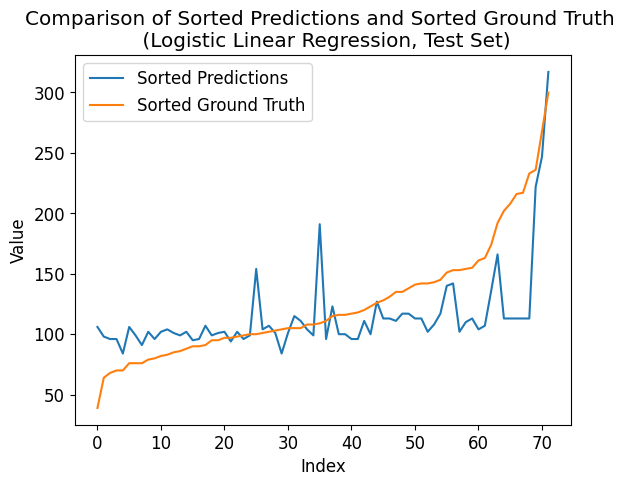

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# cm = confusion_matrix(y_test, y_pred)
# print("Confusion Matrix:") # y_test doesn't include all classes, so confusion matrix is less than num_class by num_class
# print(cm)
# the columns represent the predicted labels (predictions)
# the rows represent the true labels (ground truth)
#                Predicted Class
#           |   Class 1   |   Class 2   |   Class 3   |
# -----------------------------------------------------
# True Class   |     TP1     |     FN1     |     FN1     |
# -----------------------------------------------------
# True Class   |     FP2     |     TP2     |     FN2     |
# -----------------------------------------------------
# True Class   |     FN3     |     FP3     |     TP3     |

mse = mean_squared_error(y_test, y_pred)
print("Mean squared error:", mse)

# Calculate the correlation coefficient
correlation = np.corrcoef(y_pred, y_test)[0, 1]
print("Correlation coefficient:", correlation)

r_squared = r2_score(y_test, y_pred)
print("Coefficient of determination (R-squared score, R2 score):", r_squared)


# Sort y_pred and y_test based on y_test
plot_comparison(y_test, y_pred, 'Logistic Linear Regression, Test Set')

Accuracy: 0.09210526315789473
Mean squared error: 1739.1220760233919
Correlation coefficient: 0.6637453859151013
Coefficient of determination (R-squared score, R2 score): 0.4042761207332183


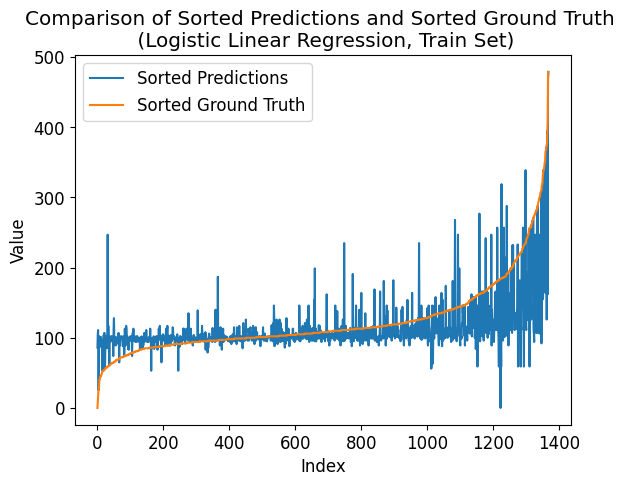

In [ ]:
# predict on train
# Use the trained model to make predictions
y_pred_ = model.predict(x_train)
# Alternatively, you can get the predicted probabilities for each class
y_prob_ = model.predict_proba(x_train)

accuracy = accuracy_score(y_train, y_pred_)
print("Accuracy:", accuracy)

# cm = confusion_matrix(y_train, y_pred_)
# print("Confusion Matrix:")
# print(cm)
# the columns represent the predicted labels (predictions)
# the rows represent the true labels (ground truth)
#                Predicted Class
#              |   Class 1   |   Class 2   |   Class 3   |
# -----------------------------------------------------
# True Class   |     TP1     |     FN1     |     FN1     |
# -----------------------------------------------------
# True Class   |     FP2     |     TP2     |     FN2     |
# -----------------------------------------------------
# True Class   |     FN3     |     FP3     |     TP3     |

mse = mean_squared_error(y_train, y_pred_)
print("Mean squared error:", mse)

# Calculate the correlation coefficient
correlation = np.corrcoef(y_pred_, y_train)[0, 1]
print("Correlation coefficient:", correlation)

r_squared = r2_score(y_train, y_pred_)
print("Coefficient of determination (R-squared score, R2 score):", r_squared)

plot_comparison(y_train, y_pred_, 'Logistic Linear Regression, Train Set')

##### Evaluate (reduced)

The model is based on classifying data into class_num (e.g., class_num = 160) intervals (histogram, by np.digitize). Here, evaluate the results a smaller number of classes (e.g., reduced_class_num = 16), that is, for the example of class_num = 160 and reduced_class_num = 16, classes 0, 1, ..., 15 become one class, i.e., 0; ...; classes 144, 145, ..., 159 become one class, i.e., 15.

In [ ]:
print("---- ---- ----")
# Define the boundaries for digitization
reduced_class_num = 16
intervals = np.arange(0, class_num + 1, class_num / reduced_class_num)
print(intervals)

y_train_digital = np.digitize(y_train, intervals) - 1
y_test_digital = np.digitize(y_test, intervals) - 1
y_pred_train_digital = np.digitize(y_pred_, intervals) - 1
y_pred_test_digital = np.digitize(y_pred, intervals) - 1
print(y_pred)
print(y_pred_test_digital)
mse = mean_squared_error(y_test_digital, y_pred_test_digital)
print("Mean squared error:", mse)
correlation = np.corrcoef(y_pred_test_digital, y_test_digital)[0, 1]
print("Correlation coefficient:", correlation)
r_squared = r2_score(y_test_digital, y_pred_test_digital)
print("Coefficient of determination (R-squared score, R2 score):", r_squared)
mse = mean_squared_error(y_train_digital, y_pred_train_digital)
print("Mean squared error:", mse)
correlation = np.corrcoef(y_pred_train_digital, y_train_digital)[0, 1]
print("Correlation coefficient:", correlation)
r_squared = r2_score(y_train_digital, y_pred_train_digital)
print("Coefficient of determination (R-squared score, R2 score):", r_squared)

---- ---- ----
[  0.  30.  60.  90. 120. 150. 180. 210. 240. 270. 300. 330. 360. 390.
 420. 450. 480.]
[ 99 102 166 113 104 113 113  96  98 107 115 113  91 113 104 102 117 111
 154  96  99 113 107 191 117  84 100  96 123 101 101 113 110 117 101  96
 140 102 106 101 106 100 136 111  95 127 113 142 247 102  84 102  96  99
 104 113  96  99 100 108  94 222 104  96 113  99 102 317 111 102 107  96]
[ 3  3  5  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  5  3  3  3  3  6
  3  2  3  3  4  3  3  3  3  3  3  3  4  3  3  3  3  3  4  3  3  4  3  4
  8  3  2  3  3  3  3  3  3  3  3  3  3  7  3  3  3  3  3 10  3  3  3  3]
Mean squared error: 1.8611111111111112
Correlation coefficient: 0.6044187652504551
Coefficient of determination (R-squared score, R2 score): 0.3066973268180512
Mean squared error: 2.1637426900584797
Correlation coefficient: 0.6209554649484783
Coefficient of determination (R-squared score, R2 score): 0.35021345672807513


Fixing the reduced class number, I enumerate the original class number to see what a original class number is better.

In [ ]:
# independent data
x = group_satcked_green
# dependent data (labels/targets)
y = np.squeeze(stacked_red)

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=42)
# Calculate the minimum and maximum values
infinitesimal = np.finfo(float).eps
min_val = np.min(y) - infinitesimal # to guarantee to include min
max_val = np.max(y) + infinitesimal # to guarantee to include max

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

reduced_class_num = 16
class_num_array = np.arange(reduced_class_num, reduced_class_num * 100 + 1, reduced_class_num)
# class_num_array = np.arange(reduced_class_num * 5, reduced_class_num * 40 + 1, reduced_class_num)
mse_test_list = []
correlation_test_list = []
r_squared_test_list = []
mse_train_list = []
correlation_train_list = []
r_squared_train_list = []

for class_num in class_num_array:
    print('---- ---- ----')
    print(f'class_num = {class_num}')

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=42)

    # Generate class_num+1 evenly spaced intervals
    intervals = np.linspace(min_val, max_val, num=class_num+1) # num = class num + 1
    # print(intervals)
    # Digitize the array to get the indices of the intervals
    y_train = np.digitize(y_train, intervals) - 1
    y_test = np.digitize(y_test, intervals) - 1

    # to see unique elements (see if we have all 0, 1,..., class_num-1 classes, better close to all)
    unique_elements = np.unique(y_train)
    # print("Unique elements:", unique_elements)
    print("Number of unique elements:", len(unique_elements))

    model = linear_model.LogisticRegression(fit_intercept=True, max_iter=1000, multi_class='multinomial')
    fit_result = model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    y_pred_ = model.predict(x_train)

    # Define the boundaries for digitization
    intervals = np.arange(0, class_num+1, class_num/16)
    print(intervals)

    y_train_digital = np.digitize(y_train, intervals) - 1
    y_test_digital = np.digitize(y_test, intervals) - 1
    y_pred_train_digital = np.digitize(y_pred_, intervals) - 1
    y_pred_test_digital = np.digitize(y_pred, intervals) - 1
    # print(y_pred)
    # print(y_pred_test_digital)
    print("test eval:")
    mse = mean_squared_error(y_test_digital, y_pred_test_digital)
    print("Mean squared error:", mse)
    correlation = np.corrcoef(y_pred_test_digital, y_test_digital)[0, 1]
    print("Correlation coefficient:", correlation)
    r_squared = r2_score(y_test_digital, y_pred_test_digital)
    print("Coefficient of determination (R-squared score, R2 score):", r_squared)
    mse_test_list.append(mse)
    correlation_test_list.append(correlation)
    r_squared_test_list.append(r_squared)

    print("train eval:")
    mse = mean_squared_error(y_train_digital, y_pred_train_digital)
    print("Mean squared error:", mse)
    correlation = np.corrcoef(y_pred_train_digital, y_train_digital)[0, 1]
    print("Correlation coefficient:", correlation)
    r_squared = r2_score(y_train_digital, y_pred_train_digital)
    print("Coefficient of determination (R-squared score, R2 score):", r_squared)
    mse_train_list.append(mse)
    correlation_train_list.append(correlation)
    r_squared_train_list.append(r_squared)

    plot_comparison(y_test, y_pred, f'Logistic Linear Regression Reduced Evaluation {class_num} to {reduced_class_num}, Test Set')
    plot_comparison(y_train, y_pred_, f'Logistic Linear Regression Reduced Evaluation {class_num} to {reduced_class_num}, Train Set')



Output hidden; open in https://colab.research.google.com to view.

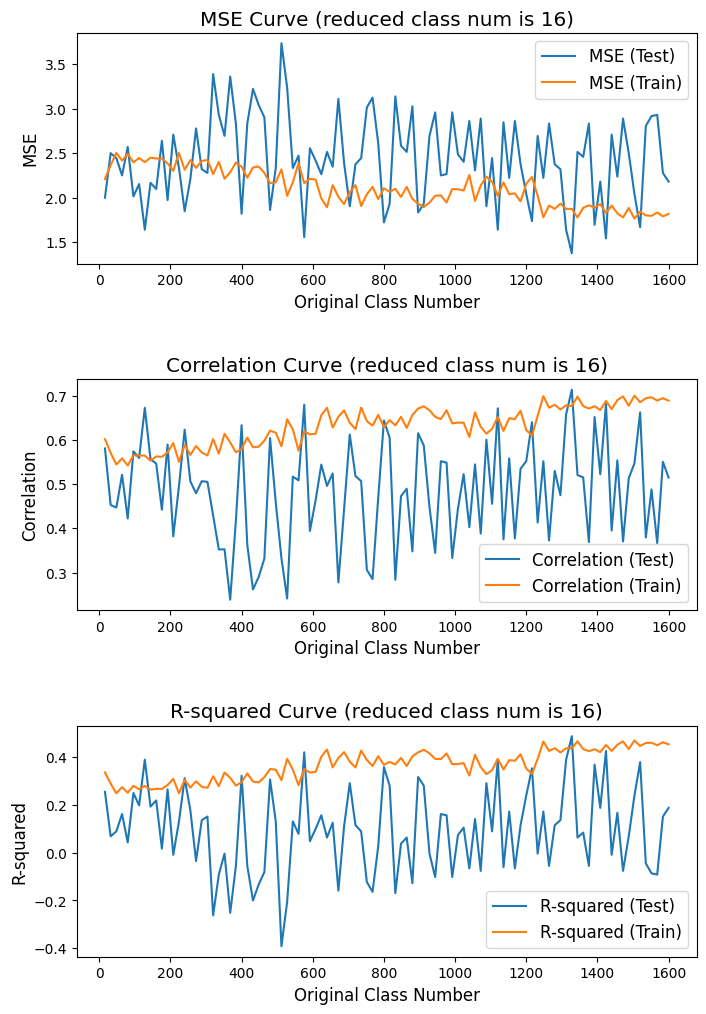

Max Index: 82
Max Original Class Num: 1328


In [ ]:
# plot the trend figures of mse, correlation, and r2

# Create a figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 12))

# Plot MSE
ax1.plot(class_num_array, mse_test_list, label='MSE (Test)')
ax1.plot(class_num_array, mse_train_list, label='MSE (Train)')
ax1.set_ylabel('MSE')
ax1.set_xlabel('Original Class Number')
ax1.set_title(f'MSE Curve (reduced class num is {reduced_class_num})')
ax1.legend()

# Plot Correlation
ax2.plot(class_num_array, correlation_test_list, label='Correlation (Test)')
ax2.plot(class_num_array, correlation_train_list, label='Correlation (Train)')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Original Class Number')
ax2.set_title(f'Correlation Curve (reduced class num is {reduced_class_num})')
ax2.legend()

# Plot R-squared
ax3.plot(class_num_array, r_squared_test_list, label='R-squared (Test)')
ax3.plot(class_num_array, r_squared_train_list, label='R-squared (Train)')
ax3.set_ylabel('R-squared')
ax3.set_xlabel('Original Class Number')
ax3.set_title(f'R-squared Curve (reduced class num is {reduced_class_num})')
ax3.legend()

# Increase the vertical spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Adjust tick, label, title, and legend font sizes
plt.rcParams.update({'font.size': 12})
ax1.tick_params(labelsize=10)
ax2.tick_params(labelsize=10)
ax3.tick_params(labelsize=10)

# Save the figure
plt.savefig(f'mse_correlation_r2_trend_curve_reduced_eval_reduced_class_num_{reduced_class_num}.png', bbox_inches='tight')

# Show the figure
plt.show()

# Convert r_squared_test_list to a NumPy array
r_squared_test_array = np.array(r_squared_test_list)
# Find the index of the maximum value
max_index = np.argmax(r_squared_test_array)
# Get the corresponding class_num value
max_class_num = class_num_array[max_index]

# Print the index and corresponding class_num
print("Max Index:", max_index)
print("Max Original Class Num:", max_class_num)

In [ ]:
# calculate the mean value for the metrics in all situations
mse_test_array = np.array(mse_test_list)
r_squared_test_array = np.array(r_squared_test_list)
mse_train_array = np.array(mse_train_list)
r_squared_train_array = np.array(r_squared_train_list)
mse_test_mean = np.mean(mse_test_array)
r_squared_test_mean = np.mean(r_squared_test_array)
mse_train_mean = np.mean(mse_train_array)
r_squared_train_mean = np.mean(r_squared_train_array)

# Print the index and corresponding class_num
print("mean of mse test:", mse_test_mean)
print("mean of r2 score test:", r_squared_test_mean)
print("mean of mse train:", mse_train_mean)
print("mean of r2 score train:", r_squared_train_mean)


mean of mse test: 2.431944444444444
mean of r2 score test: 0.09405001437194593
mean of mse train: 2.1110526315789477
mean of r2 score train: 0.3660366371466698
